In [1]:
1+1

2

In [2]:
import uproot
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
import matplotlib as mpl
import h5py
import math

from util import *

import var
import cut
import data
import hist

import importlib

from pyanalib import panda_helpers
from unc_funcs import *

/exp/icarus/app/users/jdyer/dev_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib/python3.9/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.20.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[0.39431672 0.04210058 0.91800973]


In [3]:
# Thresholds to use for Cuts - NOMINAL

NuMI_angle_thresh = 0.11 #0.13 #0.06 (Nominal: 0.11) (Optimized: 0.05)
open_angle_thresh = 0.7 #0.8 #0.2 (Nominal: 0.7) (Optimized:  0.35)
max_shw_len_thresh = 20. #25 #0 #cm (Nominal: 20) (Optimized: 0.)
#other_trk_len_thresh =  #cm (Nominal: ) (Optimized: 0.)
#third_trk_dist_thresh =  #cm (Nominal: ) (Optimized: 0.)

trk_len_thresh = 140. # cm

#hasstub = (df.stub.l0_5cm.dqdx > 5e5) | (df.stub.l1cm.dqdx > 3e5) | (df.stub.l2cm.dqdx > 2.5e5) | (df.stub.l3cm.dqdx > 2e5)
stub_dqdx_l0_5cm_thresh = 5e5 #4.1e5 #3.8e5 (Nominal: 500K) (Optimized: 5e5)
stub_dqdx_l1cm_thresh = 4e5 #3.0e5 #1.6e5 #3e5 (Nominal: 400K) (Optimized: 2.4e5)
stub_dqdx_l2cm_thresh =  3.5e5 #2.1e5 #2e5 #2.5e5 (Nominal: 350K) (Optimized: 2e5)
stub_dqdx_l3cm_thresh =  2e5 #1.9e5 #1.4e5 (Nominal: 200K) (Optimized: 1.6e5)
var_ths = [stub_dqdx_l0_5cm_thresh, stub_dqdx_l1cm_thresh, stub_dqdx_l2cm_thresh, stub_dqdx_l3cm_thresh]

chi2_mu_forMuons = 30 #23 #16 (Nominal: 30) (Optimized: 18)
chi2_p_forMuons = 100 # (Nominal: 100) (Optimized: 90)

In [3]:
# Thresholds to use for Cuts - OPTIMAL

NuMI_angle_thresh = 0.05
open_angle_thresh = 0.35
max_shw_len_thresh = 0.

trk_len_thresh = 140. # cm

#hasstub = (df.stub.l0_5cm.dqdx > 5e5) | (df.stub.l1cm.dqdx > 3e5) | (df.stub.l2cm.dqdx > 2.5e5) | (df.stub.l3cm.dqdx > 2e5)
stub_dqdx_l0_5cm_thresh = 5e5 #4.1e5 #3.8e5 (Nominal: 500K) (Optimized: 5e5)
stub_dqdx_l1cm_thresh = 2.4e5
stub_dqdx_l2cm_thresh = 2e5
stub_dqdx_l3cm_thresh =  1.6e5
var_ths = [stub_dqdx_l0_5cm_thresh, stub_dqdx_l1cm_thresh, stub_dqdx_l2cm_thresh, stub_dqdx_l3cm_thresh]

chi2_mu_forMuons = 18
chi2_p_forMuons = 90 

In [4]:
importlib.reload(var)
importlib.reload(cut)
importlib.reload(data)
importlib.reload(hist)
importlib.reload(panda_helpers)

<module 'pyanalib.panda_helpers' from '/exp/icarus/app/users/jdyer/dev_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/panda_helpers.py'>

In [5]:
plt.rcParams.update({'font.size': 16})
mpl.rcParams['lines.linewidth'] = 4.

dosave = False
#savedir = "/icarus/app/users/gputnam/evtsel-ana/plots_Jan9/"
savedir = "/icarus/data/users/jdyer/muon_selection/"

#savedata = False
#datadir = "/icarus/data/users/gputnam/dimuon-data/"


In [6]:
# DEFINE FUNCTIONS

def decay_weight(in_dist, out_dist, mean_dist):
    return np.exp(-in_dist / mean_dist) - \
          np.exp(-out_dist / mean_dist)
    
def flux_weight(mixing):
    return mixing * mixing

def reweight_mixing(newmixing, start, enter, exit, mean_dist, oldmixing=1e-5):
    dist_in = dist(enter, start)
    dist_out = dist(exit, start)
    
    old_dcy = decay_weight(dist_in, dist_out, mean_dist)
    new_dcy = decay_weight(dist_in, dist_out, mean_dist / (newmixing**2 / oldmixing**2))
    
    old_flux = flux_weight(oldmixing)
    new_flux = flux_weight(newmixing)
    
    return (new_flux / old_flux) * (new_dcy / old_dcy)

def jamie_sample_concat(dflist): # dflist should be a list of multi-index dataframes
    master_df = pd.concat(dflist, keys=np.arange(len(dflist)), names=['sample'])
    return master_df

# The following function takes an event dataframe, and uses truth information to determine what type of
#    neutrino interaction it is. It then saves that as 'nu_mode' and adds the label to the dataframe, returning the df.
# WARNING: only apply this to a dataframe with only neutrinos, otherwise you might get confused.
def add_nu_int_type(df):
    new_df = df.copy()
    nu_mode = []
    for ind in new_df.index:
        row = df.loc[ind]
        iscc = bool(int(row.slc.truth.iscc))
        genie_mode = int(row.slc.truth.genie_mode)
        nu_pdg = int(row.slc.truth.pdg)
        npi = int(row.slc.truth.npi)
        npi0 = int(row.slc.truth.npi0)
        max_p_ke = int(row.slc.truth.max_proton_ke)
        if (np.abs(nu_pdg) == 14) & (iscc): # nu mu CC
            if genie_mode == 3: # nu mu CC COH 
                nu_mode.append('$\\nu_\\mu$ CC COH')
            elif npi >=1 & npi0 == 0:
                if  max_p_ke < 0.02:
                    nu_mode.append("$\\nu_\\mu$ CC n$\\pi$0p")
                else:
                    nu_mode.append("$\\nu_\\mu$ CC n$\\pi$np")
            else: 
                nu_mode.append("$\\nu_\\mu$ CC Other") 
        else: 
            nu_mode.append("not $\\nu_\\mu$ CC") 
        #except: nu_mode.append('-')
    new_df['nu_mode'] = nu_mode
    return new_df
    
def add_hdr_info(df):
    new_df = df.copy()
    proc = []
    clust = []
    for idx in df.index:
        p = int(hdrs[idx[0]].loc[(idx[1],idx[2])].proc)
        c = int(hdrs[idx[0]].loc[(idx[1],idx[2])].cluster)
        proc.append(p)
        clust.append(c)
    new_df['proc'] = proc
    new_df['cluster'] = clust
    return new_df

In [7]:
# CAN SKIP THIS CELL

#for c in hdrs[0].columns: print(c)
print('')
#for c in mcdfs[0].columns: print(c)
#print(mcdfs[0].Q2)
print('')
#for c in evtdfs[0].columns: print(c)
#print(pd.read_hdf("/icarus/data/users/gputnam/dimuon-data/higgs-gen-A/higgs_M220_DMCP2023G_evt_new.df").keys)

old_nu_file = "/icarus/data/users/gputnam/dimuon-data/mcnu_phase2_evt_new.df"
new_nu_file = "/icarus/data/users/gputnam/DMCP2023G/mc/mcnuphase2_evt_reprodD.df"
cohlike_nu_file = "/icarus/data/users/gputnam/DMCP2023G/mc/coh-like-evt.df"

f = h5py.File(new_nu_file, 'r')
print(f.keys())

#m = pd.read_hdf(old_nu_file, key="mcnu")
evt = pd.read_hdf(new_nu_file, key="evt")
#for c in evt.columns: print(c)
#m[m.index.duplicated()]




<KeysViewHDF5 ['evt', 'hdr', 'mch', 'mcnu']>


In [7]:
# test the new 500 MeV ALP dataframe I just made:

#newALPfile = "/icarus/data/users/jdyer/dimuon-data/axion-no-suppression/alp_M500_faE6_DMC2023G_evt_small.df"
newALPfile = "/icarus/data/users/jdyer/dimuon-data/axion-no-suppression/alp_M500_faE6_DMC2023G_evt.df"

f = h5py.File(newALPfile, 'r')
print(f.keys())

new_evtdf = pd.read_hdf(newALPfile, key="evt")
print(new_evtdf.shape)

for c in new_evtdf.columns:
    print(c)

new_mcdf = pd.read_hdf(newALPfile, key="mch")
print(new_mcdf.shape)
new_mcdf.iloc[0].C1

#new_mcdf

<KeysViewHDF5 ['evt', 'hdr', 'mch', 'mcnu', 'mcnuwgt']>
(10595, 242)
('slc', 'is_clear_cosmic', '', '', '', '')
('slc', 'vertex', 'x', '', '', '')
('slc', 'vertex', 'y', '', '', '')
('slc', 'vertex', 'z', '', '', '')
('slc', 'self', '', '', '', '')
('slc', 'tmatch', 'eff', '', '', '')
('slc', 'tmatch', 'pur', '', '', '')
('slc', 'tmatch', 'idx', '', '', '')
('slc', 'producer', '', '', '', '')
('slc', 'nuid', 'crlongtrkdiry', '', '', '')
('slc', 'truth', 'E', '', '', '')
('slc', 'truth', 'bjorkenX', '', '', '')
('slc', 'truth', 'inelasticityY', '', '', '')
('slc', 'truth', 'Q2', '', '', '')
('slc', 'truth', 'w', '', '', '')
('slc', 'truth', 't', '', '', '')
('slc', 'truth', 'position', 'x', '', '')
('slc', 'truth', 'position', 'y', '', '')
('slc', 'truth', 'position', 'z', '', '')
('slc', 'truth', 'pdg', '', '', '')
('slc', 'truth', 'iscc', '', '', '')
('slc', 'truth', 'genie_mode', '', '', '')
('slc', 'truth', 'max_proton_ke', '', '', '')
('slc', 'truth', 'nn', '', '', '')
('slc', 'tru

(21650, 18)


    1000000.0
Name: (12, 0, 0), dtype: float64

In [8]:
#%%time

higgs_files = [
    "/icarus/data/users/gputnam/dimuon-data/higgs-gen-A/higgs_M220_DMCP2023G_evt_new.df",
    "/icarus/data/users/gputnam/dimuon-data/higgs-gen-A/higgs_M240_DMCP2023G_evt_new.df",
    "/icarus/data/users/gputnam/dimuon-data/higgs-gen-A/higgs_M260_DMCP2023G_evt_new.df",
    "/icarus/data/users/gputnam/dimuon-data/higgs-gen-A/higgs_M300_DMCP2023G_evt_new.df",
    "/icarus/data/users/gputnam/dimuon-data/higgs-gen-A/higgs_M330_DMCP2023G_evt_new.df",
]
higgs_mcdfs = [pd.read_hdf(f, key="mch") for f in higgs_files]
higgs_masses = [int(round(df.iloc[(0)].M*1000.)) for df in higgs_mcdfs]
higgs_thetas = [float(df.iloc[(0)].C1) for df in higgs_mcdfs]
higgs_mass_labels = []
higgs_th_labels = []
higgs_labels = []
for i in range(len(higgs_files)):
    higgs_mass_labels.append("$M_S$ = %a" % higgs_masses[i])
    higgs_th_labels.append("$\\theta_S$ = %a" % higgs_thetas[i])
    higgs_labels.append(higgs_mass_labels[i] + ", " + higgs_th_labels[i])

## DON'T USE THESE!
## HEAVY QCD AXIONS (aka ALPs) WITH MASS SUPPRESSION
## Note: Josh thinks the power law mass suppression is a bad idea.

##alp_masses = [300, 500, 600]
##alp_labels = ["$M_{ALP}$ = %iMeV" % mass for mass in alp_masses]
#alp_files = [
#    "/icarus/data/users/gputnam/dimuon-data/higgs-gen-A/axion-with-suppression/alp_M300_DMC2023G_evt.df",
#    "/icarus/data/users/gputnam/dimuon-data/higgs-gen-A/axion-with-suppression/alp_M500_DMC2023G_evt.df",
#    "/icarus/data/users/gputnam/dimuon-data/higgs-gen-A/axion-with-suppression/alp_M600_DMC2023G_evt.df"
#]
#alp_mcdfs = [pd.read_hdf(f, key="mch") for f in alp_files]
#alp_masses = [int(round(df.iloc[(0)].M*1000.)) for df in alp_mcdfs]
#alp_fa = [float(df.iloc[(0)].C1) for df in alp_mcdfs] #play with this one!
#alp_cAl = [float(df.iloc[(0)].C2) for df in alp_mcdfs]
#alp_mass_labels = []
#alp_fa_labels = []
#alp_cAl_labels = []
#alp_labels = []
#for i in range(len(alp_files)):
#    alp_mass_labels.append("$M_{ALP}$ = %a" % alp_masses[i])
#    alp_fa_labels.append("$fa$ = %a" % alp_fa[i])
#    alp_cAl_labels.append("$c$ = %a" % alp_cAl[i])
#    alp_labels.append(alp_mass_labels[i] + ", " + alp_cAl_labels[i] + ", " + alp_fa_labels[i])

# ALPs WITHOUT MASS SUPPRESSION
alp_nosup_files = [
    "/icarus/data/users/gputnam/dimuon-data/higgs-gen-A/axion-no-suppression/alp_M300_DMC2023G_evt.df",
    "/icarus/data/users/gputnam/dimuon-data/higgs-gen-A/axion-no-suppression/alp_M350_DMC2023G_evt.df",
    "/icarus/data/users/gputnam/dimuon-data/higgs-gen-A/axion-no-suppression/alp_M400_DMC2023G_evt.df",
    "/icarus/data/users/gputnam/dimuon-data/higgs-gen-A/axion-no-suppression/alp_M450_DMC2023G_evt.df",
    "/icarus/data/users/gputnam/dimuon-data/higgs-gen-A/axion-no-suppression/alp_M500_DMC2023G_evt.df",
    #"/icarus/data/users/jdyer/dimuon-data/axion-no-suppression/alp_M500_faE6_DMC2023G_evt.df",
    "/icarus/data/users/gputnam/dimuon-data/higgs-gen-A/axion-no-suppression/alp_M600_DMC2023G_evt.df",
    "/icarus/data/users/gputnam/dimuon-data/higgs-gen-A/axion-no-suppression/alp_M650_DMC2023G_evt.df"
    #"/icarus/data/users/jdyer/dimuon-data/axion-no-suppression/alp_M500_faE6_DMC2023G_evt.df" # this one regenerated with fa=E6.
]
alp_nosup_mcdfs = [pd.read_hdf(f, key="mch") for f in alp_nosup_files]
alp_nosup_masses = [int(round(df.iloc[(0)].M*1000.)) for df in alp_nosup_mcdfs]
alp_nosup_fa = [float(df.iloc[(0)].C1) for df in alp_nosup_mcdfs] #play with this one!
alp_nosup_cAl = [float(df.iloc[(0)].C2) for df in alp_nosup_mcdfs]
alp_nosup_mass_labels = []
alp_nosup_fa_labels = []
alp_nosup_cAl_labels = []
alp_nosup_labels = []
for i in range(len(alp_nosup_files)):
    alp_nosup_mass_labels.append("$M_{ALP}$ = %a" % alp_nosup_masses[i])
    alp_nosup_fa_labels.append("$fa$ = %a" % alp_nosup_fa[i])
    alp_nosup_cAl_labels.append("$c$ = %a" % alp_nosup_cAl[i])
    alp_nosup_labels.append(alp_nosup_mass_labels[i] + ", " + alp_nosup_cAl_labels[i] + ", " + alp_nosup_fa_labels[i])

# NEUTRINOS
old_nu_file = "/icarus/data/users/gputnam/dimuon-data/mcnu_phase2_evt_new.df" # this df has duplicate indices
new_nu_file = "/icarus/data/users/gputnam/DMCP2023G/mc/mcnuphase2_evt_reprodD.df" # this is higher stats, and mcdf has systematics. cs
cohlike_nu_file = "/icarus/data/users/gputnam/DMCP2023G/mc/coh-like-evt.df"

mcfile = "/icarus/data/users/gputnam/DMCP2023G/mc/dfs-wstubs/mcnuphase2_evt_reprodD.df"

nu_files = [new_nu_file] 
nu_labels = ["$\\nu$"]*len(nu_files)
nu_masses = [-1]*len(nu_files)
#nu_mcdfs = [pd.read_hdf(f, key="mcnu") for f in nu_files]

labels = higgs_labels + alp_nosup_labels + nu_labels

In [9]:

masses = higgs_masses + alp_nosup_masses + nu_masses # MeV 
#params_1 = higgs_params # + 
labels = higgs_labels + alp_nosup_labels + nu_labels
df_files = higgs_files + alp_nosup_files + nu_files 
evtdfs = [pd.read_hdf(f, key="evt") for f in df_files]
#mcdfs = higgs_mcdfs + alp_nosup_mcdfs# + nu_mcdfs
hdrs = [pd.read_hdf(f, key="hdr") for f in df_files]
pots = [np.sum(hdr.pot * hdr.first_in_subrun) for hdr in hdrs]


In [10]:
GOAL_POT = 2e20 
for i in range(len(df_files)):
    evtdfs[i]["scale"] = GOAL_POT / pots[i]
    #mcdfs[i]["scale"] = GOAL_POT / pots[i]
    evtdfs[i]["bsm_mass"] = masses[i]
    evtdfs[i]["sample"] = labels[i]
    evtdfs[i]["higgs"] = False
    #evtdfs[i]["axion"] = False
    #evtdfs[i]["alp"] = False
    evtdfs[i]["alp_nosup"] = False
    evtdfs[i]["alp_withsup"] = False
    evtdfs[i]["nu"] = False
    x = df_files[i].split('/')
    if "higgs" in x[-1]:
        #print('higgs')
        evtdfs[i]["higgs"] = True
    if "alp" in x[-1]:
        if "-no-" in x[-2]:
            evtdfs[i]["alp_nosup"] = True
            #print("no sup")
        if "with" in x[-2]:
            evtdfs[i]["alp_withsup"] = True
            #print("with sup")
        #print('alp')
        #evtdfs[i]["alp"] = True
    if ("nu" in x[-1]) | ("coh-" in x[-1]):
        #print('nu')
        evtdfs[i]["nu"] = True

POTSTR = "2e20 POT"


In [11]:
# SORT TYPES OF NEUTRINO BACKGROUND

# numu cc:
numu_cc = (np.abs(nu_mcdf.pdg) == 14) & nu_mcdf.iscc

# sub-categories for numu CC:

mc_is_nu_coh = (nu_mcdf.genie_mode == 3) & numu_cc
mc_is_nu_coh.name = "$\\nu_\\mu$ CC COH"

mc_is_nu_pi = (nu_mcdf.npi >= 1) & (nu_mcdf.max_proton_ke < 0.02) & (nu_mcdf.npi0 == 0) & ~mc_is_nu_coh & numu_cc
mc_is_nu_pi.name = "$\\nu_\\mu$ CC n$\\pi$0p"
                                              
mc_is_nu_pip = (nu_mcdf.npi >= 1) & (nu_mcdf.max_proton_ke >= 0.02) & (nu_mcdf.npi0 == 0) & ~mc_is_nu_coh & numu_cc
mc_is_nu_pip.name = "$\\nu_\\mu$ CC n$\\pi$np"                                              

mc_is_nu_other = ~mc_is_nu_coh & ~mc_is_nu_pi & ~mc_is_nu_pip & numu_cc
mc_is_nu_other.name = "$\\nu_\\mu$ CC Other"

NameError: name 'nu_mcdf' is not defined

In [12]:
#del evtdf
#evtdf = sample_concat(h_evtdf, nu_evtdf, offset=1_000_000)
#evtdf = sample_concat(evtdfs, offset=1_000_000)
evtdf = jamie_sample_concat(evtdfs)

#print('\n evtdf.shape: ', evtdf.shape)
evtdf

slc                          \
                                     is_clear_cosmic      vertex               
                                                               x           y   
                                                                               
                                                                               
                                                                               
sample __ntuple entry rec.slc..index                                           
0      22       5     3                            0 -132.079895 -108.745605   
                9     12                           0   91.704063   16.856659   
                20    27                           0   76.075203   15.322388   
       18       5     2                            0 -147.838745   73.346970   
                6     14                           0  260.097992   62.527771   
..                                               ...         ...         ...   
12     6996     293   0                            0 -128.295349   51.573456   
                      2                            0 -298.347168   -1.871338   
                294   17                           0  219.136017    6.720139   
                298   6                            0 -245.351456   91.565361   
                299   22                           0  233.048660  -56.791489   

                                                                           \
                                                 self    tmatch             
                                               z            eff       pur   
                                                                            
                                                                            
                                                                            
sample __ntuple entry rec.slc..index                                        
0      22       5     3               711.672729  168  0.921939  0.994467   
                9     12              308.121643  246  0.851996  0.996647   
                20    27              358.852936  250  0.930823  0.994433   
       18       5     2              -200.112976  229  0.892909  0.942202   
                6     14              674.701721  160  0.891804  0.977452   
..                                           ...  ...       ...       ...   
12     6996     293   0               604.283569  144       NaN       NaN   
                      2              -837.200317  145       NaN       NaN   
                294   17             -217.676285  174  0.595754  0.990408   
                298   6               -77.518150  169       NaN       NaN   
                299   22             -240.399796  209       NaN       NaN   

                                                                  ...  \
                                          producer          nuid  ...   
                                      idx          crlongtrkdiry  ...   
                                                                  ...   
                                                                  ...   
                                                                  ...   
sample __ntuple entry rec.slc..index                              ...   
0      22       5     3                 0        0     -0.292531  ...   
                9     12                0        1     -0.071688  ...   
                20    27                0        1     -0.358680  ...   
       18       5     2                 0        0     -0.251119  ...   
                6     14                0        1     -0.075874  ...   
..                                    ...      ...           ...  ...   
12     6996     293   0              -999        0     -0.676273  ...   
                      2              -999        0     -0.764235  ...   
                294   17                0        1     -0.995653  ...   
                298   6              -999        0   

In [13]:
# add longer/shorter track length to evtdf:

longer_track_length = []
shorter_track_length = []
trunk_len = np.array(evtdf.trunk.trk.len)
branch_len = np.array(evtdf.branch.trk.len)
short_is_trunk = 0
short_is_branch = 0
for i in range(len(trunk_len)):
    longer_track_length.append(max([ trunk_len[i], branch_len[i] ]))
    shorter_track_length.append(min([ trunk_len[i], branch_len[i] ]))
    if trunk_len[i] < branch_len[i]:
        short_is_trunk = short_is_trunk + 1
    else:
        short_is_branch = short_is_branch + 1
evtdf["longer_track_length"] = longer_track_length
evtdf["shorter_track_length"] = shorter_track_length
print(short_is_branch)
print(short_is_trunk)

381777
204192


/icarus/app/users/jdyer/dev_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/exp/icarus/app/users/jdyer/dev_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/unc_funcs.py:255: RuntimeWarning: invalid value encountered in arccos
  rad = np.arccos(a.dot(b)/(np.sqrt(a.dot(a))*np.sqrt(b.dot(b))))


585969


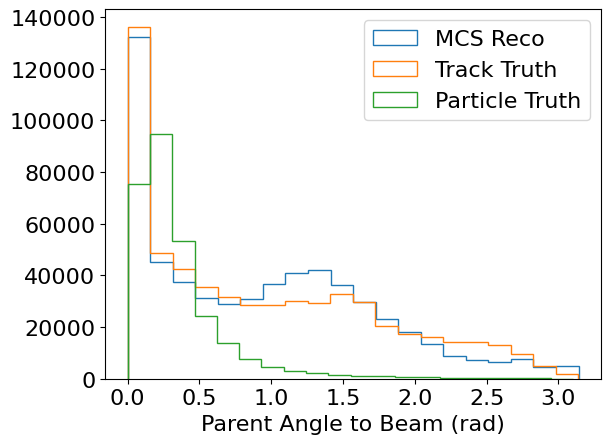

In [14]:
# add Snumi_angle to evtdf:

# NOTE: Here, "trueTrk" refers to true momentum of trunk/branch TRACK (not neccessarily the muon's)
#       "trueParticle" uses the muon particles' truth information.


evtdf["Snumi_angle_mcs"] = Sbeamangle(evtdf.trunk.trk, evtdf.branch.trk, BEAMDIR, 'mcs')
evtdf["Snumi_angle_trueTrk"] = Sbeamangle(evtdf.trunk.trk, evtdf.branch.trk, BEAMDIR, 'track_truth')
evtdf["Snumi_angle_trueParticle"] = true_Sbeamangle(evtdf.slc.truth.p0.genp, evtdf.slc.truth.p1.genp, BEAMDIR)

## Note: NaN for Cosmics b/c p0 and p1 don't mean anything.

## See difference for NuMI Angle:
mybins = 20
plt.hist(evtdf.Snumi_angle_mcs, bins=mybins, histtype='step', label='MCS Reco')
plt.hist(evtdf.Snumi_angle_trueTrk, bins=mybins, histtype='step', label='Track Truth')
plt.hist(evtdf.Snumi_angle_trueParticle, bins=mybins, histtype='step', label='Particle Truth')
plt.legend()
plt.xlabel("Parent Angle to Beam (rad)")
plt.show()

# Comments:
# smearage for tracks makes sense since the sample is dominate by neutrinos 
#   and their final state tracks wont neccessarily conserve momentum of incoming particle.
#   and cosmics are just weird - we don't expect them to peak at 0 here. 

In [15]:
# Add true opening angle to evtdf:

# here
evtdf["true_opening_angle"] = np.arccos( 
    (evtdf.slc.truth.p0.genp.x*evtdf.slc.truth.p1.genp.x + 
     evtdf.slc.truth.p0.genp.y*evtdf.slc.truth.p1.genp.y + 
     evtdf.slc.truth.p0.genp.z*evtdf.slc.truth.p1.genp.z
    )/(
        np.sqrt(evtdf.slc.truth.p0.genp.x**2 + evtdf.slc.truth.p0.genp.y**2 + evtdf.slc.truth.p0.genp.z**2) * 
        np.sqrt(evtdf.slc.truth.p1.genp.x**2 + evtdf.slc.truth.p1.genp.y**2 + evtdf.slc.truth.p1.genp.z**2)
    )
)

## Note: NaN for Cosmics b/c p0 and p1 don't mean anything.
#categories = make_categories(evtdf)
#print(evtdf[categories[-2]].true_opening_angle)

## Compare opening angle when using true momenta for tracks vs. for particles:
#myrange = (-10,10)
#mybins = 20
#plt.hist(np.concatenate((np.array(evtdf.slc.truth.p0.genp.x), np.array(evtdf.slc.truth.p1.genp.x))), histtype='step', range=myrange, bins=mybins, label='slc.truth.*.genp.x')
#plt.hist(np.concatenate((np.array(evtdf.trunk.trk.truth.p.genp.x), np.array(evtdf.branch.trk.truth.p.genp.x))), histtype='step', range=myrange, bins=mybins, label='*.trk.truth.p.genp.x')
#plt.legend()
#plt.show()


I want to know how many events each sample had to start.

Two equivalent ways of getting the original number of MC events generated in the sample are shown in the last two printed quantities in the for loop above. 

By far, the easier of the two is just shape of hdr dataframe, the the other is perhaps more explicit.

BUTTTTT!!! There is a mismatch for neutrinos :(

Gray says this can happen when a filter is applied, but this shouldn't be the case here. The mismatch is a mystery, but it is best to default to the shape of hdr df. Indeed, that is the more reasonable value here anyway.

In [16]:
categories = make_categories(evtdf, detailed_nu=False) # defined in unc_funcs
for c in range(len(categories)-1):
    cat =categories[c]
    print(cat.name, evtdf[cat].shape, hdrs[c].shape[0], np.array(hdrs[c].index.levels[0]).shape[0]*int(hdrs[c].ngenevt.iloc[0]), sep=', ')
    
print('')

## Use this for loop to verify that each of my samples have cosmic overlay.
#for df in evtdfs:
#    categories = make_categories(df, detailed_nu=False) # defined in unc_funcs
#    for cat in categories:
#        print(cat.name, df[cat].shape, sep=', ')
#    print('\n')

$M_S$ = 220, $\theta_S$ = 5e-05, (1804, 208), 11800, 11800
$M_S$ = 240, $\theta_S$ = 5e-05, (2832, 208), 12150, 12150
$M_S$ = 260, $\theta_S$ = 5e-05, (2481, 208), 9775, 9775
$M_S$ = 300, $\theta_S$ = 3e-05, (3825, 208), 11775, 11775
$M_S$ = 330, $\theta_S$ = 2e-05, (3981, 208), 11400, 11400
$M_{ALP}$ = 300, $c$ = 0.01, $fa$ = 100000.0, (14226, 208), 48400, 48400
$M_{ALP}$ = 350, $c$ = 0.01, $fa$ = 100000.0, (13057, 208), 40100, 40100
$M_{ALP}$ = 400, $c$ = 0.01, $fa$ = 100000.0, (16393, 208), 48500, 48500
$M_{ALP}$ = 450, $c$ = 0.01, $fa$ = 100000.0, (17334, 208), 50650, 50650
$M_{ALP}$ = 500, $c$ = 0.01, $fa$ = 100000.0, (16537, 208), 50500, 50500
$M_{ALP}$ = 600, $c$ = 0.01, $fa$ = 1000000.0, (20450, 208), 53800, 53800
$M_{ALP}$ = 650, $c$ = 0.01, $fa$ = 1000000.0, (18822, 208), 50100, 50100
$\nu$, (154355, 208), 2092439, 209760



### Check expected rate for each BSM model/benchmark and Make pie charts to see containment

My colors:

- scalars: blue
- ALPs: purple
- ALPs without suppression: green
- nu: orange
- cosmics: red


17.02
<class 'float'>


/tmp/ipykernel_11623/813331314.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[semi].shape[0]
/tmp/ipykernel_11623/813331314.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pc_exit.append( (df[full_exit].shape[0] + df[semi].shape[0])/(df[contained].shape[0] + df[full_exit].shape[0] + df[semi].shape[0]) )
/tmp/ipykernel_11623/813331314.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  exp = [round(sum(dff.scale)*100)/100. for dff in [df[contained], df[full_exit], df[semi]]]


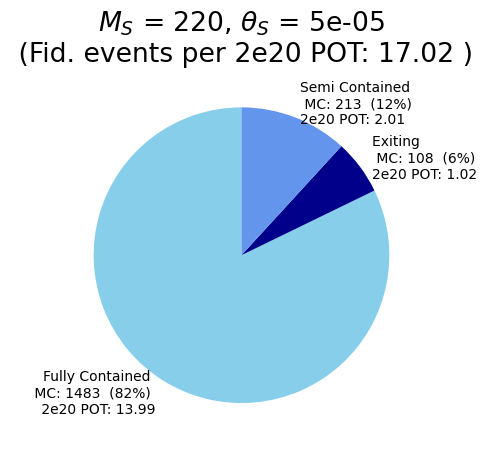

98.55
<class 'float'>


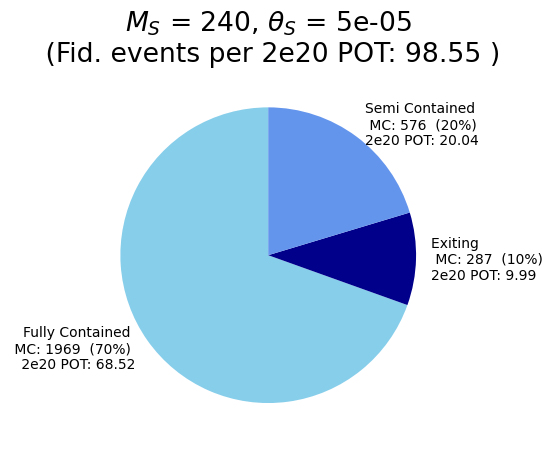

136.57
<class 'float'>


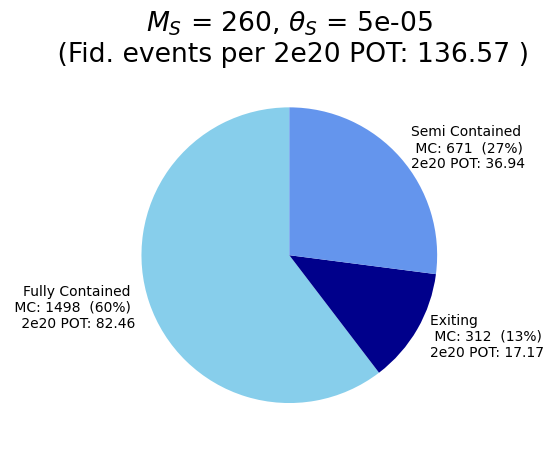

7.89
<class 'float'>


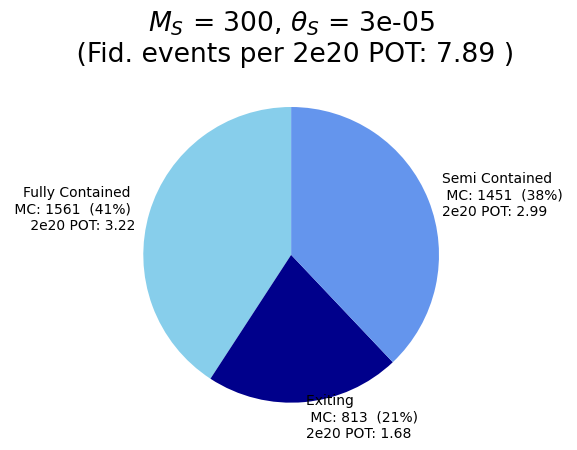

2.73
<class 'float'>


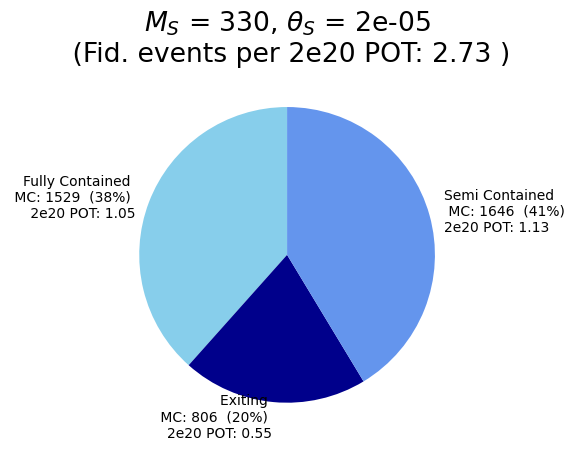

4.76
<class 'float'>


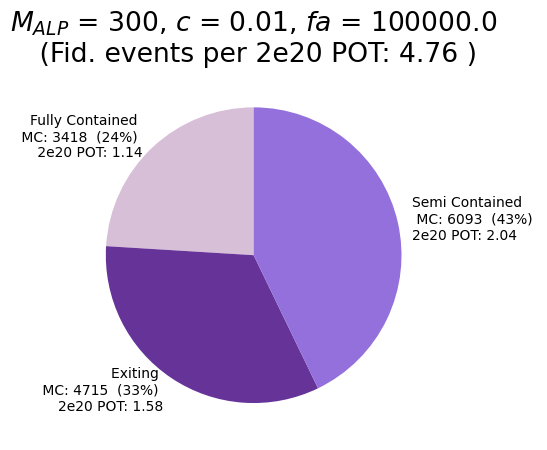

6.18
<class 'float'>


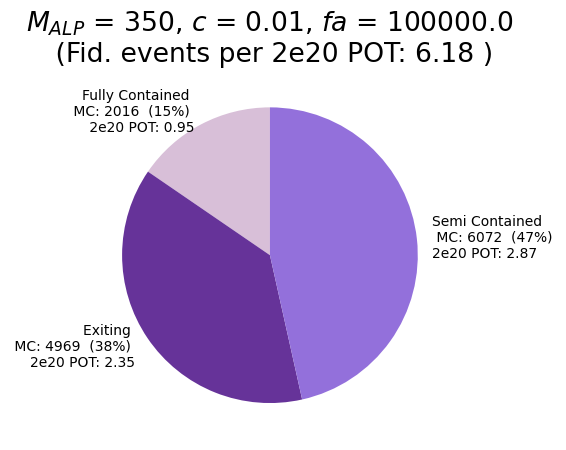

8.8
<class 'float'>


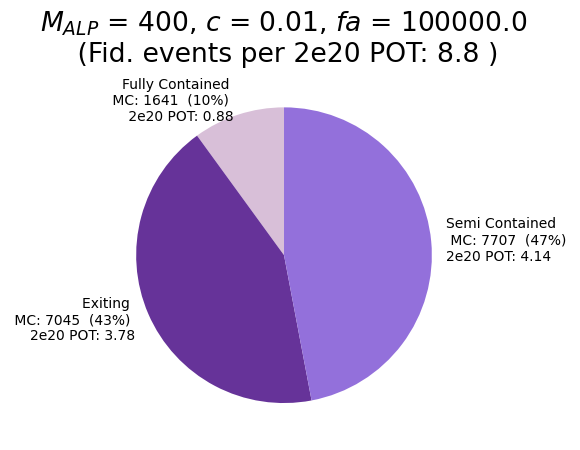

16.09
<class 'float'>


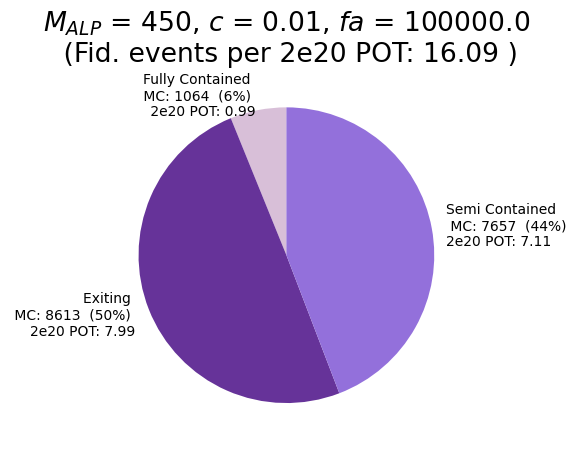

17.37
<class 'float'>


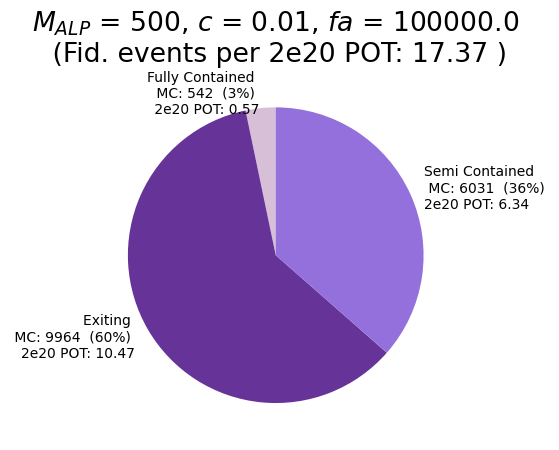

0.06
<class 'float'>


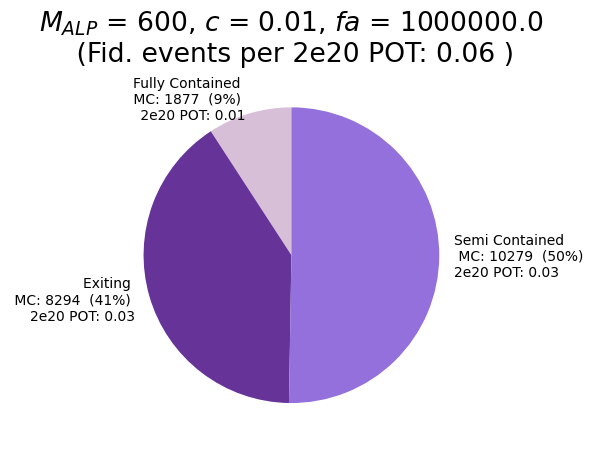

0.03
<class 'float'>


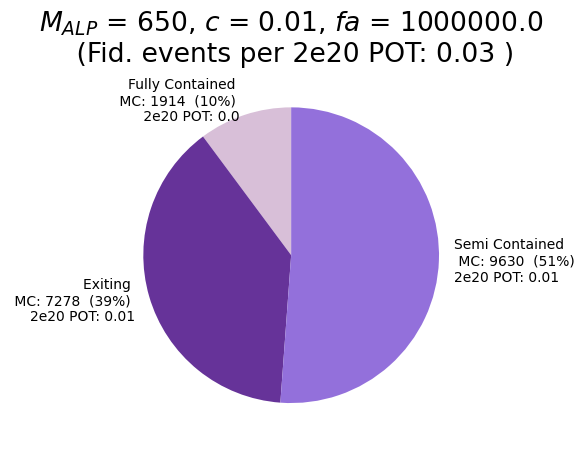

38079.3
<class 'float'>


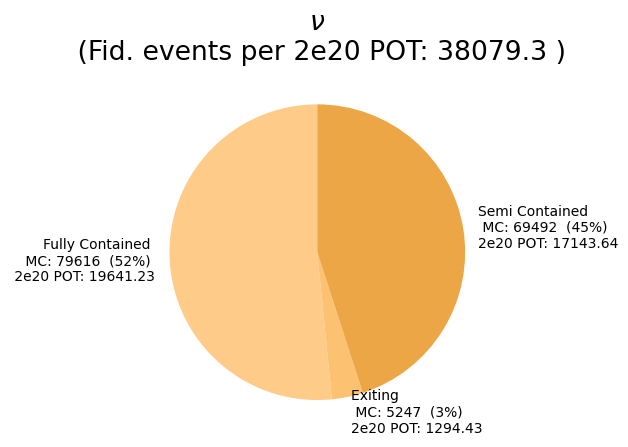

62623.07
<class 'float'>


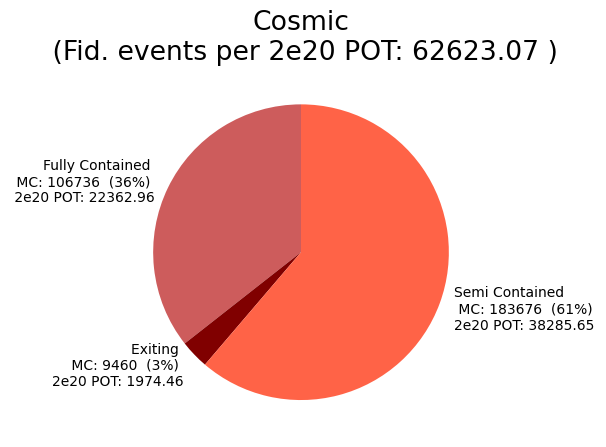

In [17]:
#categories = make_categories(evtdf) #, bsm=True
pc_exit = []
for c in categories:
#    TrkInFV(evtdf.trunk.trk.end) | TrkInFV(evtdf.branch.trk.end)
    df = evtdf[c]
    event_count = round(sum(df.scale)*100)/100.
    print(event_count)
    print(type(sum(df.scale)))
    tot = evtdf[c].shape[0]
    #print(tot)
    #continue
    contained = TrkInFV(df.trunk.trk.end) & TrkInFV(df.branch.trk.end)
    semi = (TrkInFV(evtdf.trunk.trk.end) & ~TrkInFV(evtdf.branch.trk.end)) | (~TrkInFV(evtdf.trunk.trk.end) & TrkInFV(evtdf.branch.trk.end))
    full_exit = ~TrkInFV(df.trunk.trk.end) & ~TrkInFV(df.branch.trk.end)
    narray = np.array([df[contained].shape[0],
                       df[full_exit].shape[0],
                       df[semi].shape[0]
                      ])
    pc_exit.append( (df[full_exit].shape[0] + df[semi].shape[0])/(df[contained].shape[0] + df[full_exit].shape[0] + df[semi].shape[0]) )
    pc = [round(100*n/tot) for n in narray]
    exp = [round(sum(dff.scale)*100)/100. for dff in [df[contained], df[full_exit], df[semi]]]
    mylabels = ["Fully Contained \n MC: %a  (%a%%) \n " % (narray[0], pc[0]) + POTSTR + ": %a" % exp[0], 
                "Exiting \n MC: %a  (%a%%) \n" % (narray[1], pc[1]) + POTSTR + ": %a" % exp[1],
                "Semi Contained \n MC: %a  (%a%%) \n" % (narray[2], pc[2]) + POTSTR + ": %a" % exp[2]
               ]
    
    if 'M_S' in c.name: mycolors = ["#87CEEB", "#00008B", "#6495ED"] # blue pallette (scalars)
    #elif 'axion' in c.name: mycolors = ["#7FFFD4", "#2F4F4F", "#008080"] # green pallette (heavy QCD axions)
    elif 'M_{ALP}' in c.name:
        if "no sup." not in c.name: mycolors = ["#D8BFD8", "#663399", "#9370DB"] # purple pallette (ALPs)
        else: mycolors = ["#7FFFD4", "#2F4F4F", "#008080"] # green pallette (ALPs without suppression)
        
    elif 'nu' in c.name: mycolors = oranges #["#FFDAB9", "#A0522D", "#F4A460"] # orange pallette (nu)
    else: mycolors = ["#CD5C5C", "#800000", "#FF6347"] # red pallette (cosmics)
    plt.pie(narray, labels = mylabels, colors = mycolors, startangle = 90, textprops={'fontsize': 10})
    plt.title(c.name + "\n (Fid. events per " + POTSTR + ": %a )" % event_count )
    if dosave: plt.savefig(savedir + "containment_%a.pdf" % c.name, bbox_inches = mpl.transforms.Bbox([[-1,0], [7,5]]))
    plt.show()

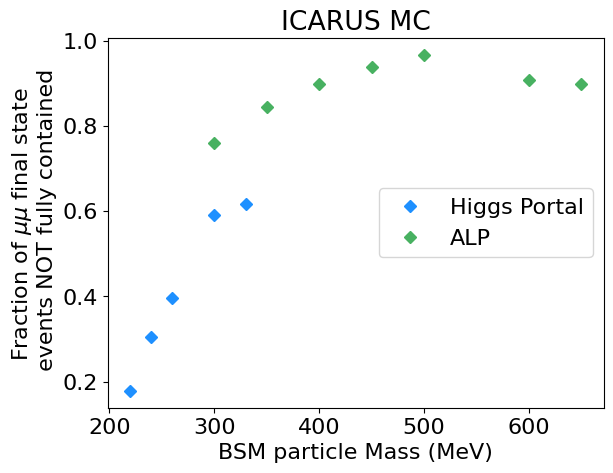

In [18]:
plt.plot((220, 240, 260, 300, 330), pc_exit[:5], 'D', color="#1E90FF", label='Higgs Portal')
plt.plot((300, 350, 400, 450, 500, 600, 650), pc_exit[5:-2], 'D', color="#48B161", label='ALP')
plt.title('ICARUS MC')
plt.ylabel('Fraction of $\\mu\\mu$ final state \n events NOT fully contained')
plt.xlabel('BSM particle Mass (MeV)')
plt.legend( loc='center right')
plt.show()


## Truth Distributions

As is (today is 11/20/23), the energy and decay length distributions are for exiting AND fully contained events. (MC dataframes are used, not evtdf, and defs not evtdf that has excluded contained events yet).

### Check the Energy Distributions for HPS benchmarks vs. ALP benchmarks.

$M_S$ = 220, $\theta_S$ = 5e-05
$M_S$ = 240, $\theta_S$ = 5e-05
$M_S$ = 260, $\theta_S$ = 5e-05
$M_S$ = 300, $\theta_S$ = 3e-05
$M_S$ = 330, $\theta_S$ = 2e-05
$M_{ALP}$ = 300, $c$ = 0.01, $fa$ = 100000.0
$M_{ALP}$ = 350, $c$ = 0.01, $fa$ = 100000.0
$M_{ALP}$ = 400, $c$ = 0.01, $fa$ = 100000.0
$M_{ALP}$ = 450, $c$ = 0.01, $fa$ = 100000.0
$M_{ALP}$ = 500, $c$ = 0.01, $fa$ = 1000000.0
$M_{ALP}$ = 600, $c$ = 0.01, $fa$ = 1000000.0
$M_{ALP}$ = 650, $c$ = 0.01, $fa$ = 1000000.0


/tmp/ipykernel_13752/1057502145.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


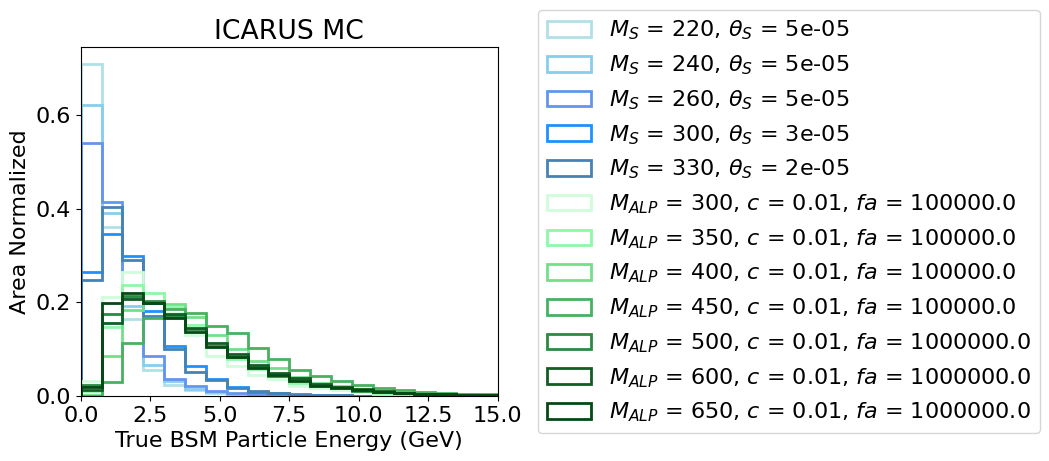

In [17]:
# NOTE:
# I do not need to worry about scaling here. The events are already deweighted. 
#    The scale factor is just for POT normalizing, but if I area normalize each dist. anyway, 
#    it doesn't matter if I scale for POT.

fig = plt.figure()
ax = plt.subplot(111)
scale = evtdf.scale.copy()
density=True
xrange=(0,15.) #(0,25.)
c=0
for df in higgs_mcdfs:
    print(categories[c].name)
    _ = plt.hist(df.E, bins=20, label=categories[c].name, color=categories[c].color,
                 histtype="step", linewidth=2, density=density, range=xrange) # , weights=scale[c], categories[c].name.split(',')[0]
    c = c+1
for df in alp_nosup_mcdfs:
    print(categories[c].name)
    _ = plt.hist(df.E, bins=20, label=categories[c].name, color=categories[c].color,
                 histtype="step", linewidth=2, density=density, range=xrange) # , weights=scale[c], categories[c].name.split(',')[0]
    c = c+1
plt.tight_layout()
plt.xlabel("True BSM Particle Energy (GeV)") # Total energy, not just kinetic.
plt.title("ICARUS MC")# \n All preselected events")
plt.xlim(xrange)
#plt.yscale('log')
if density:
    plt.ylabel("Area Normalized")
else:
    plt.ylabel("Candidates / %s" % POTSTR)
plt.tight_layout()    
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc = 'center left', bbox_to_anchor=(1.07, 0.5)) 
    # first entry above sets x position of legend, with 1 being at right edge of plot.
    # second entry above sets y position of legend, with 0.5 being centered. 
if dosave: plt.savefig(savedir + "BSM_Espectrum.pdf")
plt.show()


In [19]:
# - WIP - Figure out how to plot BSM energy spectra for only the uncontained sample:

bsm_mcdf_dict = {
    0: higgs_mcdfs[0],
    1: higgs_mcdfs[1],
    2: higgs_mcdfs[2],
    3: higgs_mcdfs[3],
    4: higgs_mcdfs[4],
    5: alp_nosup_mcdfs[0],
    6: alp_nosup_mcdfs[1],
    7: alp_nosup_mcdfs[2],
    8: alp_nosup_mcdfs[3],
    9: alp_nosup_mcdfs[4],
    10: alp_nosup_mcdfs[5],
    11: alp_nosup_mcdfs[6]
}

uncontained_only = True
mc_masks = {}
if uncontained_only:
    #when_uncontained = ~TrkInFV(evtdf.trunk.trk.end) | ~TrkInFV(evtdf.branch.trk.end)
    #evtdf_unc = evtdf[when_uncontained]
    for samp in np.unique(np.array(evtdf_unc.index.get_level_values(0))):
        mcdf = bsm_mcdf_dict[samp]
        mc_masks[samp] = 
    #print(evtdf.shape)
    #print(evtdf[when_uncontained].shape)
    
#when_uncontained = ~TrkInFV(evtdf.trunk.trk.end) | ~TrkInFV(evtdf.branch.trk.end)
print(evtdf.shape)
print(evtdf[when_uncontained].shape)

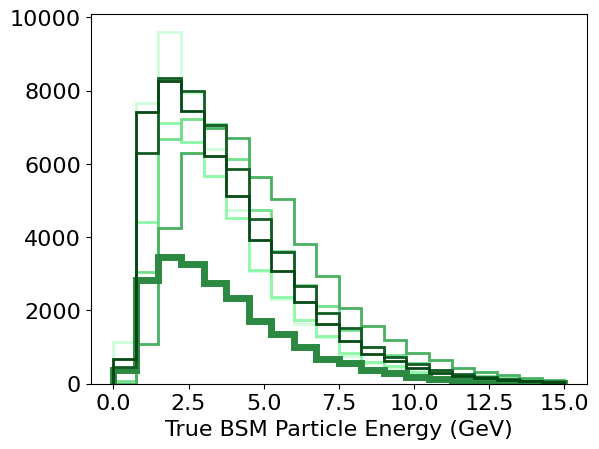

In [22]:
density = False
#for i in range(5,7):
#    plt.hist(alp_nosup_mcdfs[i].E, bins=20, label=categories[i+5].name.split(',')[0], color=oranges[i-4],
#                     histtype="step", linewidth=2, density=density, range=(0,15)) 
for i in range(len(alp_nosup_mcdfs)):#(5):
    if i==4 or i==7:
        linewidth=5
    else:
        linewidth=2
    plt.hist(alp_nosup_mcdfs[i].E, bins=20, label=categories[i+5].name.split(',')[0], color=categories[i+5].color,
                     histtype="step", linewidth=linewidth, density=density, range=(0,15)) 
#plt.hist(alp_nosup_mcdfs[4].E, bins=20, label=categories[9].name.split(',')[0], color='gold',
#                 histtype="step", linewidth=2, density=density, range=xrange) 
#plt.hist(alp_nosup_mcdfs[5].E, bins=20, label=categories[10].name.split(',')[0], color=categories[10].color,
#                 histtype="step", linewidth=2, density=density, range=xrange)
#plt.yscale('log')
#plt.legend()
plt.xlabel("True BSM Particle Energy (GeV)") # Total energy, not just kinetic.
plt.show()

#for i in range(len(alp_nosup_mcdfs)):#(5,8):
#    if i==4 | i==7:
#        linewidth=5
#    else:
#        linewidth=2
#    plt.hist(alp_nosup_mcdfs[i].E, bins=20, label=categories[i+5].name.split(',')[0], color=oranges[i-4],
#                     histtype="step", linewidth=linewidth, density=density, range=(0,15)) 
#plt.legend()
#plt.xlabel("True BSM Particle Energy (GeV)") # Total energy, not just kinetic.
#plt.show()

/tmp/ipykernel_26824/3943270909.py:27: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


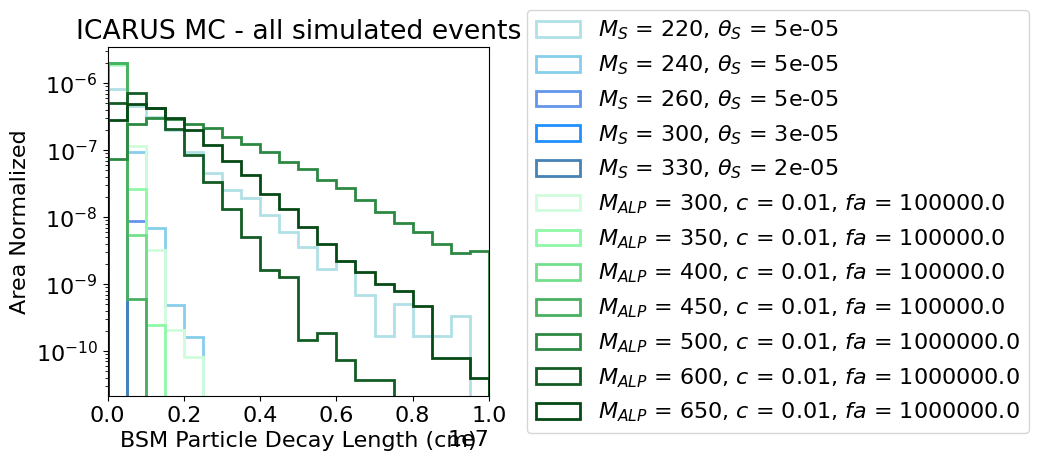

In [23]:
# decay lengths

fig = plt.figure()
ax = plt.subplot(111)
scale = evtdf.scale.copy()
density=True
xrange=(0, 10**7)
c=0
for df in higgs_mcdfs:
    _ = plt.hist(df.decay_length, bins=20, label=categories[c].name, color=categories[c].color,
                 histtype="step", linewidth=2, density=density, range=xrange) # , weights=scale[c], categories[c].name.split(',')[0]
    c = c+1
for df in alp_nosup_mcdfs:
    _ = plt.hist(df.decay_length, bins=20, label=categories[c].name, color=categories[c].color,
                 histtype="step", linewidth=2, density=density, range=xrange) # , weights=scale[c], categories[c].name.split(',')[0]
    c = c+1
plt.tight_layout()
plt.xlabel("BSM Particle Decay Length (cm)") # Total energy, not just kinetic.
plt.title("ICARUS MC - all simulated events")
plt.xlim(xrange)
plt.yscale('log')
#plt.xscale('log')
if density:
    plt.ylabel("Area Normalized")
else:
    plt.ylabel("Candidates / %s" % POTSTR)
plt.tight_layout()    
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc = 'center left', bbox_to_anchor=(1.07, 0.5)) 
    # first entry above sets x position of legend, with 1 being at right edge of plot.
    # second entry above sets y position of legend, with 0.5 being centered. 
if dosave: plt.savefig(savedir + "BSM_decay_length.pdf")
plt.show()

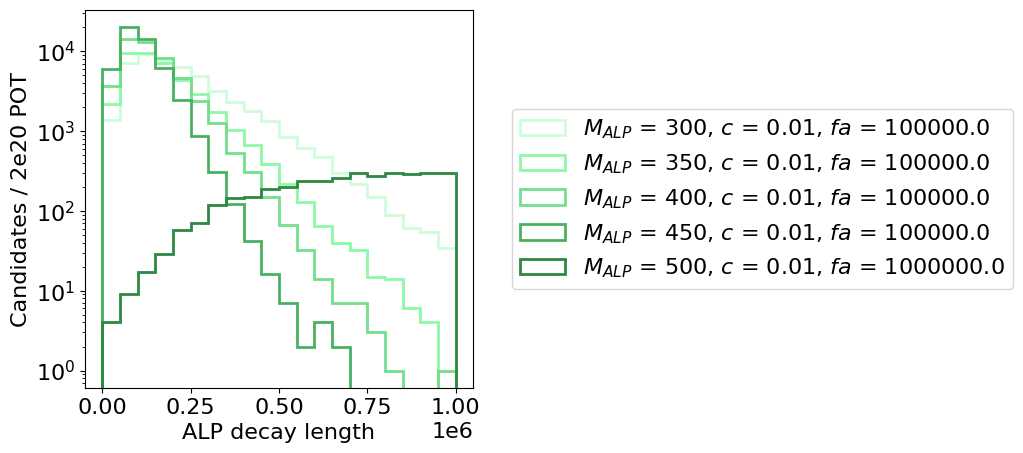

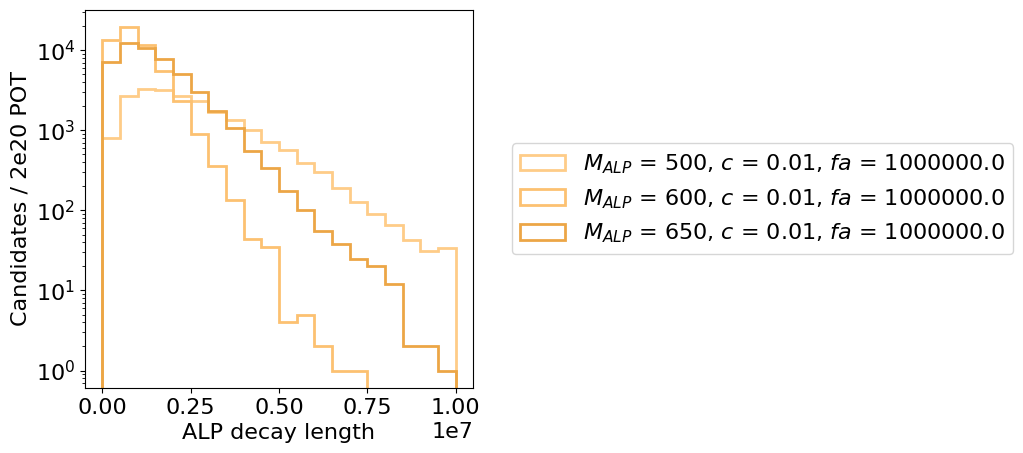

In [24]:
density = False

fig = plt.figure()
ax = plt.subplot(111)
xrange=(0, 10**6)
#for i in range(5,7):
#    plt.hist(alp_nosup_mcdfs[i].E, bins=20, label=categories[i+5].name.split(',')[0], color=oranges[i-4],
#                     histtype="step", linewidth=2, density=density, range=(0,15)) 
for i in range(5):
    plt.hist(alp_nosup_mcdfs[i].decay_length, bins=20, label=categories[i+5].name, color=categories[i+5].color,
                     histtype="step", linewidth=2, density=density, range=xrange) 
#plt.hist(alp_nosup_mcdfs[4].E, bins=20, label=categories[9].name.split(',')[0], color='gold',
#                 histtype="step", linewidth=2, density=density, range=xrange) 
#plt.hist(alp_nosup_mcdfs[5].E, bins=20, label=categories[10].name.split(',')[0], color=categories[10].color,
#                 histtype="step", linewidth=2, density=density, range=xrange)
if density:
    plt.ylabel("Area Normalized")
else:
    plt.ylabel("Candidates / %s" % POTSTR)
plt.tight_layout()
plt.yscale('log')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc = 'center left', bbox_to_anchor=(1.07, 0.5)) 
#plt.legend()
plt.xlabel('ALP decay length')
plt.show()

fig = plt.figure()
ax = plt.subplot(111)
xrange=(0, 10**7)
for i in range(4,7):
    plt.hist(alp_nosup_mcdfs[i].decay_length, bins=20, label=categories[i+5].name, color=oranges[i-4],
                     histtype="step", linewidth=2, density=density, range=xrange) 
if density:
    plt.ylabel("Area Normalized")
else:
    plt.ylabel("Candidates / %s" % POTSTR)
plt.tight_layout()
plt.yscale('log')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc = 'center left', bbox_to_anchor=(1.07, 0.5)) 
#plt.legend()
plt.xlabel('ALP decay length')
plt.show()

In [21]:
for col in higgs_mcdfs[0].columns:
    print(col)

higgs_mcdfs[0]

('E', '')
('M', '')
('start', 'x')
('start', 'y')
('start', 'z')
('enter', 'x')
('enter', 'y')
('enter', 'z')
('exit', 'x')
('exit', 'y')
('exit', 'z')
('decay_length', '')
('C1', '')
('C2', '')
('C3', '')
('C4', '')
('C5', '')


E     M         start               \
                                                              x            y   
__ntuple entry rec.mc.prtl..index                                              
22       0     0                   0.258468  0.22  -3318.949951 -7608.777832   
         1     0                   1.259852  0.22 -30705.513672 -3499.996582   
         2     0                   1.470162  0.22 -30123.439453 -3493.172852   
         3     0                   4.290741  0.22 -31277.419922 -3309.162842   
         4     0                   1.026416  0.22 -31432.958984 -3361.683838   
...                                     ...   ...           ...          ...   
470      20    0                   0.276129  0.22  -3245.107422 -7629.313477   
         21    0                   1.840076  0.22 -31042.656250 -3358.298096   
         22    0                   0.225718  0.22 -21376.675781 -4832.483398   
         23    0                   0.862141  0.22 -30556.671875 -3483.138672   
         24    0                   1.209444  0.22 -31319.041016 -3389.484375   

                                                      enter              \
                                              z           x           y   
__ntuple entry rec.mc.prtl..index                                         
22       0     0                   -6788.357910  137.788696 -191.860001   
         1     0                  -71573.234375 -368.489990   23.958570   
         2     0                  -70117.875000 -368.489990   -6.904637   
         3     0                  -72765.851562 -368.489990  135.461472   
         4     0                  -72999.015625  -47.745369   31.198175   
...                                         ...         ...         ...   
470      20    0                   -6644.456055 -257.587891 -191.860001   
         21    0                  -72414.960938 -368.489990   89.016953   
         22    0                  -49300.347656 -143.442368 -108.865997   
         23    0                  -71095.789062 -368.489990   40.552921   
         24    0                  -72995.945312 -368.489990 -150.577789   

                                                     exit              \
                                            z           x           y   
__ntuple entry rec.mc.prtl..index                                       
22       0     0                   574.917114  292.725159  140.577881   
         1     0                  -808.147461  365.915863  109.267319   
         2     0                  -111.590813   63.573204   43.718475   
         3     0                   576.862793 -283.258850  144.960007   
         4     0                  -904.950623  368.489990   76.195076   
...                                       ...         ...         ...   
470      20    0                  -773.531677 -122.292068  144.960007   
         21    0                  -425.586212  129.290527  144.960007   
         22    0                  -904.950623  368.489990    5.020223   
         23    0                  -589.105225  271.205811  115.220909   
         24    0                   -14.287449   21.346655 -109.782249   

                                               decay_length       C1  \
                                            z                          
__ntuple entry rec.mc.prtl..index                                      
22       0     0                   904.950623  1.401306e+05  0.00005   
         1     0                   904.950623  1.281303e+06  0.00005   
         2     0                   904.950623  1.501427e+06  0.00005   
         3     0                   779.104736  4.426063e+06  0.00005   
         4     0                    51.171516  1.035543e+06  0.00005   
...                                       ...           ...      ...   
470      20    0                  -507.655121  1.723647e+05  0.00005   
         21    0                   742.657776  1.886974e+06  0.00005   
         22    0                   261.860413  5.214636

## Signal and bg categories - here I am imposing that one or both of the muon candidates are exiting

In [19]:
when_uncontained = ~TrkInFV(evtdf.trunk.trk.end) | ~TrkInFV(evtdf.branch.trk.end)
evtdf = evtdf[when_uncontained]
print(evtdf.shape)


(379105, 208)


In [20]:
categories = make_categories(evtdf, detailed_nu=True)
for c in categories:
    print(c.name, evtdf[c].shape, sum(evtdf[c].scale), sep=', ')
    

$M_S$ = 220, $\theta_S$ = 5e-05, (321, 208), 3.0284541182681437
$M_S$ = 240, $\theta_S$ = 5e-05, (863, 208), 30.031044942123742
$M_S$ = 260, $\theta_S$ = 5e-05, (983, 208), 54.111928003915864
$M_S$ = 300, $\theta_S$ = 3e-05, (2264, 208), 4.671094096660904
$M_S$ = 330, $\theta_S$ = 2e-05, (2452, 208), 1.6786081721342265
$M_{ALP}$ = 300, $c$ = 0.01, $fa$ = 100000.0, (10808, 208), 3.617838412158542
$M_{ALP}$ = 350, $c$ = 0.01, $fa$ = 100000.0, (11041, 208), 5.2262431221041314
$M_{ALP}$ = 400, $c$ = 0.01, $fa$ = 100000.0, (14752, 208), 7.915959827313052
$M_{ALP}$ = 450, $c$ = 0.01, $fa$ = 100000.0, (16270, 208), 15.098913605699904
$M_{ALP}$ = 500, $c$ = 0.01, $fa$ = 100000.0, (15995, 208), 16.8027935860298
$M_{ALP}$ = 600, $c$ = 0.01, $fa$ = 1000000.0, (18573, 208), 0.05601198894602815
$M_{ALP}$ = 650, $c$ = 0.01, $fa$ = 1000000.0, (16908, 208), 0.025594729860016603
$\nu_\mu$ CC COH, (591, 208), 145.7994060764513
$\nu_\mu$ CC n$\pi$0p, (7724, 208), 1905.5069586035147
$\nu_\mu$ CC n$\pi$np,

In [18]:
print(evtdf.shape)
print(evtdf[SlcInFV(evtdf.slc.vertex)].shape)

(379105, 208)
(379105, 208)


In [101]:
for c in evtdf.columns: print(c)

('slc', 'is_clear_cosmic', '', '', '', '')
('slc', 'vertex', 'x', '', '', '')
('slc', 'vertex', 'y', '', '', '')
('slc', 'vertex', 'z', '', '', '')
('slc', 'self', '', '', '', '')
('slc', 'tmatch', 'eff', '', '', '')
('slc', 'tmatch', 'pur', '', '', '')
('slc', 'tmatch', 'idx', '', '', '')
('slc', 'producer', '', '', '', '')
('slc', 'nuid', 'crlongtrkdiry', '', '', '')
('slc', 'truth', 'E', '', '', '')
('slc', 'truth', 'bjorkenX', '', '', '')
('slc', 'truth', 'inelasticityY', '', '', '')
('slc', 'truth', 'Q2', '', '', '')
('slc', 'truth', 'w', '', '', '')
('slc', 'truth', 't', '', '', '')
('slc', 'truth', 'position', 'x', '', '')
('slc', 'truth', 'position', 'y', '', '')
('slc', 'truth', 'position', 'z', '', '')
('slc', 'truth', 'pdg', '', '', '')
('slc', 'truth', 'iscc', '', '', '')
('slc', 'truth', 'genie_mode', '', '', '')
('slc', 'truth', 'max_proton_ke', '', '', '')
('slc', 'truth', 'nn', '', '', '')
('slc', 'truth', 'np', '', '', '')
('slc', 'truth', 'npi', '', '', '')
('slc', 't

In [21]:
# ALSO SPLIT INTO SUBCATEGORIES

# both are uncontained:

when_both_unc = ~TrkInFV(evtdf.trunk.trk.end) & ~TrkInFV(evtdf.branch.trk.end)
evtdf_both_unc = evtdf[when_both_unc]
evtdf_semi_con = evtdf[~when_both_unc]
#print(evtdf_both_unc.shape)

print("")
print('all higgs at first mass point: ', evtdf[make_categories(evtdf)[0]].shape[0])
print('both uncontained (higgs at first mass point): ', evtdf_both_unc[make_categories(evtdf_both_unc)[0]].shape[0])
print('semi contained (higgs at first mass point): ', evtdf_semi_con[make_categories(evtdf_semi_con)[0]].shape[0])


all higgs at first mass point:  321
both uncontained (higgs at first mass point):  108
semi contained (higgs at first mass point):  213


# Define Plotting Functions

### LLP angle wrt NuMI beam

Plot in uncontained_mus.ipynb shows that mcs track momentum determination is best thing to use to get this angle for uncontained muons.

Here, see how that does compared to background.

In [44]:
def plot_scalar_numi_angle(df, bins = 25, vline=None, bsm=False, detailed_nu=False, MC=False,
                           density=True, POTSTR=POTSTR, sample_description="", determination="mcs"):
    fig = plt.figure()
    ax = plt.subplot(111)
    
    if determination == "truth":
        var = df.Snumi_angle_trueParticle
        myrange=(0,np.pi)
        #plt.title("ICARUS MC"+sample_description)#+" \n (Truth)")
        plt.xlabel("True $\\theta_{NuMI}$ (rad)")
    else:
        var = df.Snumi_angle_mcs
        myrange=(0,0.5)
        #plt.title("ICARUS MC"+sample_description+" \n (using MCS for reco $p_\\mu$)")
        plt.xlabel("$\\theta_{NuMI}$ (rad)")
    
    ##var = df.Snumi_angle_true
    scale = df.scale.copy()
    var[np.isnan(var) | (var < 0)] = -10
    
    if bsm == True:
        categories = make_categories(df, bsm=True)
    elif detailed_nu == True:
        categories = make_categories(df, detailed_nu=True)
    else:
        categories = make_categories(df)
    for c in categories:
        if (determination=="truth") & (c.name == 'Cosmic'):
            continue
        if MC==True:
            _ = plt.hist(var[c], bins=bins, label=c.name, color=c.color,
                     histtype="step", linewidth=2, range=myrange)
        else:
            _ = plt.hist(var[c], weights=scale[c], bins=bins, label=c.name, color=c.color,
                     histtype="step", linewidth=2, density=density, range=myrange)
    
    ##plt.legend()
    #plt.title("ICARUS MC"+sample_description+" \n (using MCS for reco $p_\\mu$)")
    if MC:
        plt.ylabel("MC Events")
    else:
        if density:
            plt.ylabel("Area Normalized")
        else:
            plt.ylabel("Candidates / %s" % POTSTR)
    plt.yscale("log")
    if (determination!="truth") & (vline is not None):
        plt.axvline([vline], linestyle=":", color="r", linewidth=2)
    #plt.axvline([NuMI_angle_thresh], linestyle=":", color="r", linewidth=2)
    #plt.text(0.6, 0.4, label, transform=plt.gca().transAxes, fontsize=18)
    plt.tight_layout()
    plt.xlim(myrange)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    #ax.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))

    #if dosave: plt.savefig(savedir + "max_shw_len_M%i.pdf" % HMASS)
    plt.show()
    


/tmp/ipykernel_13431/804150766.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var[np.isnan(var) | (var < 0)] = -10


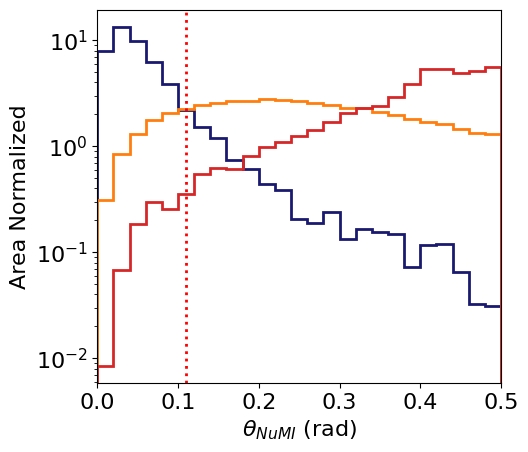

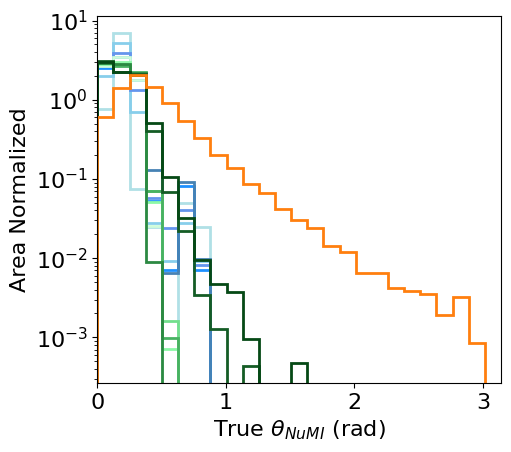

In [45]:
plot_scalar_numi_angle(evtdf, vline=NuMI_angle_thresh, density=True, bsm=True,
                       sample_description="\n all that pass preselection") # detailed_nu=True, bsm=True, MC=True,
#plot_scalar_numi_angle(evtdf_both_unc, vline=NuMI_angle_thresh, 
#                       sample_description="\n FULLY EXITING \n all that pass preselection")
#plot_scalar_numi_angle(evtdf_semi_con, vline=NuMI_angle_thresh, 
#                       sample_description="\n SEMI CONTAINED \n all that pass preselection")
plot_scalar_numi_angle(evtdf, vline=NuMI_angle_thresh,
                       sample_description="\n all that pass preselection", determination="truth")

### Opening angle between trunk and branch

In [46]:
def plot_trk_open_angle(df, bins=np.linspace(0, np.pi, 21), vline = None, bsm=False, detailed_nu=False, MC=False,
                        density=True, POTSTR=POTSTR, sample_description="", determination="reco"):    
    fig = plt.figure()
    ax = plt.subplot(111)
    
    if determination=="truth":
        var = df.true_opening_angle #* 180 / np.pi
        plt.xlabel("True $\\theta_{\mu\mu}$ (rad)")
    else:
        var = np.arccos(dotdf(df.trunk.trk.dir, df.branch.trk.dir)) #* 180 / np.pi
        plt.xlabel("$\\theta_{\mu\mu}$ (rad)")
    scale = df.scale.copy()

    if bsm == True:
        categories = make_categories(df, bsm=True)
    elif detailed_nu == True:
        categories = make_categories(df, detailed_nu=True)
    else:
        categories = make_categories(df)
    for c in categories:
        if (determination=="truth") & (c.name == 'Cosmic'):
            continue
        if MC:
            _ = plt.hist(var[c], bins=bins, label=c.name, color=c.color,
                     histtype="step", linewidth=2, range=myrange)
        else:
            _ = plt.hist(var[c], weights=scale[c], bins=bins, label=c.name, color=c.color,
                     histtype="step", linewidth=2, density=density)
    #plt.legend()
    plt.tight_layout()
    plt.xlim((0,np.pi))
    #plt.title("ICARUS MC"+sample_description)
    if MC:
        plt.ylabel("MC Events")
    else:
        if density:
            plt.ylabel("Area Normalized")
        else:
            plt.ylabel("Candidates / %s" % POTSTR)
    plt.tight_layout()
    if (determination!="truth") & (vline is not None):
        plt.axvline([vline], linestyle=":", color="r", linewidth=2) 
        
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))
    
    #if dosave: plt.savefig(savedir + "trklen.pdf")
    plt.show()

/tmp/ipykernel_13431/966516201.py:40: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


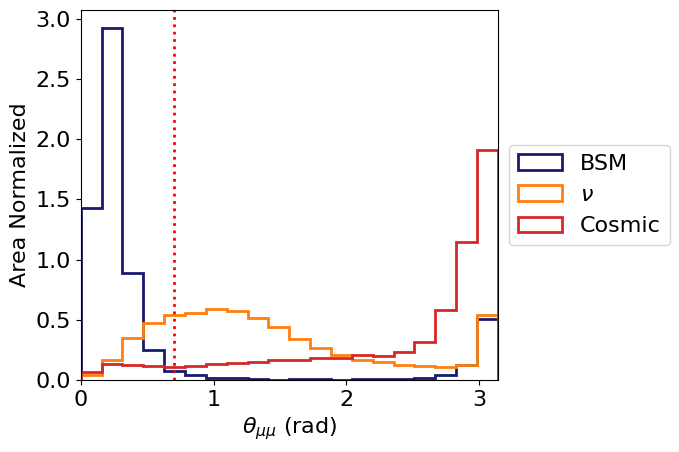

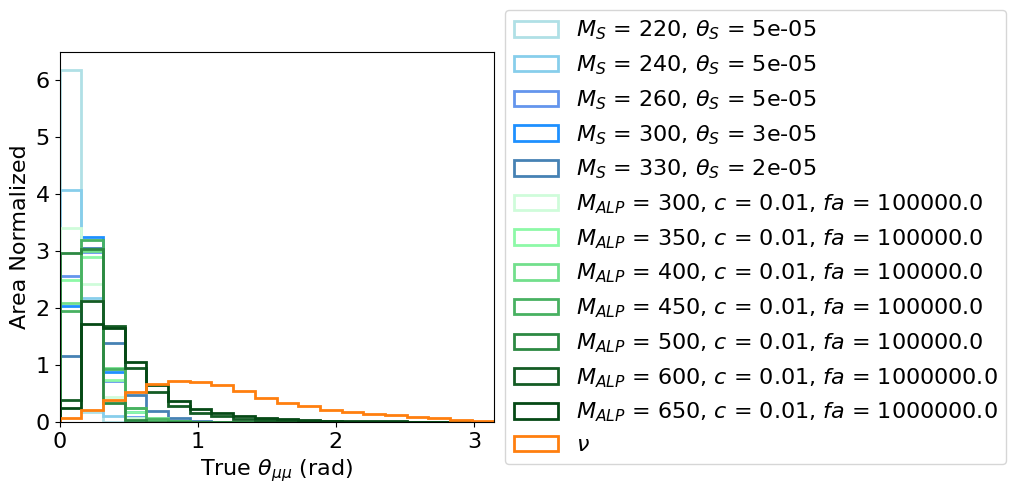

In [47]:
plot_trk_open_angle(evtdf, sample_description="\n all that pass preselection", 
                    vline=open_angle_thresh, bsm=True)
#plot_trk_open_angle(evtdf_both_unc, sample_description="\n FULLY EXITING \n all that pass preselection", 
#                    vline=open_angle_thresh)
#plot_trk_open_angle(evtdf_semi_con, sample_description="\n SEMI CONTAINED \n all that pass preselection", 
#                    vline=open_angle_thresh)
plot_trk_open_angle(evtdf, sample_description="\n all that pass preselection",
                    vline=open_angle_thresh, determination="truth") # always NaN for cosmics

### Check track length - not up to date with other plotting functions.

In [80]:
def plot_trk_len(df, which_track, bins=35, myrange=(0, 300), density=True, 
                 POTSTR=POTSTR, sample_description="", vline=None, bsm=False, detailed_nu=False):
    if which_track == "Longer":
        var = df.longer_track_length
    if which_track == "Shorter":
        var = df.shorter_track_length
        
    fig = plt.figure()
    ax = plt.subplot(111)    
        
    scale = df.scale.copy()
    if bsm == True:
        categories = make_categories(df, bsm=True)
    elif detailed_nu == True:
        categories = make_categories(df, detailed_nu=True)
    else:
        categories = make_categories(df)
    for c in categories:
        _ = plt.hist(var[c], weights=scale[c], bins=bins, label=c.name, color=c.color,
                     histtype="step", linewidth=2, density=density, range=myrange)
    #plt.legend()
    plt.tight_layout()
    #plt.xlabel(xlabel)
    plt.xlabel(which_track + " Track Length (cm)")
    plt.title("ICARUS MC"+sample_description)
    if density:
        plt.ylabel("Area Normalized")
    else:
        plt.ylabel("Candidates / %s" % POTSTR)
    plt.xlim(myrange)
    plt.tight_layout()
    if vline is not None:
        plt.axvline([vline], linestyle=":", color="r", linewidth=2)
        
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    #ax.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))
        
    if dosave: plt.savefig(savedir + "trklen.pdf")
    plt.show()

/tmp/ipykernel_13431/1232455691.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


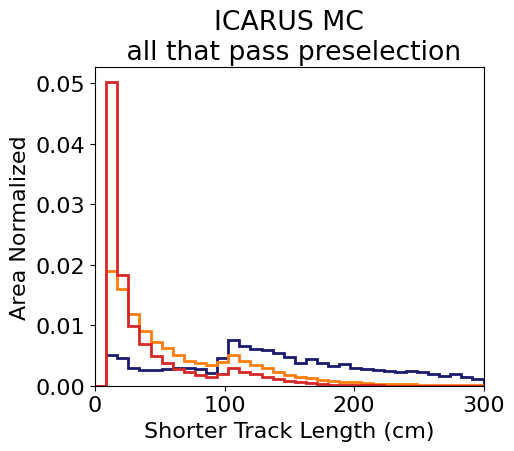

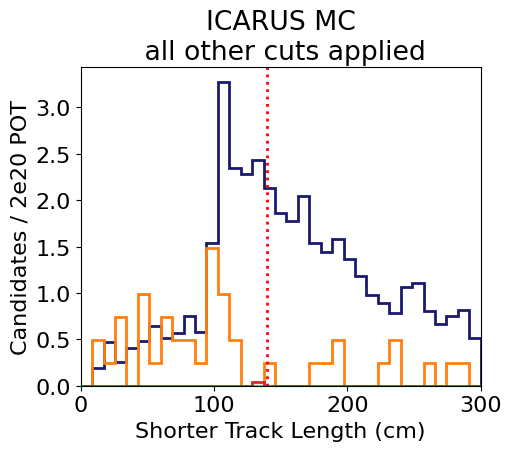

In [88]:
#plot_trk_len(evtdf, "Longer", sample_description="\n all that pass preselection", vline=trk_len_thresh)
plot_trk_len(evtdf, "Shorter", sample_description="\n all that pass preselection", density=True, bsm=True)#, vline=trk_len_thresh)
plot_trk_len(final_df, "Shorter", sample_description="\n all other cuts applied", density=False, bsm=True, vline=trk_len_thresh)

##plot_trk_len(evtdf_both_unc, "Longer", sample_description="\n FULLY EXITING \n all that pass preselection", vline=trk_len_thresh)
#plot_trk_len(evtdf_both_unc, "Shorter", sample_description="\n FULLY EXITING \n all that pass preselection")#, vline=trk_len_thresh)

##plot_trk_len(evtdf_semi_con, "Longer", sample_description="\n SEMI CONTAINED \n all that pass preselection", vline=trk_len_thresh)
#plot_trk_len(evtdf_semi_con, "Shorter", sample_description="\n SEMI CONTAINED \n all that pass preselection")#, vline=trk_len_thresh)

### Stub dQ/dx (various conditions that go into deterimination of 'hasstub')

In [72]:
def plot_stub_dqdx(df, bins=np.linspace(0, 8e5, 21), vline=None, bsm=False, detailed_nu=False, MC=False,
                  density=True, POTSTR=POTSTR, sample_description=""):
    
    vars = [ df.stub.l0_5cm.dqdx, df.stub.l1cm.dqdx, df.stub.l2cm.dqdx, df.stub.l3cm.dqdx ]
    var_labels = ['l0_5cm dqdx', 'l1cm dqdx', 'l2cm dqdx', 'l3cm dqdx']
    var_better_labels = [' (len < 0.5cm)', ' (0.5cm < len < 1cm)', ' (1cm < len < 2cm)', ' (2cm < len < 3cm)']
    
    scale = df.scale.copy()
    #when = SlcInFV(df.slc.vertex) & muselect # & (~is_higgs | ((evtdf.trunk.truth.p.genE > 0.5) & (evtdf.branch.truth.p.genE > 0.5)))
    
    if bsm == True:
        categories = make_categories(df, bsm=True)
    elif detailed_nu == True:
        categories = make_categories(df, detailed_nu=True)
    else:
        categories = make_categories(df)
    
    for v in range(len(vars)):
        
        fig = plt.figure()
        ax = plt.subplot(111)
        
        print('Var: ', var_labels[v], var_better_labels[v])
        for c in categories:
            if c.name == '$M_{ALP}$ = 500, $c$ = 0.01, $fa$ = 1000000.0': 
                thick = 5
            else: thick = 2
            if ('$\\nu$' in c.name) | (c.name == 'Cosmic'):
                continue
            isok = ~np.isnan(np.array(vars[v][c]))
            print('Number of entries in %a with a dqdx value != NaN: ' % c.name, 
                  len(vars[v][c][isok]),'/',len(vars[v][c]) )
            if MC:
                _ = plt.hist(vars[v][c], bins=bins, label=c.name, color=c.color,
                     histtype="step", linewidth=thick)
            else:
                _ = plt.hist(vars[v][c], weights=scale[c], bins=bins, label=c.name, color=c.color,
                     histtype="step", density=density, linewidth=thick)
            
        ##plt.legend()
        if vline is not None:
            plt.axvline([vline[v]], linestyle=":", color="r", linewidth=2)

        plt.tight_layout()
        plt.xlabel("Stub dQ/dx [#elec/cm]" + var_better_labels[v]) #(1cm < len < 2cm)")
        #plt.title("ICARUS MC"+sample_description)
        plt.xlim((0, 8e5))

        #plt.text(0.625, 0.35, label, transform=plt.gca().transAxes, fontsize=18)
        if MC:
            plt.ylabel("MC Events")
        else:
            if density:
                plt.ylabel("Area Normalized")
            else:
                plt.ylabel("Candidates / %s" % POTSTR)

        plt.tight_layout()
        
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))
    
        #if dosave: plt.savefig(savedir + "stub_1cm_2cm_dqdx.pdf")
        plt.show()


Var:  l0_5cm dqdx  (len < 0.5cm)
Number of entries in '$M_S$ = 220, $\\theta_S$ = 5e-05' with a dqdx value != NaN:  40 / 321
Number of entries in '$M_S$ = 240, $\\theta_S$ = 5e-05' with a dqdx value != NaN:  125 / 863
Number of entries in '$M_S$ = 260, $\\theta_S$ = 5e-05' with a dqdx value != NaN:  146 / 983
Number of entries in '$M_S$ = 300, $\\theta_S$ = 3e-05' with a dqdx value != NaN:  329 / 2264
Number of entries in '$M_S$ = 330, $\\theta_S$ = 2e-05' with a dqdx value != NaN:  362 / 2452
Number of entries in '$M_{ALP}$ = 300, $c$ = 0.01, $fa$ = 100000.0' with a dqdx value != NaN:  1482 / 10808
Number of entries in '$M_{ALP}$ = 350, $c$ = 0.01, $fa$ = 100000.0' with a dqdx value != NaN:  1543 / 11041
Number of entries in '$M_{ALP}$ = 400, $c$ = 0.01, $fa$ = 100000.0' with a dqdx value != NaN:  2027 / 14752
Number of entries in '$M_{ALP}$ = 450, $c$ = 0.01, $fa$ = 100000.0' with a dqdx value != NaN:  2294 / 16270
Number of entries in '$M_{ALP}$ = 500, $c$ = 0.01, $fa$ = 1000000.0' 

/tmp/ipykernel_13752/286540751.py:58: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


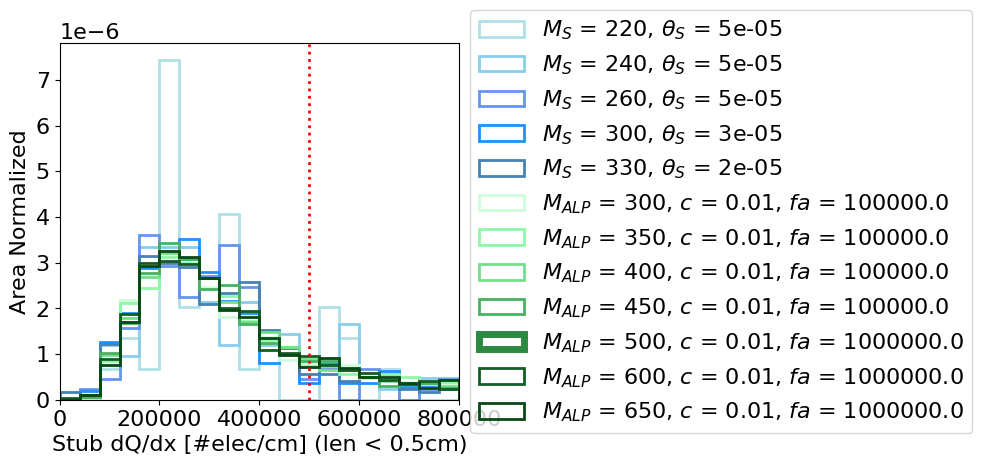

Var:  l1cm dqdx  (0.5cm < len < 1cm)
Number of entries in '$M_S$ = 220, $\\theta_S$ = 5e-05' with a dqdx value != NaN:  14 / 321
Number of entries in '$M_S$ = 240, $\\theta_S$ = 5e-05' with a dqdx value != NaN:  37 / 863
Number of entries in '$M_S$ = 260, $\\theta_S$ = 5e-05' with a dqdx value != NaN:  44 / 983
Number of entries in '$M_S$ = 300, $\\theta_S$ = 3e-05' with a dqdx value != NaN:  93 / 2264
Number of entries in '$M_S$ = 330, $\\theta_S$ = 2e-05' with a dqdx value != NaN:  132 / 2452
Number of entries in '$M_{ALP}$ = 300, $c$ = 0.01, $fa$ = 100000.0' with a dqdx value != NaN:  557 / 10808
Number of entries in '$M_{ALP}$ = 350, $c$ = 0.01, $fa$ = 100000.0' with a dqdx value != NaN:  529 / 11041
Number of entries in '$M_{ALP}$ = 400, $c$ = 0.01, $fa$ = 100000.0' with a dqdx value != NaN:  712 / 14752
Number of entries in '$M_{ALP}$ = 450, $c$ = 0.01, $fa$ = 100000.0' with a dqdx value != NaN:  814 / 16270
Number of entries in '$M_{ALP}$ = 500, $c$ = 0.01, $fa$ = 1000000.0' wit

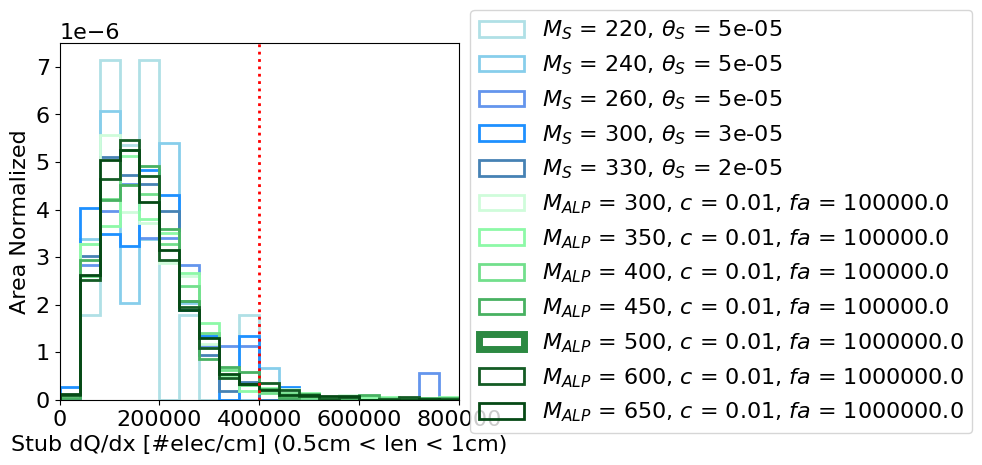

Var:  l2cm dqdx  (1cm < len < 2cm)
Number of entries in '$M_S$ = 220, $\\theta_S$ = 5e-05' with a dqdx value != NaN:  15 / 321
Number of entries in '$M_S$ = 240, $\\theta_S$ = 5e-05' with a dqdx value != NaN:  46 / 863
Number of entries in '$M_S$ = 260, $\\theta_S$ = 5e-05' with a dqdx value != NaN:  41 / 983
Number of entries in '$M_S$ = 300, $\\theta_S$ = 3e-05' with a dqdx value != NaN:  98 / 2264
Number of entries in '$M_S$ = 330, $\\theta_S$ = 2e-05' with a dqdx value != NaN:  122 / 2452
Number of entries in '$M_{ALP}$ = 300, $c$ = 0.01, $fa$ = 100000.0' with a dqdx value != NaN:  621 / 10808
Number of entries in '$M_{ALP}$ = 350, $c$ = 0.01, $fa$ = 100000.0' with a dqdx value != NaN:  623 / 11041
Number of entries in '$M_{ALP}$ = 400, $c$ = 0.01, $fa$ = 100000.0' with a dqdx value != NaN:  790 / 14752
Number of entries in '$M_{ALP}$ = 450, $c$ = 0.01, $fa$ = 100000.0' with a dqdx value != NaN:  898 / 16270
Number of entries in '$M_{ALP}$ = 500, $c$ = 0.01, $fa$ = 1000000.0' with 

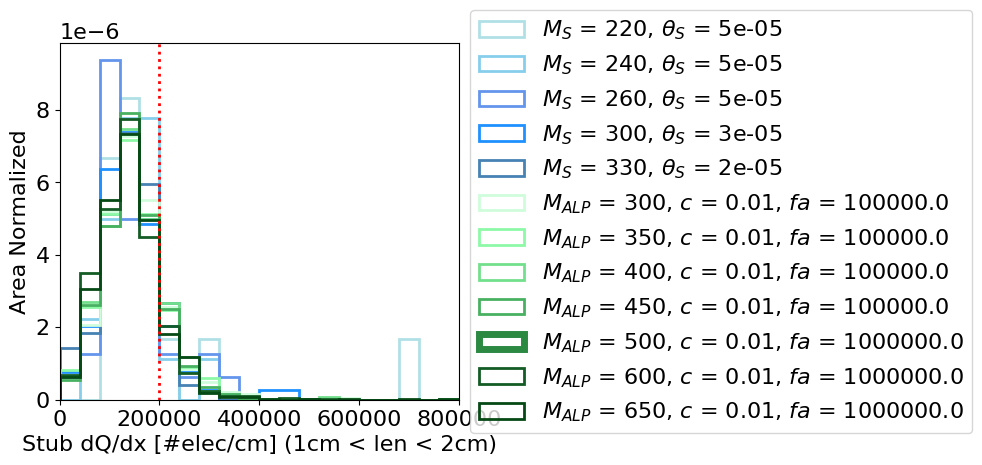

Var:  l3cm dqdx  (2cm < len < 3cm)
Number of entries in '$M_S$ = 220, $\\theta_S$ = 5e-05' with a dqdx value != NaN:  16 / 321
Number of entries in '$M_S$ = 240, $\\theta_S$ = 5e-05' with a dqdx value != NaN:  50 / 863
Number of entries in '$M_S$ = 260, $\\theta_S$ = 5e-05' with a dqdx value != NaN:  54 / 983
Number of entries in '$M_S$ = 300, $\\theta_S$ = 3e-05' with a dqdx value != NaN:  99 / 2264
Number of entries in '$M_S$ = 330, $\\theta_S$ = 2e-05' with a dqdx value != NaN:  128 / 2452
Number of entries in '$M_{ALP}$ = 300, $c$ = 0.01, $fa$ = 100000.0' with a dqdx value != NaN:  583 / 10808
Number of entries in '$M_{ALP}$ = 350, $c$ = 0.01, $fa$ = 100000.0' with a dqdx value != NaN:  617 / 11041
Number of entries in '$M_{ALP}$ = 400, $c$ = 0.01, $fa$ = 100000.0' with a dqdx value != NaN:  766 / 14752
Number of entries in '$M_{ALP}$ = 450, $c$ = 0.01, $fa$ = 100000.0' with a dqdx value != NaN:  906 / 16270
Number of entries in '$M_{ALP}$ = 500, $c$ = 0.01, $fa$ = 1000000.0' with 

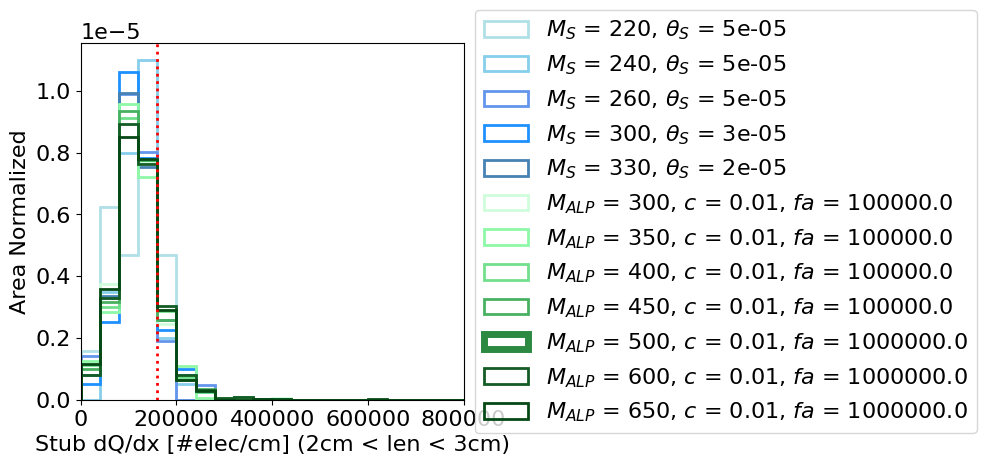

In [73]:
plot_stub_dqdx(evtdf, sample_description="\n all that pass preselection", vline=var_ths, density=True) #var_ths
#plot_stub_dqdx(evtdf_both_unc, sample_description="\n FULLY EXITING \n all that pass preselection", vline=var_ths) #var_ths
#plot_stub_dqdx(evtdf_semi_con, sample_description="\n SEMI CONTAINED \n all that pass preselection", vline=var_ths) #var_ths


### Max Shower Length

ToDo: add MC keyword to function.

In [51]:
def plot_max_shw_len(df, bins=[-12, -8] + list(np.linspace(0, 100, 26)), vline = None, bsm=False, detailed_nu=False,
                        density=True, POTSTR=POTSTR, sample_description=""):

    fig = plt.figure()
    ax = plt.subplot(111)
        
    #when = SlcInFV(evtdf.slc.vertex)
    var = df.max_shw_len.copy()
    var[np.isnan(var) | (var < 0)] = -10
    scale = df.scale.copy()
    
    if bsm == True:
        categories = make_categories(df, bsm=True)
    elif detailed_nu == True:
        categories = make_categories(df, detailed_nu=True)
    else:
        categories = make_categories(df)
        
    for c in categories:
        _ = plt.hist(var[c], weights=scale[c], bins=bins, label=c.name, color=c.color,
                     histtype="step", linewidth=2, density=density)
    #plt.legend()
    plt.xlabel("Max Shower Length [cm]")

    if density:
        plt.ylabel("Area Normalized")
    else:
        plt.ylabel("Candidates / %s" % POTSTR)
    plt.yscale("log")
    if vline is not None:
        plt.axvline([vline], linestyle=":", color="r", linewidth=2)
    #plt.title("ICARUS MC"+sample_description)
    #plt.text(0.6, 0.4, label, transform=plt.gca().transAxes, fontsize=18)
    plt.tight_layout()
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    #ax.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))

    if dosave: plt.savefig(savedir + "max_shw_len_M%i.pdf" % HMASS)
    plt.show()

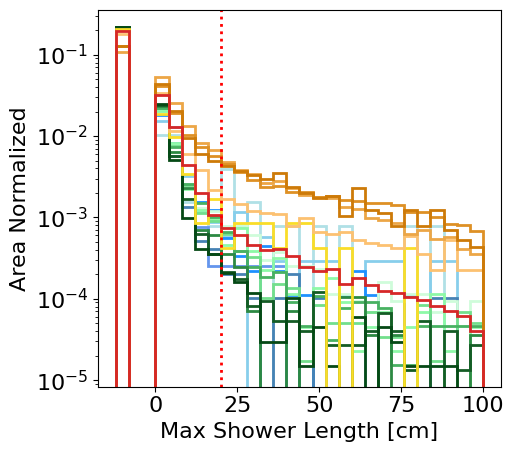

In [49]:
plot_max_shw_len(evtdf, sample_description="\n all that pass preselection", vline=max_shw_len_thresh, density=True, detailed_nu=True)# bsm=True)
#plot_max_shw_len(evtdf, sample_description="\n all that pass preselection", vline=max_shw_len_thresh, density=False, bsm=True)

#plot_max_shw_len(evtdf_both_unc, sample_description="\n FULLY EXITING \n all that pass preselection", vline=max_shw_len_thresh)
#plot_max_shw_len(evtdf_semi_con, sample_description="\n SEMI CONTAINED \n all that pass preselection", vline=max_shw_len_thresh)


### chi2pid (goes into 'ismuon' check)

ToDo: Add MC keyword to function.

To Do Tuesday 11/20/23: Rework chi2 plotting function so trunk and branch are combined into just "tracks", and muon and proton plots are side-by-side.

In [52]:
print(type(df.trunk.trk.chi2pid.I2.chi2_muon))
df.trunk.trk.chi2pid.I2.chi2_muon

AttributeError: 'DataFrame' object has no attribute 'trunk'

In [20]:
def plot_chi2(df, vline_mu = None, vline_p = None, bsm=False, detailed_nu=False,
                  density=True, POTSTR=POTSTR, sample_description=""):
    if bsm == True:
        categories = make_categories(df, bsm=True)
    elif detailed_nu == True:
        categories = make_categories(df, detailed_nu=True)
    else:
        categories = make_categories(df)
        
    plt.figure(figsize=(10.9,3))
    scale = df.scale.copy()
    
    # Muon Scores
    
    bins=np.linspace(0, 100, 31)
    plt.subplot(1,2,1)
    my_vars = [df.trunk.trk.chi2pid.I2.chi2_muon, df.branch.trk.chi2pid.I2.chi2_muon]
    for c in categories:
        _ = plt.hist(np.concatenate((my_vars[0][c], my_vars[1][c])),
                     weights=np.concatenate((scale[c],scale[c])), 
                     bins=bins, label=c.name, color=c.color,
                     histtype="step", linewidth=2, density=True)
    #plt.legend(loc='upper right')
    plt.xlim((0,100))
    plt.xlabel(" $\\chi^2$ Muon (Col. Plane)")
    if density:
        plt.ylabel("Area Normalized")
    else:
        plt.ylabel("Candidates / %s" % POTSTR)
    plt.yscale("log")
    if vline_mu is not None:
        plt.axvline([vline_mu], linestyle=":", color="r", linewidth=2)
    #plt.title("ICARUS MC"+sample_description)
    
    # Proton Scores
    
    bins=np.linspace(0, 400, 31)
    plt.subplot(1,2,2)
    
    my_vars = [df.trunk.trk.chi2pid.I2.chi2_proton, df.branch.trk.chi2pid.I2.chi2_proton]
    for c in categories:
        _ = plt.hist(np.concatenate((my_vars[0][c], my_vars[1][c])), 
                     weights=np.concatenate((scale[c],scale[c])), 
                     bins=bins, label=c.name, color=c.color,
                     histtype="step", linewidth=2, density=True)
    #plt.legend()
    plt.xlim((0,400))
    plt.xlabel(" $\\chi^2$ Proton (Col. Plane)")
    #if density:
    #    plt.ylabel("Area Normalized")
    #else:
    #    plt.ylabel("Candidates / %s" % POTSTR)
    plt.yscale("log")
    if vline_p is not None:
        plt.axvline([vline_p], linestyle=":", color="r", linewidth=2)
    #plt.title("ICARUS MC"+sample_description)
    
    # General
    plt.show()
    

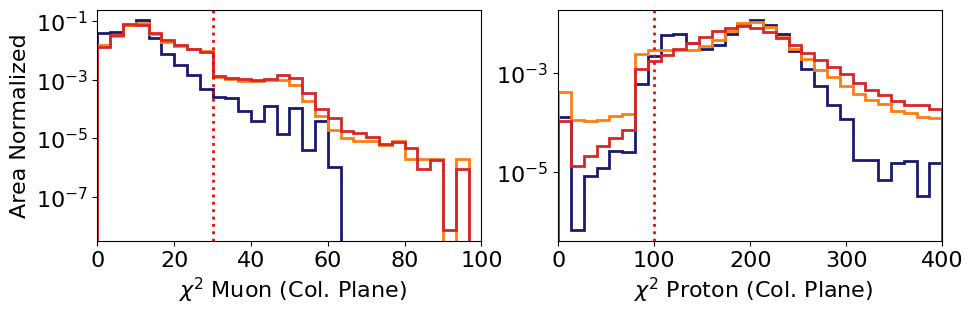

In [24]:
plot_chi2(evtdf, vline_mu = chi2_mu_forMuons, vline_p = chi2_p_forMuons, bsm=True, detailed_nu=False)

In [54]:
def plot_chi2muon(df, vline = None, bins=np.linspace(0, 100, 31), bsm=False, detailed_nu=False,
                  density=True, POTSTR=POTSTR, sample_description=""):
    
    my_vars = [df.trunk.trk.chi2pid.I2.chi2_muon, df.branch.trk.chi2pid.I2.chi2_muon]
    var_names = ['Trunk', 'Branch']
    scale = df.scale.copy()
    
    if bsm == True:
        categories = make_categories(df, bsm=True)
    elif detailed_nu == True:
        categories = make_categories(df, detailed_nu=True)
    else:
        categories = make_categories(df)
    
    for v in range(len(my_vars)):
        
        fig = plt.figure()
        ax = plt.subplot(111)
        
        for c in categories:
            _ = plt.hist(my_vars[v][c], weights=scale[c], bins=bins, label=c.name, color=c.color,
                         histtype="step", linewidth=2, density=True)
        plt.legend()
        plt.xlabel(var_names[v] + " $\\chi^2$ Muon (Col. Plane)")
        if density:
            plt.ylabel("Area Normalized")
        else:
            plt.ylabel("Candidates / %s" % POTSTR)
        plt.yscale("log")
        if vline is not None:
            plt.axvline([vline], linestyle=":", color="r", linewidth=2)
        plt.title("ICARUS MC"+sample_description)
        #plt.text(0.6, 0.4, label, transform=plt.gca().transAxes, fontsize=18)
        plt.tight_layout()
        
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))
        
        #if dosave: plt.savefig(savedir + "max_shw_len.pdf")
        plt.show()

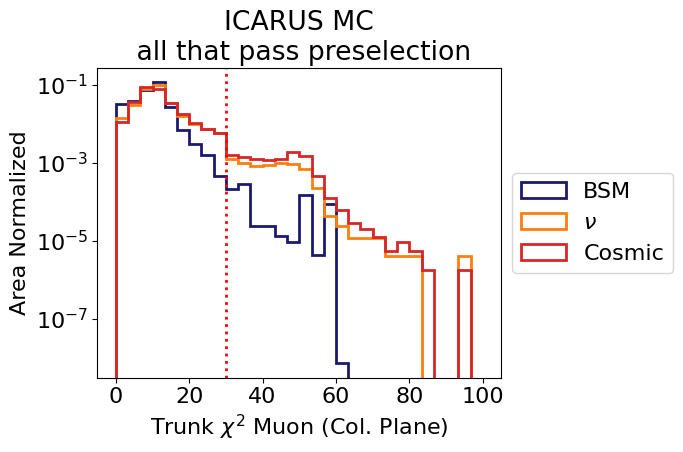

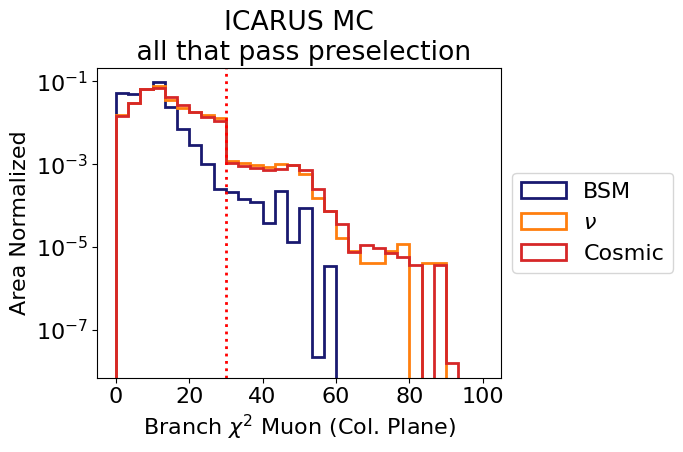

In [34]:
plot_chi2muon(evtdf, sample_description="\n all that pass preselection", vline=chi2_mu_forMuons, bsm=True)
#plot_chi2muon(evtdf_both_unc, sample_description="\n FULLY EXITING \n all that pass preselection", vline=chi2_mu_forMuons)
#plot_chi2muon(evtdf_semi_con, sample_description="\n SEMI CONTAINED \n all that pass preselection", vline=chi2_mu_forMuons)

In [55]:
def plot_chi2p(df, vline = None, bins=np.linspace(0, 400, 31), density=True, bsm=False, detailed_nu=False,
               POTSTR=POTSTR, sample_description=""):
    my_vars = [df.trunk.trk.chi2pid.I2.chi2_proton, df.branch.trk.chi2pid.I2.chi2_proton]
    var_names = ['Trunk', 'Branch']
    scale = df.scale.copy()
    
    if bsm == True:
        categories = make_categories(df, bsm=True)
    elif detailed_nu == True:
        categories = make_categories(df, detailed_nu=True)
    else:
        categories = make_categories(df)
        
    for v in range(len(my_vars)):
        fig = plt.figure()
        ax = plt.subplot(111)
    
        for c in categories:
            _ = plt.hist(my_vars[v][c], weights=scale[c], bins=bins, label=c.name, color=c.color,
                         histtype="step", linewidth=2, density=True)
        plt.legend()
        plt.xlabel(var_names[v] + " $\\chi^2$ Proton (Col. Plane)")
        if density:
            plt.ylabel("Area Normalized")
        else:
            plt.ylabel("Candidates / %s" % POTSTR)
        plt.yscale("log")
        if vline is not None:
            plt.axvline([vline], linestyle=":", color="r", linewidth=2)
        plt.title("ICARUS MC"+sample_description)
        #plt.text(0.6, 0.4, label, transform=plt.gca().transAxes, fontsize=18)
        plt.tight_layout()
        
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))
        
        #if dosave: plt.savefig(savedir + "max_shw_len.pdf")
        plt.show()

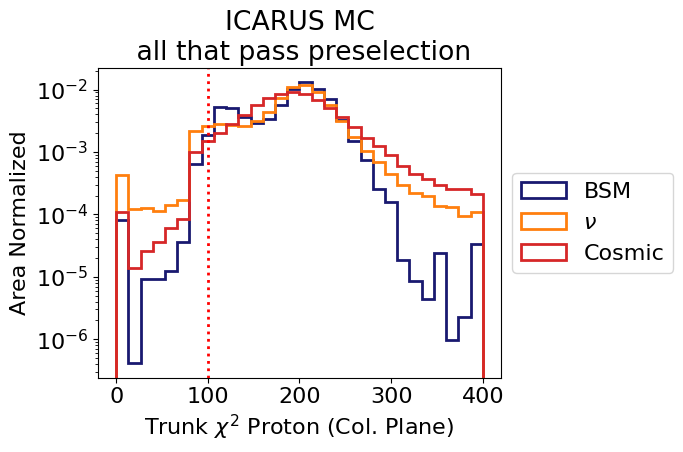

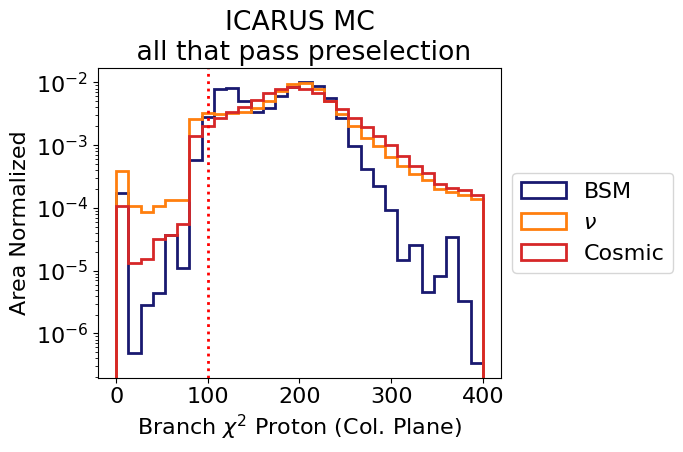

In [36]:
plot_chi2p(evtdf, sample_description="\n all that pass preselection", vline=chi2_p_forMuons, bsm=True)
#plot_chi2p(evtdf_both_unc, sample_description="\n FULLY EXITING \n all that pass preselection", vline=chi2_p_forMuons)
#plot_chi2p(evtdf_semi_con, sample_description="\n SEMI CONTAINED \n all that pass preselection", vline=chi2_p_forMuons)

### Other Trk Len

In [28]:
#for c in evtdf.columns: print(c)
    
def plot_other_trk_len(df, bins=[-12, -8] + list(np.linspace(0, 100, 26)), vline = None, bsm=False, detailed_nu=False,
                        density=True, POTSTR=POTSTR, sample_description=""):
    fig = plt.figure()
    ax = plt.subplot(111)
        
    var = df.max_othr_trk_len.copy()
    var[np.isnan(var) | (var < 0)] = -10
    scale = df.scale.copy()
    if bsm == True:
        categories = make_categories(df, bsm=True)
    elif detailed_nu == True:
        categories = make_categories(df, detailed_nu=True)
    else:
        categories = make_categories(df)
        
    for c in categories:
        _ = plt.hist(var[c], weights=scale[c], bins=bins, label=c.name, color=c.color,
                     histtype="step", linewidth=2, density=True)
    plt.legend()
    plt.xlabel("Max Other Trk Length [cm]")
    plt.title("ICARUS MC"+sample_description)
    plt.ylabel("Area Normalized")
    plt.yscale("log")
    if vline is not None:
        plt.axvline([vline], linestyle=":", color="r", linewidth=2)
    #plt.text(0.6, 0.4, label, transform=plt.gca().transAxes, fontsize=18)
    plt.tight_layout()
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))

    if dosave: plt.savefig(savedir + "max_shw_len.pdf")
    plt.show()

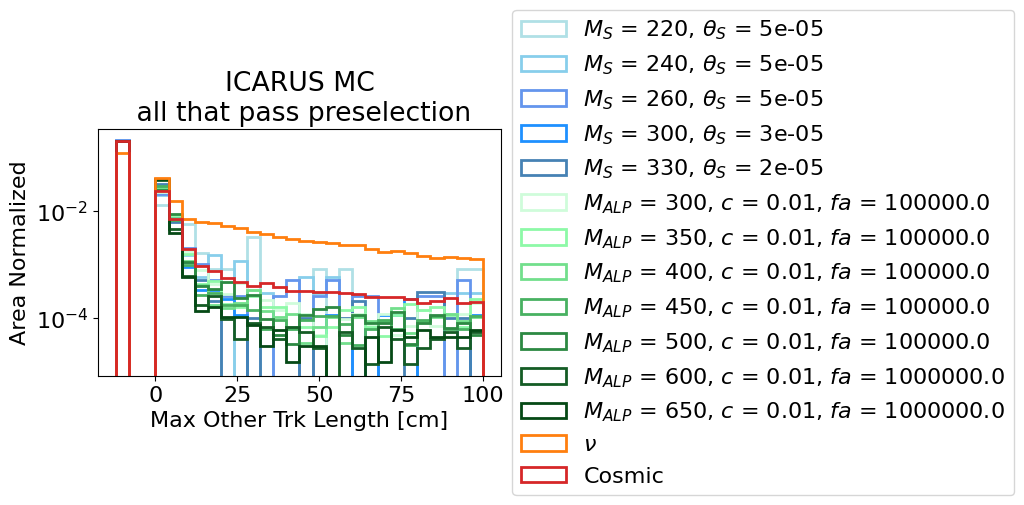

In [64]:
plot_other_trk_len(evtdf, sample_description="\n all that pass preselection")
#plot_other_trk_len(evtdf_both_unc, sample_description="\n FULLY EXITING \n all that pass preselection")
#plot_other_trk_len(evtdf_semi_con, sample_description="\n SEMI CONTAINED \n all that pass preselection")

### Distance between Third Track and Interaction Vertex

In [28]:
#third_trk_dist
def plot_third_trk_dist(df, bins= list(np.linspace(-12, 12, 25)), vline = None, bsm=False, detailed_nu=False,
                        density=True, POTSTR=POTSTR, sample_description=""):
    fig = plt.figure()
    ax = plt.subplot(111)
    
    var = df.third_trk_dist.copy()
    var[np.isnan(var) | (var < 0)] = -10
    scale = df.scale.copy()
    
    if bsm == True:
        categories = make_categories(df, bsm=True)
    elif detailed_nu == True:
        categories = make_categories(df, detailed_nu=True)
    else:
        categories = make_categories(df)
        
    for c in categories:
        _ = plt.hist(var[c], weights=scale[c], bins=bins, label=c.name, color=c.color,
                     histtype="step", linewidth=2, density=True)
    plt.legend()
    plt.xlabel("Distance between third track and Vtx [cm]")
    plt.title("ICARUS MC"+sample_description)
    plt.ylabel("Area Normalized")
    plt.yscale("log")
    if vline is not None:
        plt.axvline([vline], linestyle=":", color="r", linewidth=2)
    #plt.text(0.6, 0.4, label, transform=plt.gca().transAxes, fontsize=18)
    plt.tight_layout()
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))

    if dosave: plt.savefig(savedir + "max_shw_len_M%i.pdf" % HMASS)
    plt.show()

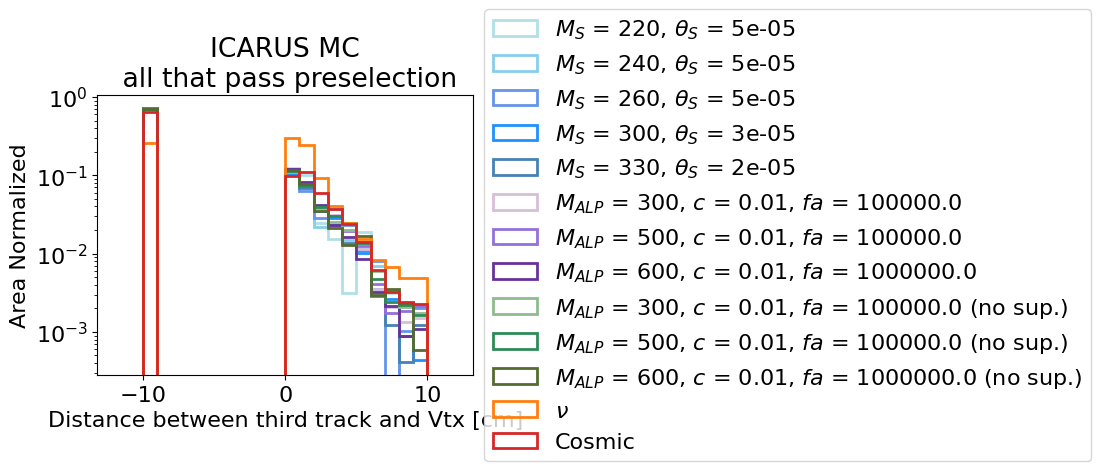

Conclude: this is not useful to cut on.


In [63]:
plot_third_trk_dist(evtdf, sample_description="\n all that pass preselection")
print('Conclude: this is not useful to cut on.')

### W.I.P.
### Momentum asymmetry

In [81]:
def plot_mom_asymmetry(df):
    var = np.abs((recop(df.trunk.trk) - recop(df.branch.trk)) / (recop(df.trunk.trk) + recop(df.branch.trk)))
    #when = SlcInFV(evtdf.slc.vertex) & muselect
    bins = np.linspace(0, 1, 21)
    for c in categories:
        _ = plt.hist(var[when & c], weights=scale[when & c], bins=bins, label=c.name, 
                     histtype="step", linewidth=2, density=True)
    plt.legend(loc="lower left")
    # plt.axvline([0.3], linestyle=":", color="r", linewidth=2)

    plt.tight_layout()
    plt.xlabel("Momentum Assymetry")
    plt.title("ICARUS MC")
    plt.ylabel("Area Normalized")

    plt.text(0.4, 0.05, label, transform=plt.gca().transAxes, fontsize=18)

    plt.tight_layout()
    if dosave: plt.savefig(savedir + "momentum_balance_M%i.pdf" % HMASS)
    plt.show()

In [83]:
plot_mom_asymmetry(evtdf)#, sample_description="\n all that pass preselection")#, vline=max_shw_len_thresh)

NameError: name 'recop' is not defined

# Impose Cuts

At this stage the dataframes already satisfy the following preselection:
- slice has contained interaction vertex
- slice has >= 2 tracks (muon candidates)
- One or both tracks have endpoint outside of the fiducial volume

### Gray's Way, but change it a little.

In [22]:
#print('NuMI_angle_thresh: ', NuMI_angle_thresh)
#print('open_angle_thresh: ', open_angle_thresh) 
#new_trk_len_thresh = 45.
#if new_trk_len_thresh != trk_len_thresh:
#    trk_len_thresh = new_trk_len_thresh
#    print("FYI: you just defined the track length threshold to be different than it was previously")
#print("trk_len_thresh: ", trk_len_thresh)

# Note: all these 'cuts' are actually just masks. The 'cut_all' function is what actually applies the cut.

#muselect = is_muon(evtdf.trunk.trk) & is_muon(evtdf.branch.trk)
#muselect.name = "2 Muon Tracks Reconstructed"

def is_muon(trk):
    return (trk.chi2pid.I2.chi2_muon < chi2_mu_forMuons) & (trk.chi2pid.I2.chi2_proton > chi2_p_forMuons)
def both_muon_tracks_mask(df, flip=False):
    mask = is_muon(df.trunk.trk) & is_muon(df.branch.trk) # this picks out the events where both are muons
    if flip==True:
        return ~mask, 'One or both candidate tracks are not muons'
    else:
        return mask, 'Both trunk, branch are muons'                                                        
## So that I can optimize the choice of chi2 values, rework the above cut into two separate ones:
##    (Using both of these cuts is the same as using both_muon_tracks_mask)
def ok_chi2mu(df, thresh = chi2_mu_forMuons):
    return( (df.trunk.trk.chi2pid.I2.chi2_muon < thresh) & (df.branch.trk.chi2pid.I2.chi2_muon < thresh) ), 'both chi2mu < %a' % chi2_mu_forMuons
def ok_chi2p(df, thresh = chi2_p_forMuons):
    return( (df.trunk.trk.chi2pid.I2.chi2_proton > thresh) & (df.branch.trk.chi2pid.I2.chi2_proton > thresh) ), 'both chi2p > %a' % chi2_p_forMuons


def numi_angle_mask(df, thresh = NuMI_angle_thresh):
    return df.Snumi_angle_mcs < thresh, 'S_NuMI_angle < '+str(thresh)+' rad'#'\u00B0'

def open_angle_mask(df, thresh = open_angle_thresh):
    return np.arccos(dotdf(df.trunk.trk.dir, df.branch.trk.dir)) < thresh, 'opening angle < '+str(thresh)+' rad'


def stub_mask(df, flip=False):
    hasstub = ((df.stub.l0_5cm.dqdx > stub_dqdx_l0_5cm_thresh) | 
               (df.stub.l1cm.dqdx > stub_dqdx_l1cm_thresh) | 
               (df.stub.l2cm.dqdx > stub_dqdx_l2cm_thresh) | 
               (df.stub.l3cm.dqdx > stub_dqdx_l3cm_thresh) 
              )
    if flip:
        return(hasstub), 'DOES have a stub (use for sideband)'
    else:
        return ~(hasstub), 'does not have stub'
# Recast into separate cuts for optimiztion:
def not_stub_05(df, thresh = stub_dqdx_l0_5cm_thresh):
    hasstub = (df.stub.l0_5cm.dqdx > thresh)
    return ~(hasstub), 'below 0_5cm dqdx <= %a ' % stub_dqdx_l0_5cm_thresh
def not_stub_1(df, thresh = stub_dqdx_l1cm_thresh):
    hasstub = (df.stub.l1cm.dqdx > thresh)
    return ~(hasstub), 'up to 1cm dqdx <= %a ' % stub_dqdx_l1cm_thresh
def not_stub_2(df, thresh = stub_dqdx_l2cm_thresh):
    hasstub = (df.stub.l2cm.dqdx > thresh)
    return ~(hasstub), 'up to 2cm dqdx <= %a ' % stub_dqdx_l2cm_thresh
def not_stub_3(df, thresh = stub_dqdx_l3cm_thresh):
    hasstub = (df.stub.l3cm.dqdx > thresh)
    return ~(hasstub), 'up to 3cmdqdx <= %a ' % stub_dqdx_l3cm_thresh


def max_shw_len_mask(df, thresh = max_shw_len_thresh):
    #var = df.max_shw_len.copy()
    #var[np.isnan(var) | (var < 0)] = -10 
    has_long_shw = df.max_shw_len >= thresh
    return ~has_long_shw, 'max shower len < %a cm' % thresh

def longTrk_len_mask(df, thresh = trk_len_thresh):
    return var > thresh, 'longer of tracks > %a cm' % thresh
    
def shortTrk_len_mask(df, thresh = trk_len_thresh):
    return df.shorter_track_length > thresh, 'shorter of tracks > %a cm' % thresh

#def other_trk_len_mask(df, thresh = other_trk_len_thresh):
#    has_long_other_trk = df.max_othr_trk_len >= thresh
#    return ~has_long_other_trk, 'max other trk len < %a cm' % thresh

#def third_trk_dist_mask(df, thresh = third_trk_dist_thresh):
#    dontwant = df.third_trk_dist >= third_trk_dist_thresh
#    return ~dontwant, 'third_trk_dist < %a cm' % thresh

def apply_cuts(df, cuts, flip_last_cut=False):
    
    #new_df = df.copy()
    categories = make_categories(df)
    
    # initialze data frames
    cut_results_df = pd.DataFrame(
        np.zeros((0,len(categories)), dtype=int), # start w/ zero rows (cuts), fill later
        columns = [c.name for c in categories]
    )
    cut_results_df_mc = cut_results_df.copy() #deep=True
    cut_results_df_pot = cut_results_df.copy() #deep=True
    cut_results_df_percent = cut_results_df.copy() #deep=True
    
    # fill in first row of data frame for "no cuts"
    row_mc = []
    row_pot = []
    for c in categories:
        #print(sum(df[c].scale))
        row_mc.append(df[c].shape[0])
        row_pot.append(round(100*sum(df[c].scale))/100.)
    cut_results_df_mc.loc["preselection"] = row_mc 
    first_row_mc = row_mc
    cut_results_df_pot.loc["preselection"] = row_pot
    cut_results_df_percent.loc["preselection"] = [1.] * len(row_pot)
    
    # Loop through cuts to make rows for data frame and to make master_mask
    master_mask = None
    for i in range(len(cuts)):
        func_output = cuts[i](*[df])
        if flip_last_cut: #overwrite with the flip
            if i == len(cuts)-1:
                func_output = cuts[i](*[df], flip=True)
                
        if i==0: 
            master_mask = func_output[0]
        else:
            master_mask = master_mask & func_output[0]
        new_df = df[master_mask]
        new_categories = make_categories(new_df)
        
        row_mc = []
        row_pot = []
        for c in new_categories:
            row_mc.append(new_df[c].shape[0])
            row_pot.append(round(100*sum(new_df[c].scale))/100.)
        cut_results_df_mc.loc[func_output[1]] = row_mc   
        cut_results_df_pot.loc[func_output[1]] = row_pot
        cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)
    
    return cut_results_df_mc, cut_results_df_pot, cut_results_df_percent, master_mask 
                           

In [23]:
# What's up with 500 MeV ALP stubs???

cut_results = apply_cuts(evtdf, [stub_mask], flip_last_cut=False)
df = add_hdr_info(evtdf[mask])

plt.hist(evtdf.stub.l0_5cm.dqdx)
plt.show()

plt.hist(df.stub.l0_5cm.dqdx)
plt.show()

NameError: name 'mask' is not defined

(368033,)
(70033,)


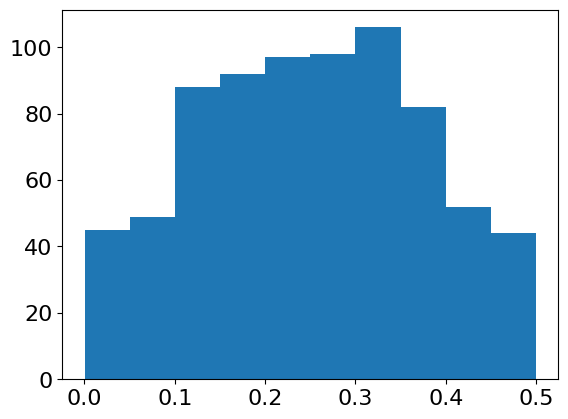

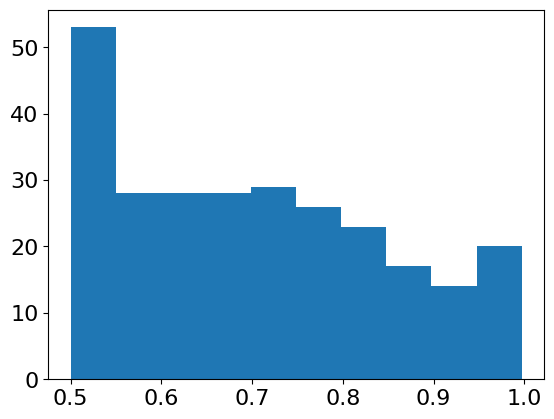

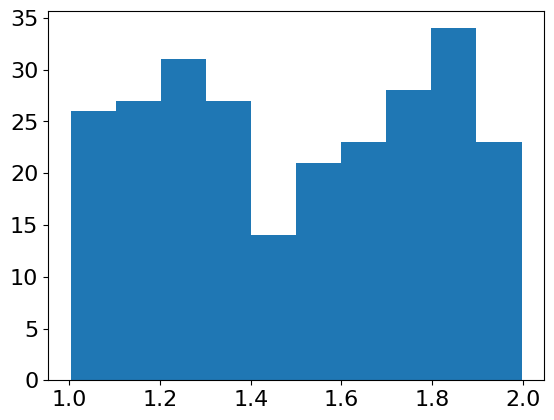

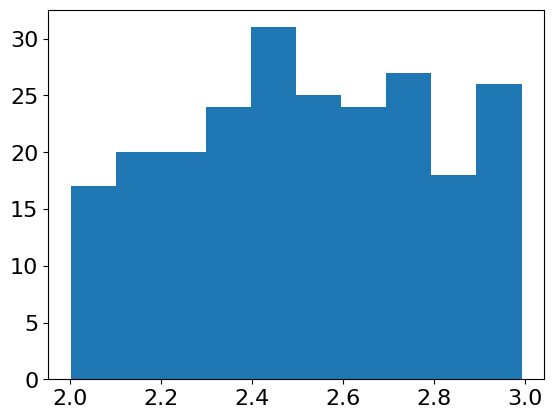

AttributeError: module 'numpy' has no attribute 'isNan'

In [82]:
print(np.isnan(evtdf.stub.l0_5cm.dqdx).shape)
print(np.isnan(df.stub.l0_5cm.dqdx).shape)

# Do we have NaN values in the same places for dQ/dx at all regions of a track?


#for c in df.stub.columns:
#    print(c)
    
plt.hist(df.stub.l0_5cm.length)
plt.show()

plt.hist(df.stub.l1cm.length)
plt.show()

plt.hist(df.stub.l2cm.length)
plt.show()

plt.hist(df.stub.l3cm.length)
plt.show()



In [95]:
print('Not NaN from 0.5 to 1 cm:', df.stub.l1cm.length.shape[0] - df[np.isnan(df.stub.l1cm.length)].shape[0])
print(df[np.isnan(df.stub.l0_5cm.length) & np.isnan(df.stub.l1cm.length) & np.isnan(df.stub.l2cm.length) & np.isnan(df.stub.l3cm.length)].shape[0])
print(df[np.isnan(df.stub.l0_5cm.length) & np.isnan(df.stub.l2cm.length) & np.isnan(df.stub.l3cm.length) & ~np.isnan(df.stub.l1cm.length)].shape[0])
#print(df[df.stub.l0_5cm.length==0.5].shape[0])

Not NaN from 0.5 to 1 cm: 266
68590
230


In [81]:
#for c in evtdf.columns:
#    print(c)
    
print(min(evtdf.trunk.trk.len))
print(min(evtdf.branch.trk.len))

10.000517845153809
10.000260353088379


In [24]:
# CHOOSE WHICH CUTS TO APPLY HERE:

#all_cuts = [both_muon_tracks_mask, numi_angle_mask, open_angle_mask, stub_mask, 
#            max_shw_len_mask, other_trk_len_mask, third_trk_dist_mask, shortTrk_len_mask]
#cut_list = all_cuts
#cut_list = [both_muon_tracks_mask, numi_angle_mask, open_angle_mask, stub_mask, 
#            max_shw_len_mask, other_trk_len_mask, third_trk_dist_mask]
#cut_list = [stub_mask, max_shw_len_mask, both_muon_tracks_mask,
#           numi_angle_mask, open_angle_mask]
#cut_list = [stub_mask, max_shw_len_mask, ok_chi2mu, ok_chi2p,
#           numi_angle_mask, open_angle_mask]
#cut_list = [not_stub_05, not_stub_1, not_stub_2, not_stub_3,
#            max_shw_len_mask, both_muon_tracks_mask,
#           numi_angle_mask, open_angle_mask]
cut_list = [not_stub_05, not_stub_1, not_stub_2, not_stub_3,
            max_shw_len_mask, ok_chi2mu, ok_chi2p,
           numi_angle_mask, open_angle_mask, shortTrk_len_mask]

condensed_cut_list = [stub_mask, max_shw_len_mask, both_muon_tracks_mask, 
                      open_angle_mask, numi_angle_mask, shortTrk_len_mask]

no_kin = [stub_mask, max_shw_len_mask, both_muon_tracks_mask, shortTrk_len_mask]
sideband_hasstub = [max_shw_len_mask,
           numi_angle_mask, open_angle_mask, shortTrk_len_mask, stub_mask, both_muon_tracks_mask]

no_cuts = []

cut_list_noTrkLenCut = [not_stub_05, not_stub_1, not_stub_2, not_stub_3,
            max_shw_len_mask, ok_chi2mu, ok_chi2p,
           numi_angle_mask, open_angle_mask]

##evtdf = evtdf_before_cuts
#evtdf_before_cuts = evtdf

#cut_results = apply_cuts(evtdf, cut_list)
cut_results = apply_cuts(evtdf, cut_list, flip_last_cut=False)
mask = cut_results[-1]
mc_res = cut_results[0]
pot_res = cut_results[1]
percent_res = cut_results[2]
#final_df = add_hdr_info(evtdf)
final_df = add_hdr_info(evtdf[mask])

/icarus/app/users/jdyer/dev_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [24]:
print(savedir)
subdir='with_kin/ALP500MeV_faE5'
print(subdir)

/icarus/data/users/jdyer/muon_selection/
with_kin/ALP500MeV_faE5


In [25]:
#subdir='no_cuts'
final_df.to_pickle(savedir + 'dfs/all_nus_bg/'+subdir+'/final_df')
mc_res.to_pickle(savedir + 'dfs/all_nus_bg/'+subdir+'/res_mc')
pot_res.to_pickle(savedir + 'dfs/all_nus_bg/'+subdir+'/res_pot')
percent_res.to_pickle(savedir + 'dfs/all_nus_bg/'+subdir+'/res_percent')
        

In [102]:
for c in evtdf.columns:
    print(c)

('slc', 'is_clear_cosmic', '', '', '', '')
('slc', 'vertex', 'x', '', '', '')
('slc', 'vertex', 'y', '', '', '')
('slc', 'vertex', 'z', '', '', '')
('slc', 'self', '', '', '', '')
('slc', 'tmatch', 'eff', '', '', '')
('slc', 'tmatch', 'pur', '', '', '')
('slc', 'tmatch', 'idx', '', '', '')
('slc', 'producer', '', '', '', '')
('slc', 'nuid', 'crlongtrkdiry', '', '', '')
('slc', 'truth', 'E', '', '', '')
('slc', 'truth', 'bjorkenX', '', '', '')
('slc', 'truth', 'inelasticityY', '', '', '')
('slc', 'truth', 'Q2', '', '', '')
('slc', 'truth', 'w', '', '', '')
('slc', 'truth', 't', '', '', '')
('slc', 'truth', 'position', 'x', '', '')
('slc', 'truth', 'position', 'y', '', '')
('slc', 'truth', 'position', 'z', '', '')
('slc', 'truth', 'pdg', '', '', '')
('slc', 'truth', 'iscc', '', '', '')
('slc', 'truth', 'genie_mode', '', '', '')
('slc', 'truth', 'max_proton_ke', '', '', '')
('slc', 'truth', 'nn', '', '', '')
('slc', 'truth', 'np', '', '', '')
('slc', 'truth', 'npi', '', '', '')
('slc', 't

In [96]:
print("Number of MC Events: ")
mc_res

Number of MC Events: 


$M_S$ = 220, $\theta_S$ = 5e-05  \
preselection                                              321   
does not have stub                                        305   
max shower len < 0.0 cm                                   259   
Both trunk, branch are muons                              226   
opening angle < 0.35 rad                                  172   
S_NuMI_angle < 0.05 rad                                    75   
shorter of tracks > 140.0 cm                               37   

                              $M_S$ = 240, $\theta_S$ = 5e-05  \
preselection                                              863   
does not have stub                                        811   
max shower len < 0.0 cm                                   685   
Both trunk, branch are muons                              649   
opening angle < 0.35 rad                                  539   
S_NuMI_angle < 0.05 rad                                   317   
shorter of tracks > 140.0 cm                              170   

                              $M_S$ = 260, $\theta_S$ = 5e-05  \
preselection                                              983   
does not have stub                                        916   
max shower len < 0.0 cm                                   791   
Both trunk, branch are muons                              740   
opening angle < 0.35 rad                                  552   
S_NuMI_angle < 0.05 rad                                   325   
shorter of tracks > 140.0 cm                              182   

                              $M_S$ = 300, $\theta_S$ = 3e-05  \
preselection                                             2264   
does not have stub                                       2140   
max shower len < 0.0 cm                                  1851   
Both trunk, branch are muons                             1740   
opening angle < 0.35 rad                                 1230   
S_NuMI_angle < 0.05 rad                                   774   
shorter of tracks > 140.0 cm                              533   

                              $M_S$ = 330, $\theta_S$ = 2e-05  \
preselection                                             2452   
does not have stub                                       2320   
max shower len < 0.0 cm                                  2022   
Both trunk, branch are muons                             1894   
opening angle < 0.35 rad                                 1139   
S_NuMI_angle < 0.05 rad                                   722   
shorter of tracks > 140.0 cm                              479   

                              $M_{ALP}$ = 300, $c$ = 0.01, $fa$ = 100000.0  \
preselection                                                         10808   
does not have stub                                                   10109   
max shower len < 0.0 cm                                               8590   
Both trunk, branch are muons                                          7942   
opening angle < 0.35 rad                                              5830   
S_NuMI_angle < 0.05 rad                                               4027   
shorter of tracks > 140.0 cm                                          2872   

                              $M_{ALP}$ = 350, $c$ = 0.01, $fa$ = 100000.0  \
preselection                                                         11041   
does not have stub                                                   10306   
max shower len < 0.0 cm                                               8830   
Both trunk, branch are muons                                          8151   
opening angle < 0.35 rad                                              5671   
S_NuMI_angle < 0.05 rad                                               3891   
shorter of tracks > 140.0 cm                                          2882   

                              $M_{ALP}$ = 400, $c$ = 0.01, $fa$ = 100000.0  \
preselection                                                         14752   
does not have stub 

In [97]:
print("Fraction of Events: ")
percent_res

Fraction of Events: 


$M_S$ = 220, $\theta_S$ = 5e-05  \
preselection                                         1.000000   
does not have stub                                   0.950156   
max shower len < 0.0 cm                              0.806854   
Both trunk, branch are muons                         0.704050   
opening angle < 0.35 rad                             0.535826   
S_NuMI_angle < 0.05 rad                              0.233645   
shorter of tracks > 140.0 cm                         0.115265   

                              $M_S$ = 240, $\theta_S$ = 5e-05  \
preselection                                         1.000000   
does not have stub                                   0.939745   
max shower len < 0.0 cm                              0.793743   
Both trunk, branch are muons                         0.752028   
opening angle < 0.35 rad                             0.624565   
S_NuMI_angle < 0.05 rad                              0.367323   
shorter of tracks > 140.0 cm                         0.196987   

                              $M_S$ = 260, $\theta_S$ = 5e-05  \
preselection                                         1.000000   
does not have stub                                   0.931841   
max shower len < 0.0 cm                              0.804680   
Both trunk, branch are muons                         0.752798   
opening angle < 0.35 rad                             0.561546   
S_NuMI_angle < 0.05 rad                              0.330621   
shorter of tracks > 140.0 cm                         0.185148   

                              $M_S$ = 300, $\theta_S$ = 3e-05  \
preselection                                         1.000000   
does not have stub                                   0.945230   
max shower len < 0.0 cm                              0.817580   
Both trunk, branch are muons                         0.768551   
opening angle < 0.35 rad                             0.543286   
S_NuMI_angle < 0.05 rad                              0.341873   
shorter of tracks > 140.0 cm                         0.235424   

                              $M_S$ = 330, $\theta_S$ = 2e-05  \
preselection                                         1.000000   
does not have stub                                   0.946166   
max shower len < 0.0 cm                              0.824633   
Both trunk, branch are muons                         0.772431   
opening angle < 0.35 rad                             0.464519   
S_NuMI_angle < 0.05 rad                              0.294454   
shorter of tracks > 140.0 cm                         0.195351   

                              $M_{ALP}$ = 300, $c$ = 0.01, $fa$ = 100000.0  \
preselection                                                      1.000000   
does not have stub                                                0.935326   
max shower len < 0.0 cm                                           0.794782   
Both trunk, branch are muons                                      0.734826   
opening angle < 0.35 rad                                          0.539415   
S_NuMI_angle < 0.05 rad                                           0.372594   
shorter of tracks > 140.0 cm                                      0.265729   

                              $M_{ALP}$ = 350, $c$ = 0.01, $fa$ = 100000.0  \
preselection                                                      1.000000   
does not have stub                                                0.933430   
max shower len < 0.0 cm                                           0.799746   
Both trunk, branch are muons                                      0.738248   
opening angle < 0.35 rad                                          0.513631   
S_NuMI_angle < 0.05 rad                                           0.352414   
shorter of tracks > 140.0 cm                                      0.261027   

                              $M_{ALP}$ = 400, $c$ = 0.01, $fa$ = 100000.0  \
preselection                                                      1.000000   
does not have stub 

In [98]:
print("Normalized to " + POTSTR + ":")
pot_res

Normalized to 2e20 POT:


$M_S$ = 220, $\theta_S$ = 5e-05  \
preselection                                             3.03   
does not have stub                                       2.88   
max shower len < 0.0 cm                                  2.44   
Both trunk, branch are muons                             2.13   
opening angle < 0.35 rad                                 1.62   
S_NuMI_angle < 0.05 rad                                  0.71   
shorter of tracks > 140.0 cm                             0.35   

                              $M_S$ = 240, $\theta_S$ = 5e-05  \
preselection                                            30.03   
does not have stub                                      28.22   
max shower len < 0.0 cm                                 23.84   
Both trunk, branch are muons                            22.58   
opening angle < 0.35 rad                                18.76   
S_NuMI_angle < 0.05 rad                                 11.03   
shorter of tracks > 140.0 cm                             5.92   

                              $M_S$ = 260, $\theta_S$ = 5e-05  \
preselection                                            54.11   
does not have stub                                      50.42   
max shower len < 0.0 cm                                 43.54   
Both trunk, branch are muons                            40.74   
opening angle < 0.35 rad                                30.39   
S_NuMI_angle < 0.05 rad                                 17.89   
shorter of tracks > 140.0 cm                            10.02   

                              $M_S$ = 300, $\theta_S$ = 3e-05  \
preselection                                             4.67   
does not have stub                                       4.42   
max shower len < 0.0 cm                                  3.82   
Both trunk, branch are muons                             3.59   
opening angle < 0.35 rad                                 2.54   
S_NuMI_angle < 0.05 rad                                  1.60   
shorter of tracks > 140.0 cm                             1.10   

                              $M_S$ = 330, $\theta_S$ = 2e-05  \
preselection                                             1.68   
does not have stub                                       1.59   
max shower len < 0.0 cm                                  1.38   
Both trunk, branch are muons                             1.30   
opening angle < 0.35 rad                                 0.78   
S_NuMI_angle < 0.05 rad                                  0.49   
shorter of tracks > 140.0 cm                             0.33   

                              $M_{ALP}$ = 300, $c$ = 0.01, $fa$ = 100000.0  \
preselection                                                          3.62   
does not have stub                                                    3.38   
max shower len < 0.0 cm                                               2.88   
Both trunk, branch are muons                                          2.66   
opening angle < 0.35 rad                                              1.95   
S_NuMI_angle < 0.05 rad                                               1.35   
shorter of tracks > 140.0 cm                                          0.96   

                              $M_{ALP}$ = 350, $c$ = 0.01, $fa$ = 100000.0  \
preselection                                                          5.23   
does not have stub                                                    4.88   
max shower len < 0.0 cm                                               4.18   
Both trunk, branch are muons                                          3.86   
opening angle < 0.35 rad                                              2.68   
S_NuMI_angle < 0.05 rad                                               1.84   
shorter of tracks > 140.0 cm                                          1.36   

                              $M_{ALP}$ = 400, $c$ = 0.01, $fa$ = 100000.0  \
preselection                                                          7.92   
does not have stub 

In [61]:
final_df

slc                          \
                                     is_clear_cosmic      vertex               
                                                               x           y   
                                                                               
                                                                               
                                                                               
sample __ntuple entry rec.slc..index                                           
0      18       19    0                            0 -105.359520  -39.762115   
       10       6     0                            0 -137.550140   80.211090   
       19       12    19                           0  313.451416  104.441345   
       15       14    19                           0  308.137299 -132.717407   
                19    1                            0 -133.704056  -33.341614   
..                                               ...         ...         ...   
12     6967     219   0                            0 -125.843575  -36.835785   
       6969     131   0                            0 -120.330688  113.042725   
       6987     1     12                           0  220.495712 -161.498367   
       6997     176   0                            0 -192.157761  -62.999214   
       7001     166   22                           0  100.852966 -165.520660   

                                                                               \
                                                 self    tmatch                 
                                               z            eff       pur idx   
                                                                                
                                                                                
                                                                                
sample __ntuple entry rec.slc..index                                            
0      18       19    0               427.736145  203  0.842021  0.946856   0   
       10       6     0               556.435852  182  0.922363  0.988839   0   
       19       12    19              288.581024  107  0.903210  1.000000   0   
       15       14    19              672.778564  278  0.901694  0.972184   0   
                19    1               768.944031  176  0.915642  0.998842   0   
..                                           ...  ...       ...       ...  ..   
12     6967     219   0               396.437195  108  0.868450  1.000001   0   
       6969     131   0               773.581848   85  0.810308  0.998397   0   
       6987     1     12             -159.985672  141  0.758383  0.998707   0   
       6997     176   0                49.149925   95  0.779666  0.998971   0   
       7001     166   22             -123.436401  119  0.727091  0.998164   0   

                                                             ... stub         \
                                     producer          nuid  ... l3cm          
                                              crlongtrkdiry  ...    Q length   
                                                             ...               
                                                             ...               
                                                             ...               
sample __ntuple entry rec.slc..index                         ...               
0      18       19    0                     0      0.003372  ...  NaN    NaN   
       10       6     0                     0     -0.117672  ...  NaN    NaN   
       19       12    19                    1     -0.359291  ...  NaN    NaN   
       15       14    19                    1      0.026933  ...  NaN    NaN   
                19    1                     0     -0.213480  ...  NaN    NaN   
..                                        ...           ...  ...  ...    ...   
12     6967     219   0                     0     -0.278879  ...  NaN    NaN   
       6969     131   0      

## Extract info needed for event display

In [70]:
# THE FOLLOWING DOESN'T WORK LIKE WE EXPECTED IT TO.
# viewable_final_df = final_df[ final_df['proc']%10 == 0]

c = -2

cats = make_categories(final_df)
mydf = final_df[cats[c]]
print(cats[c].name)
mydf.shape
#final_df[cats[5]][final_df[cats[5]]['proc']==5 & final_df[cats[5]]['cluster']==4372431]
mydf
pair=0
for idx in mydf.index:
    if [int(mydf.loc[idx]['cluster']), int(mydf.loc[idx]['proc'])] == pair: continue
    else:
        pair = [int(mydf.loc[idx]['cluster']), int(mydf.loc[idx]['proc'])]
        print(pair)

$\nu$
[4444026, 1206]
[4444026, 1563]
[4444026, 2432]
[4444026, 3238]
[4444026, 3477]
[4444026, 3940]
[4444026, 4313]
[4444026, 4342]
[4444026, 4853]
[4444026, 5000]
[4444026, 5053]
[4444026, 6539]
[4444026, 6987]


In [62]:
pd.DataFrame(mydf[ mydf['proc']==180])#["shorter_track_length"])# & mydf['cluster']==4372431 ])

dist_to_vertex
sample __ntuple entry rec.slc..index                
5      81       14    18                         NaN
                19    17                         NaN

In [71]:
evtdf.query("entry==0")

slc                          \
                                     is_clear_cosmic      vertex               
                                                               x           y   
                                                                               
                                                                               
                                                                               
sample __ntuple entry rec.slc..index                                           
0      5        0     12                           0  176.123276  -26.351227   
       32       0     18                           0  276.861725  -47.426147   
       63       0     15                           0  305.970093 -110.071213   
       74       0     24                           0  146.915329 -118.870514   
       95       0     1                            0 -211.664902  -64.810059   
..                                               ...         ...         ...   
12     6909     0     0                            0 -193.161209  -89.889786   
       6919     0     0                            0 -336.303558  -51.306717   
       6925     0     0                            0 -224.010376 -127.388092   
       6962     0     17                           0  121.365768 -134.023193   
       6982     0     1                            0 -158.701904   52.638397   

                                                                           \
                                                 self    tmatch             
                                               z            eff       pur   
                                                                            
                                                                            
                                                                            
sample __ntuple entry rec.slc..index                                        
0      5        0     12              490.231079  105       NaN       NaN   
       32       0     18              780.517395  241       NaN       NaN   
       63       0     15              297.950928  135  0.890485  0.958071   
       74       0     24              246.626343  355  0.698372  0.881520   
       95       0     1              -847.554626  250       NaN       NaN   
..                                           ...  ...       ...       ...   
12     6909     0     0               242.436508  118       NaN       NaN   
       6919     0     0               227.507645   69       NaN       NaN   
       6925     0     0               516.625244  151       NaN       NaN   
       6962     0     17              751.392151  130  0.577823  0.999349   
       6982     0     1              -408.579285  136       NaN       NaN   

                                                                  ...  \
                                          producer          nuid  ...   
                                      idx          crlongtrkdiry  ...   
                                                                  ...   
                                                                  ...   
                                                                  ...   
sample __ntuple entry rec.slc..index                              ...   
0      5        0     12             -999        1     -0.466068  ...   
       32       0     18             -999        1     -0.897126  ...   
       63       0     15                0        1     -0.183373  ...   
       74       0     24                0        1     -0.877071  ...   
       95       0     1              -999        0     -0.597003  ...   
..                                    ...      ...           ...  ...   
12     6909     0     0              -999        0     -0.848673  ...   
       6919     0     0              -999        0     -0.947639  ...   
       6925     0     0              -999        0     -0.783871  ...   
       6962     0     17                0        1   

In [68]:
final_df

slc                          \
                                     is_clear_cosmic      vertex               
                                                               x           y   
                                                                               
                                                                               
                                                                               
sample __ntuple entry rec.slc..index                                           
0      10       6     0                            0 -137.550140   80.211090   
       49       2     1                            0 -139.672394  -60.575729   
       87       20    10                           0  210.485367  -56.962399   
       105      15    14                           0  142.216400  -46.298374   
       110      13    0                            0 -165.103683 -161.912247   
..                                               ...         ...         ...   
12     4279     172   1                            0 -187.539886   23.401184   
       4444     45    0                            0 -198.929413 -101.789307   
       4502     127   19                           0  255.800964  -55.191528   
       6150     236   17                           0  214.587585   21.150330   
       6645     120   0                            0 -160.763794   59.780487   

                                                                               \
                                                 self    tmatch                 
                                               z            eff       pur idx   
                                                                                
                                                                                
                                                                                
sample __ntuple entry rec.slc..index                                            
0      10       6     0               556.435852  182  0.922363  0.988839   0   
       49       2     1              -293.824646  250  0.709152  0.944103   0   
       87       20    10             -195.739227  130  0.867942  0.989385   0   
       105      15    14              404.727722  176  0.848213  0.992334   0   
       110      13    0               615.129761   72  0.893664  0.994344   0   
..                                           ...  ...       ...       ...  ..   
12     4279     172   1               716.523071  261  0.889747  0.979087   0   
       4444     45    0               763.679688  151  0.777646  0.974933   0   
       4502     127   19             -763.117737  118  0.897586  0.999999   0   
       6150     236   17             -627.641968   83  0.888946  0.985770   0   
       6645     120   0              -558.081665  200  0.852075  0.965248   0   

                                                             ...  \
                                     producer          nuid  ...   
                                              crlongtrkdiry  ...   
                                                             ...   
                                                             ...   
                                                             ...   
sample __ntuple entry rec.slc..index                         ...   
0      10       6     0                     0     -0.117672  ...   
       49       2     1                     0     -0.187669  ...   
       87       20    10                    1      0.068722  ...   
       105      15    14                    1     -0.114128  ...   
       110      13    0                     0      0.153792  ...   
..                                        ...           ...  ...   
12     4279     172   1                     0     -0.025453  ...   
       4444     45    0                     0      0.026420  ...   
       4502     127   19                    1     -0.062157  ...   
       6150     236   17                    1     -0.068047  

## See what kinds of neutrinos remain

['$\\nu_\\mu$ CC COH' '$\\nu_\\mu$ CC Other' '$\\nu_\\mu$ CC n$\\pi$0p'
 '$\\nu_\\mu$ CC n$\\pi$np']
['$\\nu_\\mu$ CC COH' '$\\nu_\\mu$ CC Other' '$\\nu_\\mu$ CC n$\\pi$np'
 '$\\nu_\\mu$ CC n$\\pi$0p' '$\\nu_\\mu$ CC n$\\pi$np']


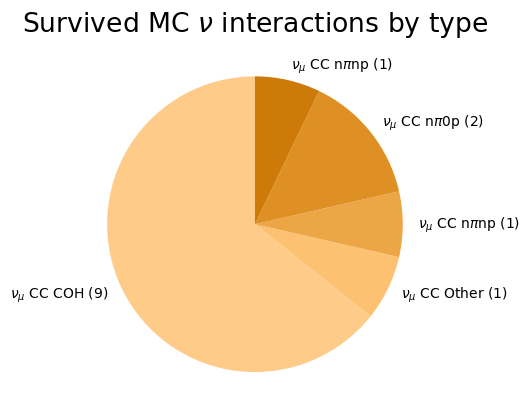

In [25]:
remaining_nus = final_df[make_categories(final_df)[-2]]
remaining_nus = add_nu_int_type(remaining_nus)
survived_types = np.unique(remaining_nus.nu_mode)
print(survived_types)
# change the order so the pie chart looks better:
survived_types = np.array([
    survived_types[0],
    survived_types[1],
    survived_types[3],
    survived_types[2],
    survived_types[-1]
])
print(survived_types)
narray = []
labels = []
for st in survived_types:
    n = remaining_nus[remaining_nus.nu_mode == st].shape[0]
    narray.append(n)
    labels.append(st + ' (%a)' % n)
plt.pie(narray, labels = labels, colors = oranges, startangle = 90, textprops={'fontsize': 10})
plt.title('Survived MC $\\nu$ interactions by type' )
#if dosave: plt.savefig(savedir + "containment_%a.pdf" % c.name, bbox_inches = mpl.transforms.Bbox([[-1,0], [7,5]]))
plt.show()


In [26]:
# Truth particles:

#plt.hist(remaining_nus.slc.truth.p0.pdg, bins=31, range=(-15,15))
#plt.xlabel("Survived nu interactions' p0 PDG")
#plt.show()
print(np.unique(remaining_nus.slc.truth.p0.pdg))

#plt.hist(remaining_nus.slc.truth.p1.pdg)#, bins=31, range=(-15,15))
#plt.xlabel("Survived nu interactions' p1 PDG")
#plt.show()
print(np.unique(remaining_nus.slc.truth.p1.pdg))

# Track true particle PDGs:
print('')
print(np.unique(remaining_nus.trunk.trk.truth.p.pdg))
print(np.unique(remaining_nus.branch.trk.truth.p.pdg))

remaining_nus_w_pion = remaining_nus[(np.abs(remaining_nus.trunk.trk.truth.p.pdg)==211) | 
                                     (np.abs(remaining_nus.branch.trk.truth.p.pdg)==211)
                                    ]
print(remaining_nus.shape)
print(remaining_nus_w_pion.shape)

###

# 211: pi+
# -211: pi-
# 311: K0
# 2112: n
# 2212: p
#3122: Delta

#for c in remaining_nus.columns:
#    print(c)

[-13.  13.]
[-211.  211. 2112. 2212.]

[-211  -13   13  211]
[-211  -13   13   22  211 2212]
(13, 211)
(7, 211)


In [119]:
for c in evtdf.columns:
    print(c)

('slc', 'is_clear_cosmic', '', '', '', '')
('slc', 'vertex', 'x', '', '', '')
('slc', 'vertex', 'y', '', '', '')
('slc', 'vertex', 'z', '', '', '')
('slc', 'self', '', '', '', '')
('slc', 'tmatch', 'eff', '', '', '')
('slc', 'tmatch', 'pur', '', '', '')
('slc', 'tmatch', 'idx', '', '', '')
('slc', 'producer', '', '', '', '')
('slc', 'nuid', 'crlongtrkdiry', '', '', '')
('slc', 'truth', 'E', '', '', '')
('slc', 'truth', 'bjorkenX', '', '', '')
('slc', 'truth', 'inelasticityY', '', '', '')
('slc', 'truth', 'Q2', '', '', '')
('slc', 'truth', 'w', '', '', '')
('slc', 'truth', 't', '', '', '')
('slc', 'truth', 'position', 'x', '', '')
('slc', 'truth', 'position', 'y', '', '')
('slc', 'truth', 'position', 'z', '', '')
('slc', 'truth', 'pdg', '', '', '')
('slc', 'truth', 'iscc', '', '', '')
('slc', 'truth', 'genie_mode', '', '', '')
('slc', 'truth', 'max_proton_ke', '', '', '')
('slc', 'truth', 'nn', '', '', '')
('slc', 'truth', 'np', '', '', '')
('slc', 'truth', 'npi', '', '', '')
('slc', 't

### Look into protons and performance of stub cut at getting rid of them: 
###    (doesn't look like it's actually doing much :/ )

ValueError: weights should have the same shape as x

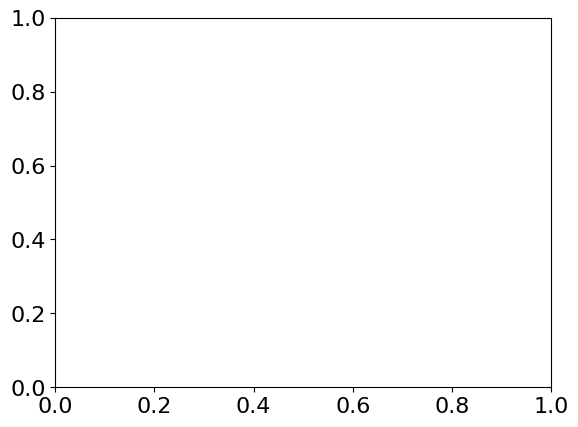

In [31]:
check_proton_stubs(evtdf, detailed_nu=True)

$M_S$ = 220, $\theta_S$ = 5e-05
$M_S$ = 240, $\theta_S$ = 5e-05
$M_S$ = 260, $\theta_S$ = 5e-05
$M_S$ = 300, $\theta_S$ = 3e-05
$M_S$ = 330, $\theta_S$ = 2e-05
$M_{ALP}$ = 300, $c$ = 0.01, $fa$ = 100000.0
$M_{ALP}$ = 350, $c$ = 0.01, $fa$ = 100000.0
$M_{ALP}$ = 400, $c$ = 0.01, $fa$ = 100000.0
$M_{ALP}$ = 450, $c$ = 0.01, $fa$ = 100000.0
$M_{ALP}$ = 500, $c$ = 0.01, $fa$ = 100000.0
$M_{ALP}$ = 600, $c$ = 0.01, $fa$ = 1000000.0
$M_{ALP}$ = 650, $c$ = 0.01, $fa$ = 1000000.0
$\nu$
Cosmic
24.0
74739
60997


/tmp/ipykernel_11623/498941048.py:130: RuntimeWarning: invalid value encountered in true_divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)


ValueError: too many values to unpack (expected 2)

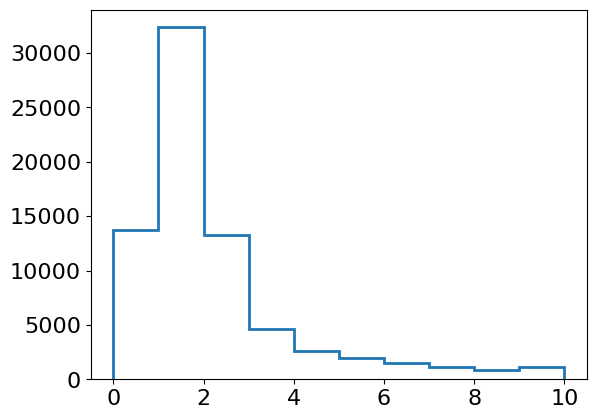

In [39]:
categories = make_categories(evtdf)

###########

nu_evtdf = evtdf[categories[-2]]
print(max(evtdf.slc.truth.np))
print(nu_evtdf.shape[0])
print(nu_evtdf[nu_evtdf.slc.truth.np > 0].shape[0])

cut_results = apply_cuts(nu_evtdf, [stub_mask], flip_last_cut=False)
mask = cut_results[-1]
noStub_nu_evtdf = add_hdr_info(nu_evtdf[mask])



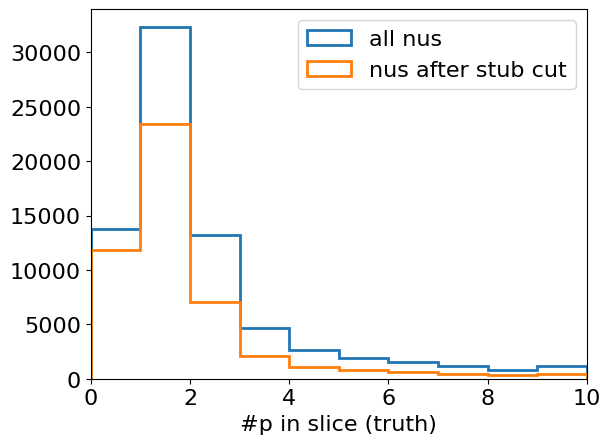

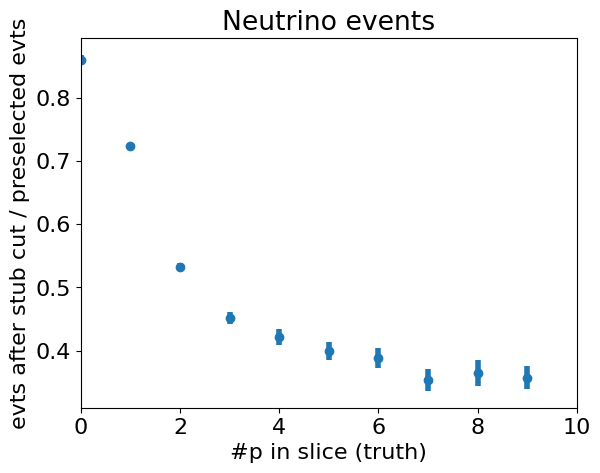

<class 'tuple'>
zero kinetic p:  (13742, 208)
zero kinetic p:  (11811, 210)


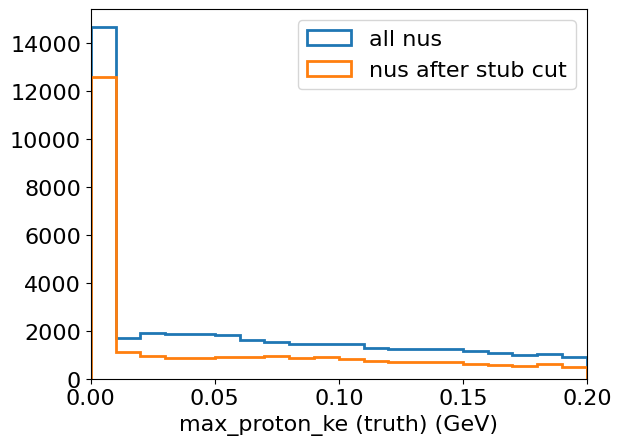

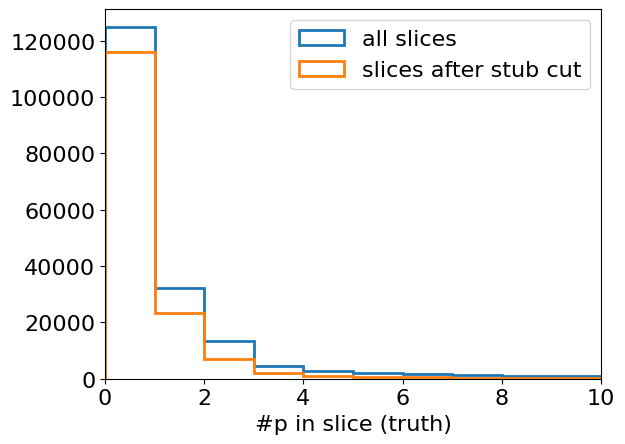

In [50]:
xrange = (0,10)
mybins = 10
n = plt.hist(nu_evtdf.slc.truth.np, bins=mybins, range=xrange, histtype='step', linewidth=2, label='all nus')
noStub_n = plt.hist(noStub_nu_evtdf.slc.truth.np, bins=mybins, range=xrange, histtype='step', linewidth=2, label='nus after stub cut')
#plt.hist(remaining_nus.slc.truth.np, bins=mybins, range=xrange, histtype='step')
plt.legend()
plt.xlim(xrange)
plt.xlabel('#p in slice (truth)')
plt.show()

err = np.sqrt(noStub_n[0]/(n[0])**2 + 4*(noStub_n[0])**2*(n[0])**(-5))
plt.errorbar(n[1][:-1], noStub_n[0]/n[0], yerr=err, fmt="o")
plt.xlim(xrange)
plt.xlabel('#p in slice (truth)')
plt.ylabel('evts after stub cut / preselected evts')
plt.title("Neutrino events")
plt.show()

print(type(n))

# 

print('zero kinetic p: ', nu_evtdf[nu_evtdf.slc.truth.max_proton_ke == 0.].shape)
print('zero kinetic p: ', noStub_nu_evtdf[noStub_nu_evtdf.slc.truth.max_proton_ke == 0.].shape)
xrange = (0, 0.2)
mybins = 20
plt.hist(nu_evtdf.slc.truth.max_proton_ke, histtype='step', linewidth=2, 
         label='all nus', bins=mybins, range=xrange)
plt.hist(noStub_nu_evtdf.slc.truth.max_proton_ke, histtype='step', linewidth=2, 
         label='nus after stub cut', bins=mybins, range=xrange)
#plt.hist(remaining_nus.slc.truth.np, bins=mybins, range=xrange, histtype='step')
plt.legend()
plt.xlim(xrange)
plt.xlabel('max_proton_ke (truth) (GeV)')
plt.show()

##

cut_results = apply_cuts(evtdf, [stub_mask], flip_last_cut=False)
mask = cut_results[-1]
#noStub_evtdf = add_hdr_info(evtdf[mask])
noStub_evtdf = evtdf[mask]

xrange = (0,10)
mybins = 10
plt.hist(evtdf.slc.truth.np, bins=mybins, range=xrange, histtype='step', linewidth=2, label='all slices')
plt.hist(noStub_evtdf.slc.truth.np, bins=mybins, range=xrange, histtype='step', linewidth=2, 
         label='slices after stub cut')
#plt.hist(remaining_nus.slc.truth.np, bins=mybins, range=xrange, histtype='step')
plt.legend()
plt.xlim(xrange)
plt.xlabel('#p in slice (truth)')
plt.show()

/tmp/ipykernel_11623/2178594100.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.hist(noStub_evtdf[noStub_categories[c]].slc.truth.np, bins=mybins, range=xrange, histtype='step',


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

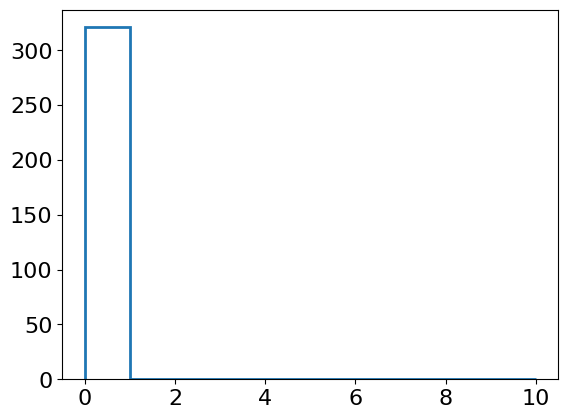

In [51]:
cut_results = apply_cuts(evtdf, [stub_mask], flip_last_cut=False)
mask = cut_results[-1]
noStub_evtdf = add_hdr_info(evtdf[mask])

categories = make_categories(evtdf, detailed_nu=True)
noStub_categories = make_categories(noStub_nu_evtdf, detailed_nu=True)

xrange = (0,10)
mybins = 10
for c in range(len(categories)):
    plt.hist(evtdf[categories[c]].slc.truth.np, bins=mybins, range=xrange, histtype='step', 
             linewidth=2, label='all preselected')
    plt.hist(noStub_evtdf[noStub_categories[c]].slc.truth.np, bins=mybins, range=xrange, histtype='step', 
             linewidth=2, label='after stub cut')
    plt.legend()
    plt.xlim(xrange)
    plt.xlabel('#p in slice (truth)')
    plt.title(categories[c].name)
    plt.show()


/tmp/ipykernel_11623/498941048.py:130: RuntimeWarning: invalid value encountered in true_divide
  cut_results_df_percent.loc[func_output[1]] = np.array(row_mc)/np.array(first_row_mc)


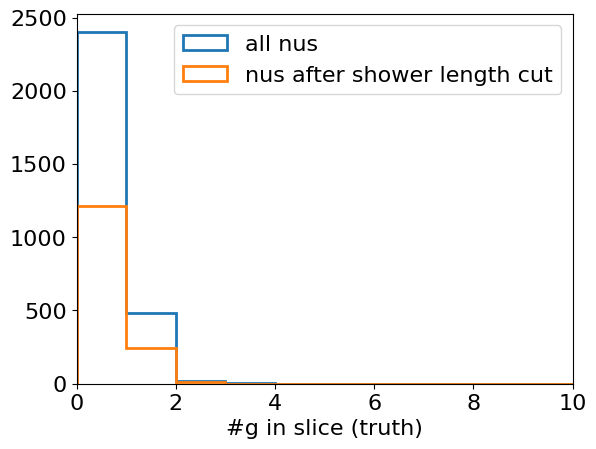

/tmp/ipykernel_11623/990237062.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.hist(nu_evtdf[categories[0]].slc.truth.ng, bins=mybins, range=xrange, histtype='step',


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 [<matplotlib.patches.Polygon at 0x7f15c9bedb50>])

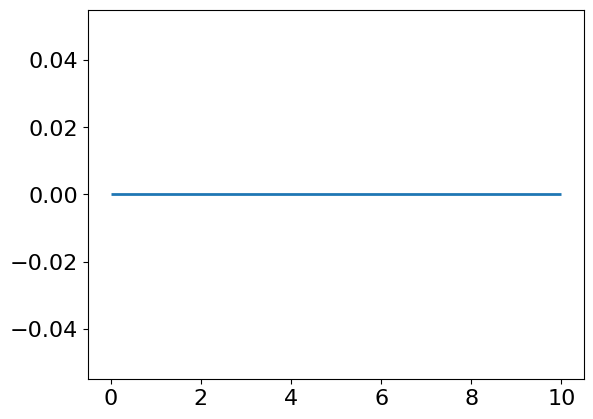

In [35]:
# How many gammas?

cut_results = apply_cuts(nu_evtdf, [max_shw_len_mask], flip_last_cut=False)
mask = cut_results[-1]
noShow_nu_evtdf = add_hdr_info(nu_evtdf[mask])

xrange = (0,10)
mybins = 10
plt.hist(nu_evtdf.slc.truth.ng, bins=mybins, range=xrange, histtype='step', linewidth=2, label='all nus')
plt.hist(noShow_nu_evtdf.slc.truth.ng, bins=mybins, range=xrange, histtype='step', linewidth=2, 
         label='nus after shower length cut')
#plt.hist(remaining_nus.slc.truth.np, bins=mybins, range=xrange, histtype='step')
plt.legend()
plt.xlim(xrange)
plt.xlabel('#g in slice (truth)')
plt.show()

plt.hist(nu_evtdf[categories[0]].slc.truth.ng, bins=mybins, range=xrange, histtype='step', 
         linewidth=2, label='all '+categories[0].name)


In [136]:
evtdf[categories[0]].slc.truth.ng
#nu_evtdf[categories[0]]

sample  __ntuple  entry  rec.slc..index
0       18        19     0                 0.0
        4         15     0                 0.0
        2         6      1                 0.0
        16        6      0                 0.0
                  23     19                0.0
                                          ... 
        468       24     9                 0.0
        466       20     8                 0.0
        469       9      0                 0.0
        470       1      13                0.0
                  16     0                 0.0
Name: ng, Length: 321, dtype: float64

## Revisit some plots

In [ ]:
# cut_list = [not_stub_05, not_stub_1, not_stub_2, not_stub_3,
            max_shw_len_mask, ok_chi2mu, ok_chi2p,
           numi_angle_mask, open_angle_mask, shortTrk_len_mask]

/tmp/ipykernel_15542/230500275.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var[np.isnan(var) | (var < 0)] = -10


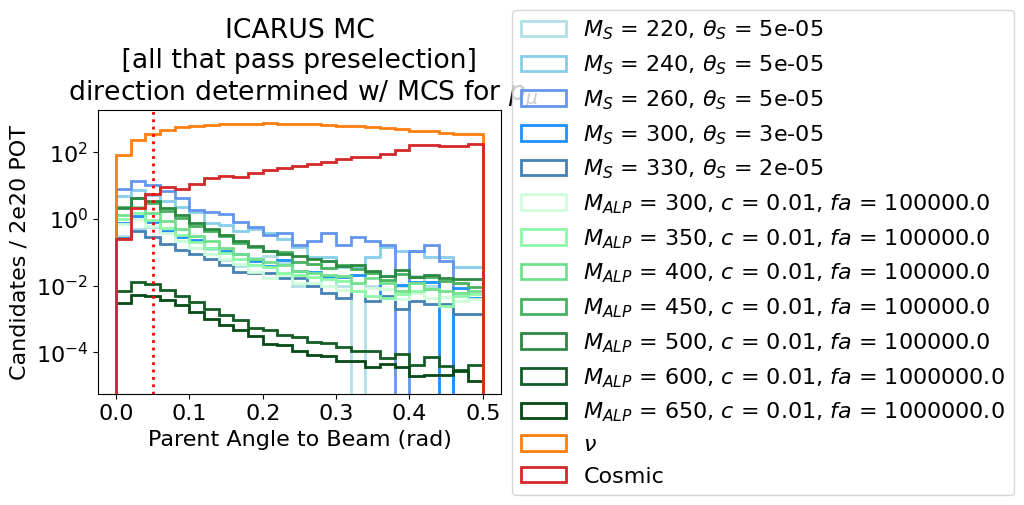

/icarus/app/users/jdyer/dev_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_15542/230500275.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var[np.isnan(var) | (var < 0)] = -10


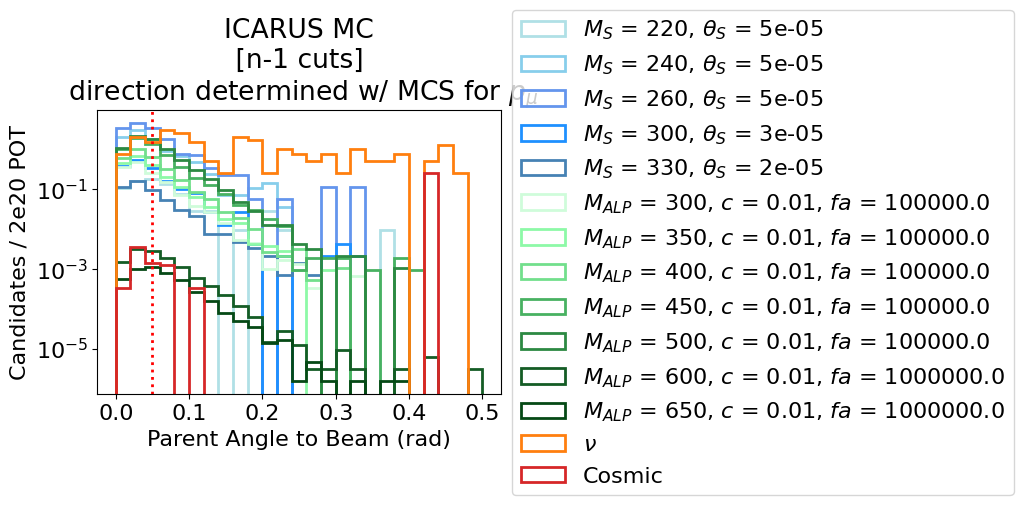

In [40]:
## Plot numi angle

plot_scalar_numi_angle(evtdf, vline=NuMI_angle_thresh, 
                       sample_description="\n [all that pass preselection]", density=False)

nm1_cut_list = [not_stub_05, not_stub_1, not_stub_2, not_stub_3, # 'nm1' for 'n minus 1'
                max_shw_len_mask, ok_chi2mu, ok_chi2p, 
                open_angle_mask, shortTrk_len_mask]
mask = apply_cuts(evtdf, nm1_cut_list)[-1]

plot_scalar_numi_angle(evtdf[mask], vline=NuMI_angle_thresh, 
                       sample_description="\n [n-1 cuts]", density=False)

# Notes:

# Look at this with and w/out the short track length mask. If we are more agressive with this cut, 
#     then together with the short track length cut we can eliminate remaining nu. 
# Are these things actually correlated, or did that just happen by chance?


/tmp/ipykernel_30485/515153914.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


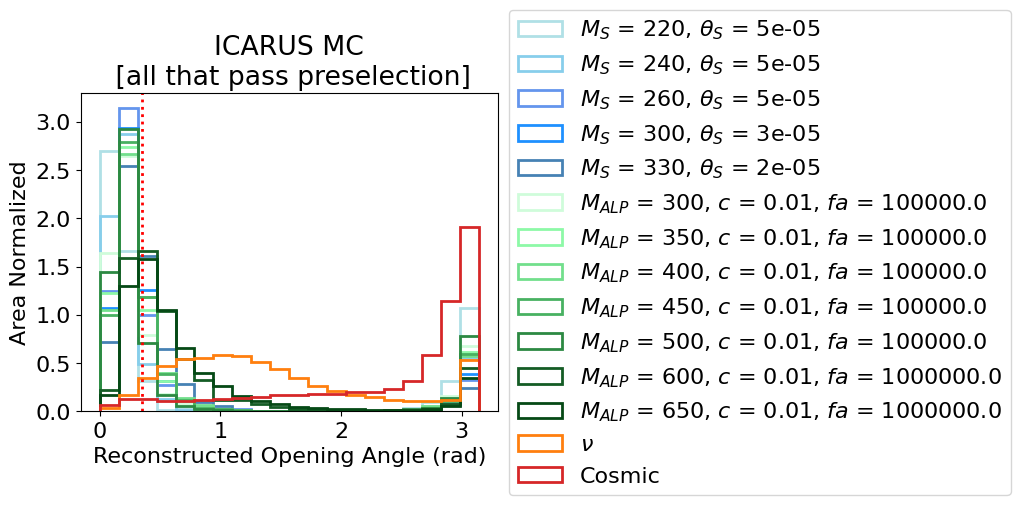

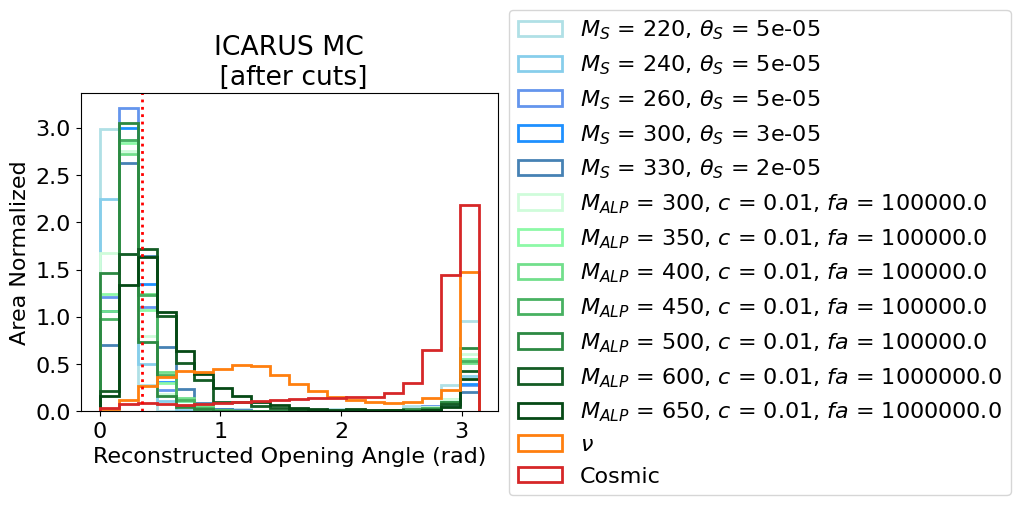

In [45]:
# Opening Angle

plot_trk_open_angle(evtdf, sample_description="\n [all that pass preselection]", 
                    vline=open_angle_thresh)

#cut_list = [numi_angle_mask, open_angle_mask, stub_mask, shortTrk_len_mask]
#mask = apply_cuts(evtdf, cut_list)[-1]

plot_trk_open_angle(evtdf[mask], sample_description="\n [after cuts]", 
                    vline=open_angle_thresh)

/tmp/ipykernel_13431/1232455691.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


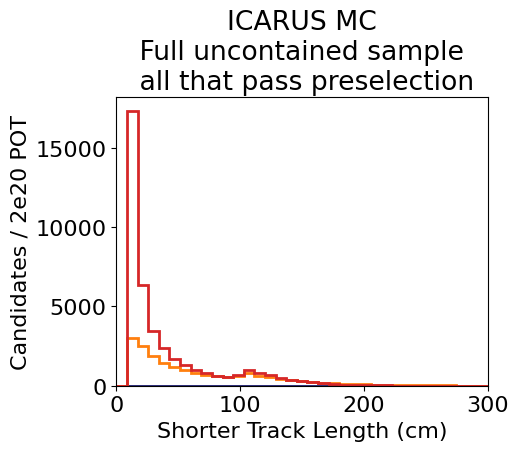

/tmp/ipykernel_13431/1232455691.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


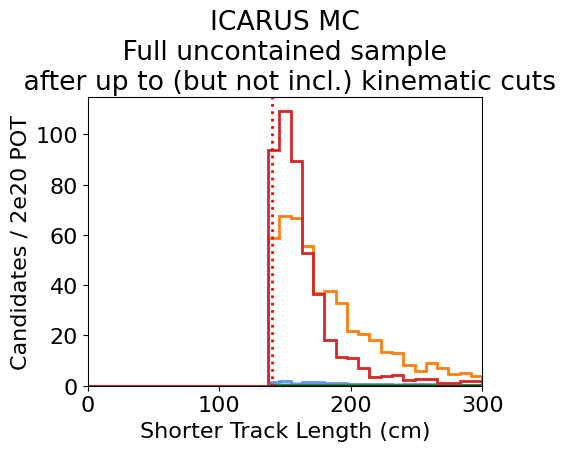

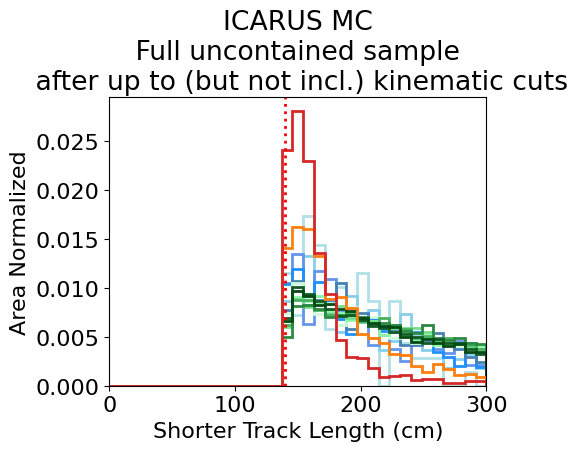

140.0


In [83]:
## Plot Shorter track length 

plot_trk_len(evtdf, "Shorter", sample_description="\n Full uncontained sample \n all that pass preselection",
             bsm=True, density=False)#, vline=trk_len_thresh)

#cut_list = [numi_angle_mask, open_angle_mask, stub_mask]#, shortTrk_len_mask]
#cut_list = [both_muon_tracks_mask, numi_angle_mask, open_angle_mask, stub_mask, max_shw_len_mask]
#cut_list = [not_stub_05, not_stub_1, not_stub_2, not_stub_3,
#            max_shw_len_mask, ok_chi2mu, ok_chi2p,
#           numi_angle_mask, open_angle_mask]
mask = apply_cuts(evtdf, no_kin)[-1]
plot_trk_len(evtdf[mask], "Shorter", sample_description="\n Full uncontained sample \n after up to (but not incl.) kinematic cuts", 
             vline=trk_len_thresh, bsm=False, density=False)#, vline=trk_len_thresh)
#plot_trk_len(evtdf[mask], "Shorter", sample_description="\n Full uncontained sample \n after up to (but not incl.) kinematic cuts", 
#             vline=trk_len_thresh, bsm=False, density=False)#, vline=trk_len_thresh)
plot_trk_len(evtdf[mask], "Shorter", sample_description="\n Full uncontained sample \n after up to (but not incl.) kinematic cuts", 
             vline=trk_len_thresh, bsm=False, density=True)#, vline=trk_len_thresh)

#mask = apply_cuts(evtdf_both_unc, cut_list)[-1]
#plot_trk_len(evtdf_both_unc[mask], "Shorter", sample_description="\n FULLY EXITING \n after other cuts", vline=trk_len_thresh)#, vline=trk_len_thresh)

#mask = apply_cuts(evtdf_semi_con, cut_list)[-1]
#plot_trk_len(evtdf_semi_con[mask], "Shorter", sample_description="\n SEMI CONTAINED \n after other cuts", vline=trk_len_thresh)#, vline=trk_len_thresh)

#plot_trk_len(evtdf[mask], "Shorter", sample_description="\n Full uncontained sample \n [after other cuts]")#, vline=trk_len_thresh)
print(trk_len_thresh)

/tmp/ipykernel_20247/574136465.py:30: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


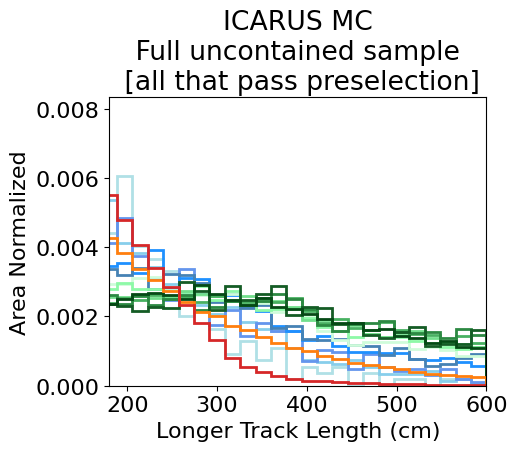

NameError: name 'both_muon_tracks_mask' is not defined

In [24]:
## Plot Longer track length 

plot_trk_len(evtdf, "Longer", sample_description="\n Full uncontained sample \n [all that pass preselection]")#, vline=trk_len_thresh)

cut_list = [both_muon_tracks_mask, numi_angle_mask, open_angle_mask, stub_mask, 
            max_shw_len_mask, other_trk_len_mask, third_trk_dist_mask]
mask = apply_cuts(evtdf, cut_list)[-1]

plot_trk_len(evtdf[mask], "Longer", sample_description="\n Full uncontained sample \n [after other cuts]")#, vline=trk_len_thresh)

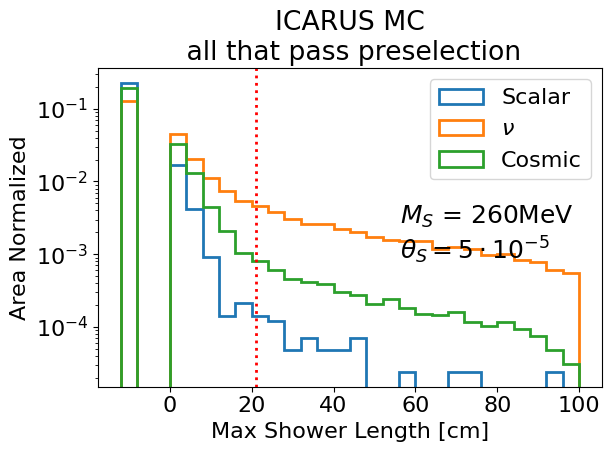

/cvmfs/larsoft.opensciencegrid.org/products/numpy/v1_20_1/Linux64bit+3.10-2.17-e20-p392/lib/python3.9/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


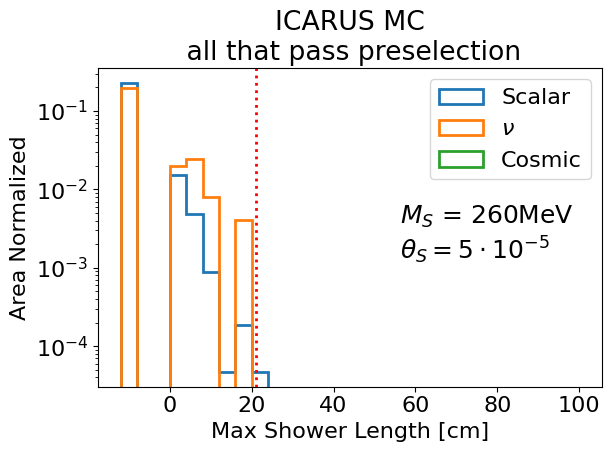

In [42]:
# Plot Max Shower Length

plot_max_shw_len(evtdf, sample_description="\n all that pass preselection", vline=max_shw_len_thresh)

cut_list = [both_muon_tracks_mask, numi_angle_mask, open_angle_mask, stub_mask, 
            max_shw_len_mask, other_trk_len_mask, third_trk_dist_mask]
mask = apply_cuts(evtdf, cut_list)[-1]

plot_max_shw_len(evtdf[mask], sample_description="\n [after other cuts", vline=max_shw_len_thresh)

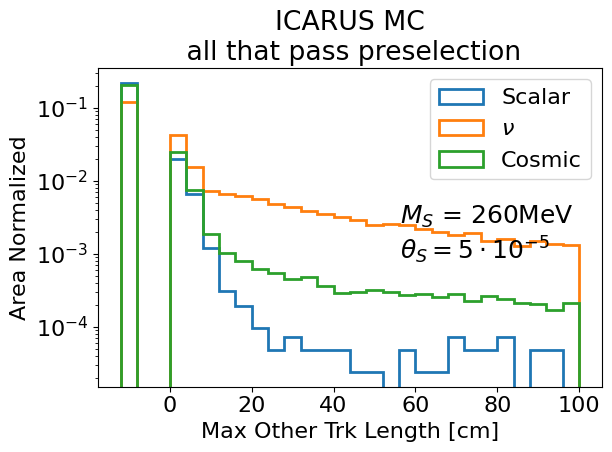

/cvmfs/larsoft.opensciencegrid.org/products/numpy/v1_20_1/Linux64bit+3.10-2.17-e20-p392/lib/python3.9/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


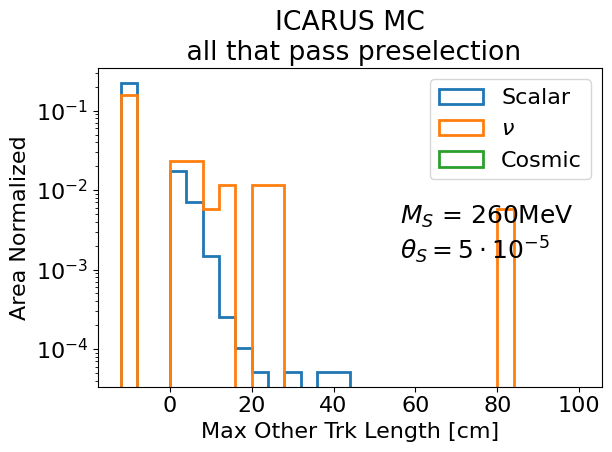

In [68]:
# Plot Other Track Length

plot_other_trk_len(evtdf, sample_description="\n all that pass preselection")

cut_list = [both_muon_tracks_mask, numi_angle_mask, open_angle_mask, 
            stub_mask, max_shw_len_mask, shortTrk_len_mask]
mask = apply_cuts(evtdf, cut_list)[-1]

plot_other_trk_len(evtdf[mask], sample_description="\n [after other cuts")

/cvmfs/larsoft.opensciencegrid.org/products/numpy/v1_20_1/Linux64bit+3.10-2.17-e20-p392/lib/python3.9/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


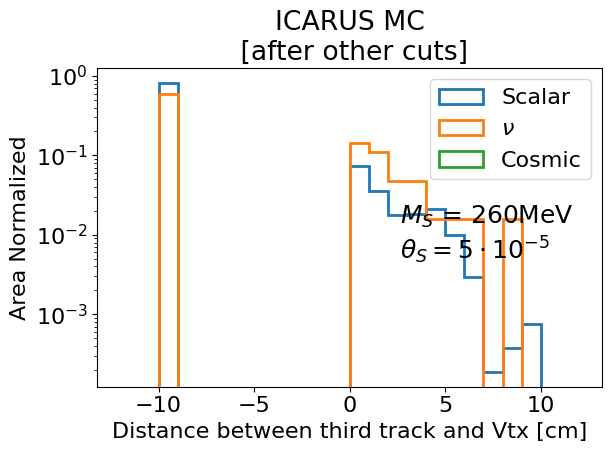

In [54]:
# Third trk distance

cut_list = [both_muon_tracks_mask, numi_angle_mask, open_angle_mask, stub_mask, 
            max_shw_len_mask, other_trk_len_mask]
mask = apply_cuts(evtdf, cut_list)[-1]
plot_third_trk_dist(evtdf[mask], sample_description="\n [after other cuts]")

## Optimize Cuts 

Create statistical significance scatter plot for each sample individually. Then eyeball the best choice - one size fits all style.

~~~~

TO DO:

- fix to handle the various samples
- optimize for all cuts (including chi2 and dQ/dx)

~~~~

For simplicity, it makes sense to lump together all BSM and do one optimization.

But, that optimization scales to expected numbers of events per POT, and that assumes benchmark parameters (theta, fa). How can I optimize for all at once? Is it even possible?

For a given model with different benchmark parameters, the optimization will vary.

In [64]:
cat = make_categories(evtdf, bsm=True)
for c in cat: print(c.name)

BSM
$\nu$
Cosmic


In [52]:
def optimize_cut(df, mask, scan_vals, param, plot=False):

    if plot:
        fig = plt.figure()
        ax = plt.subplot(111)
    categories = make_categories(df, bsm=False) # This one is just to know what the samples are so you can loop over them.
    #print(len(categories))
    for c in categories[:-2]: #range(len(categories)-2):
        #print(c)
        significance = []
        for val in scan_vals:
            #m = mask(df, thresh=val)[0]
            #temp_df = df[m]
            #cat = make_categories(temp_df) # This one has the correct dimensions to match temp_df, which we'll be using it for.
            #print(len(cat))
            #for thing in cat: print(thing.name)
        #for c in range(len(categories)-2):
            significance.append(
                sum(df[c][mask(df[c], thresh=val)[0]].scale)/
                np.sqrt( 
                    sum(df[c][mask(df[c], thresh=val)[0]].scale) + sum(df[categories[-2]][mask(df[categories[-2]], thresh=val)[0]].scale) + sum(df[categories[-1]][mask(df[categories[-1]], thresh=val)[0]].scale)
                )
            )
            
        significance = np.array(significance)
        ok = ~np.isnan(significance)
        significance = significance[ok]
        x_vals = scan_vals[ok]
        best_val = x_vals[np.argmax(np.array(significance))]
        #print(type(significance))
        #print(best_val)
        #print(type(best_val))
        #print(significance[np.argmax(np.array(significance))])
        #print('The best %a to cut on for %a is: ' % (mask(df, thresh=val)[1], c.name), best_val)
        
        if plot:
            plt.plot(x_vals, significance/np.max(significance), '-o', 
                     label = (c.name + ' (%a)' % (round(1000 * best_val)/1000.)), color=c.color)
            
    if plot:
        plt.xlabel(param)
        plt.ylabel('Relative S/sqrt(S+B)')
        #plt.yscale('log')
        #plt.axvline([best_val], linestyle=":", color="r", linewidth=2)
        
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))
        
        plt.show()
    
    return(best_val)


/icarus/app/users/jdyer/dev_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_13431/2039692995.py:19: RuntimeWarning: invalid value encountered in double_scalars
  sum(df[c][mask(df[c], thresh=val)[0]].scale)/


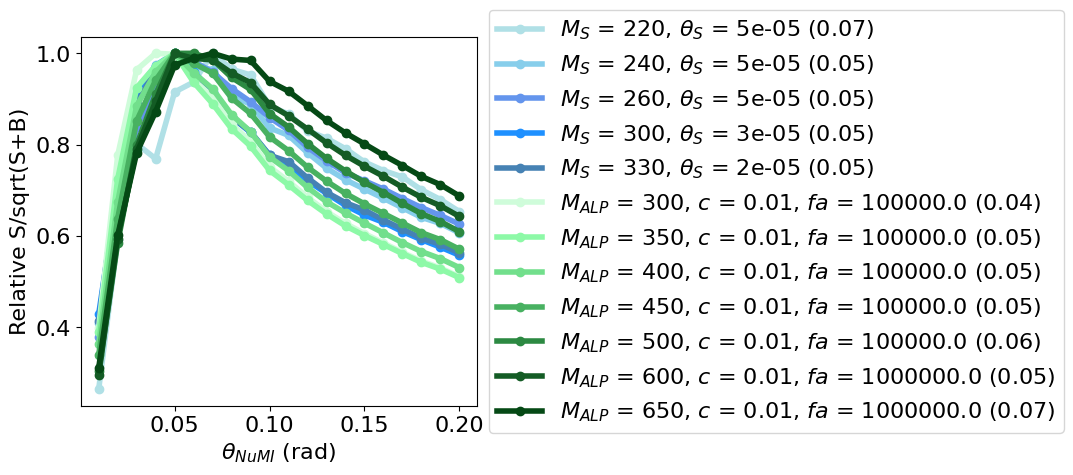

/tmp/ipykernel_13431/2039692995.py:19: RuntimeWarning: invalid value encountered in double_scalars
  sum(df[c][mask(df[c], thresh=val)[0]].scale)/


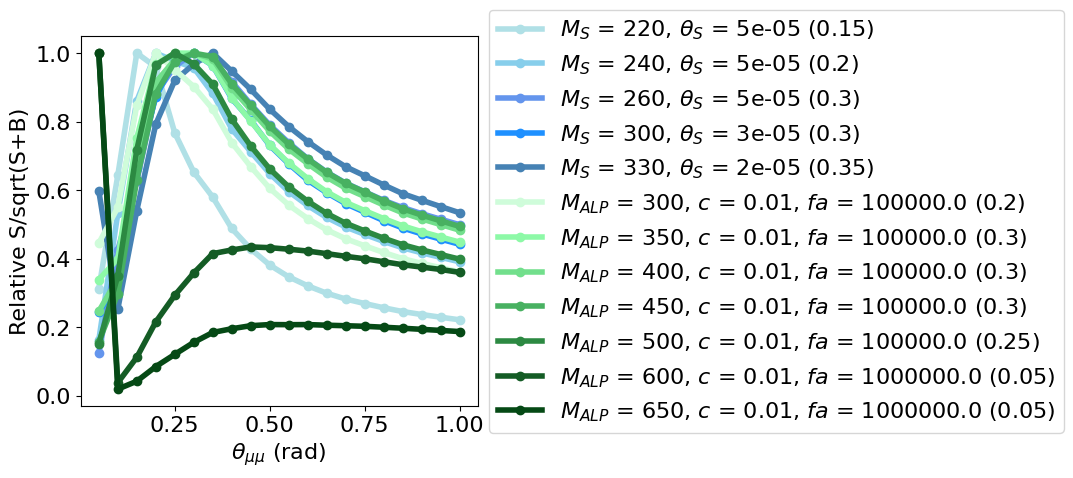

/icarus/app/users/jdyer/dev_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


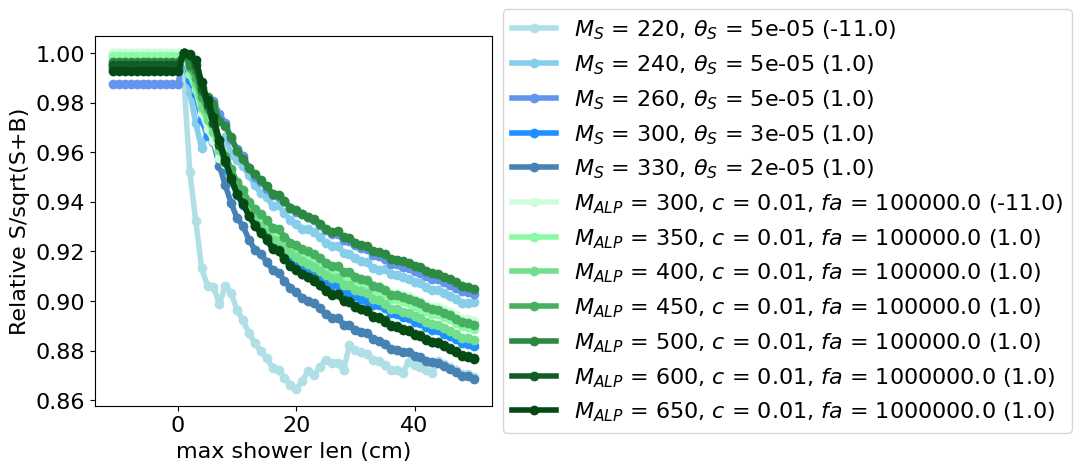

/icarus/app/users/jdyer/dev_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


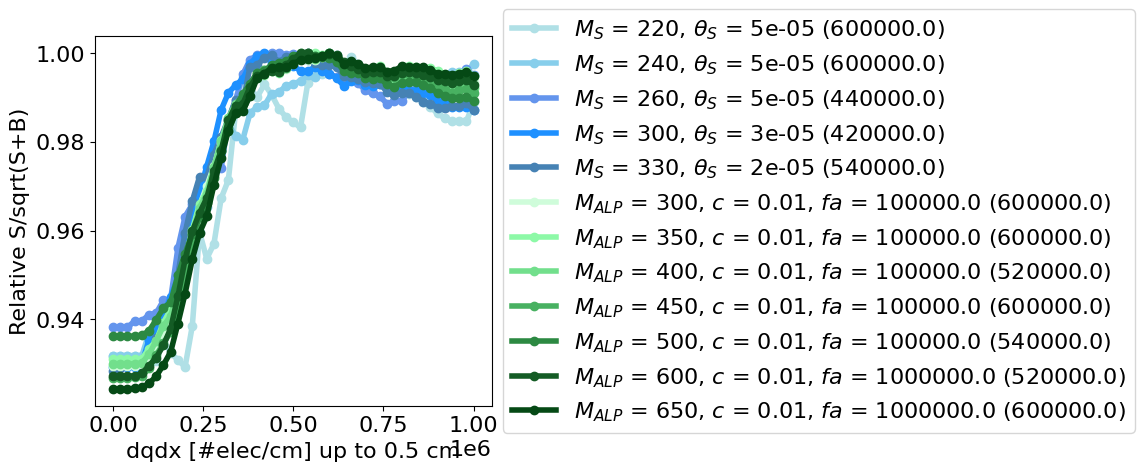

/icarus/app/users/jdyer/dev_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


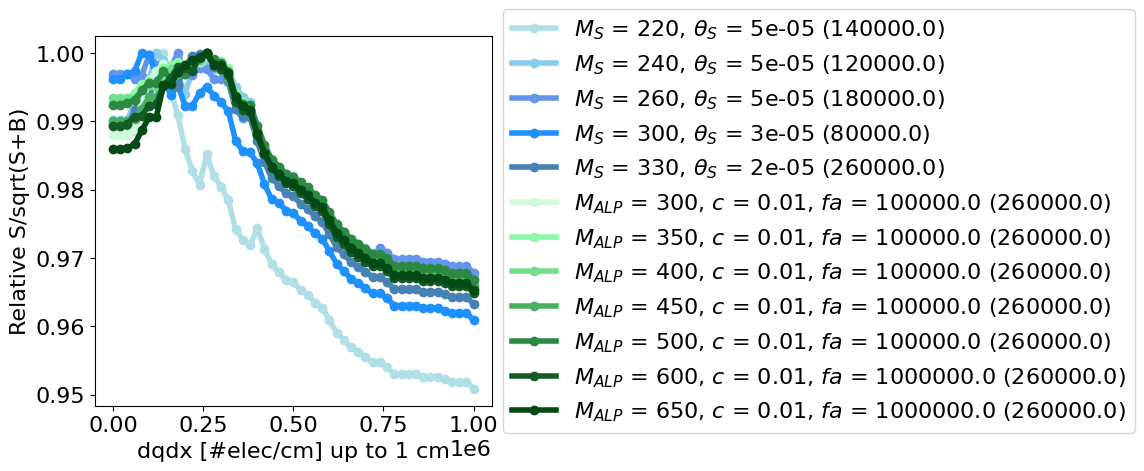

/icarus/app/users/jdyer/dev_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


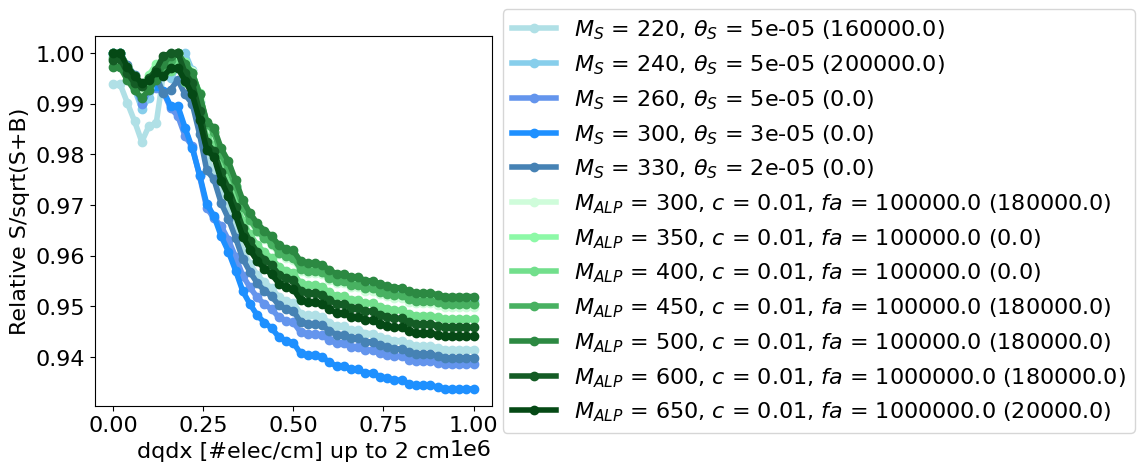

/icarus/app/users/jdyer/dev_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


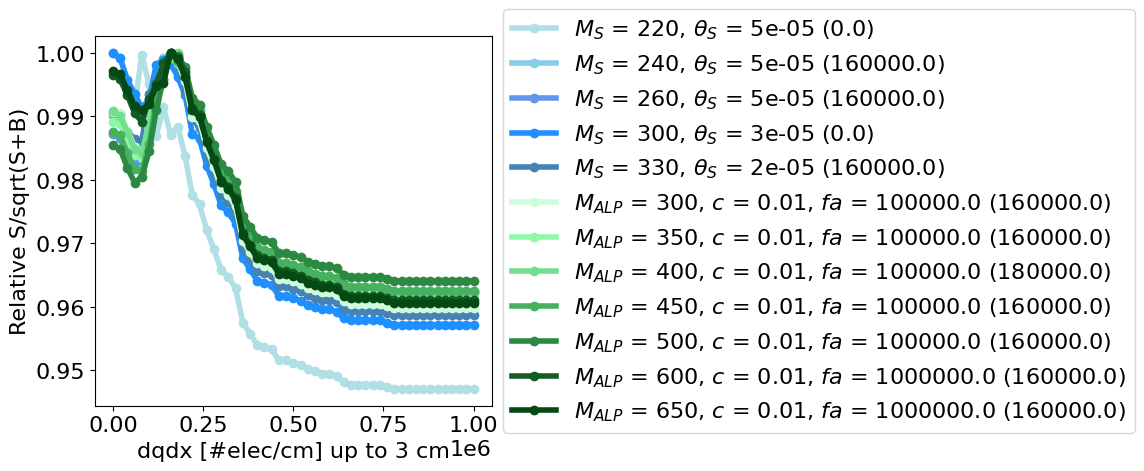

/icarus/app/users/jdyer/dev_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_13431/2039692995.py:19: RuntimeWarning: invalid value encountered in double_scalars
  sum(df[c][mask(df[c], thresh=val)[0]].scale)/


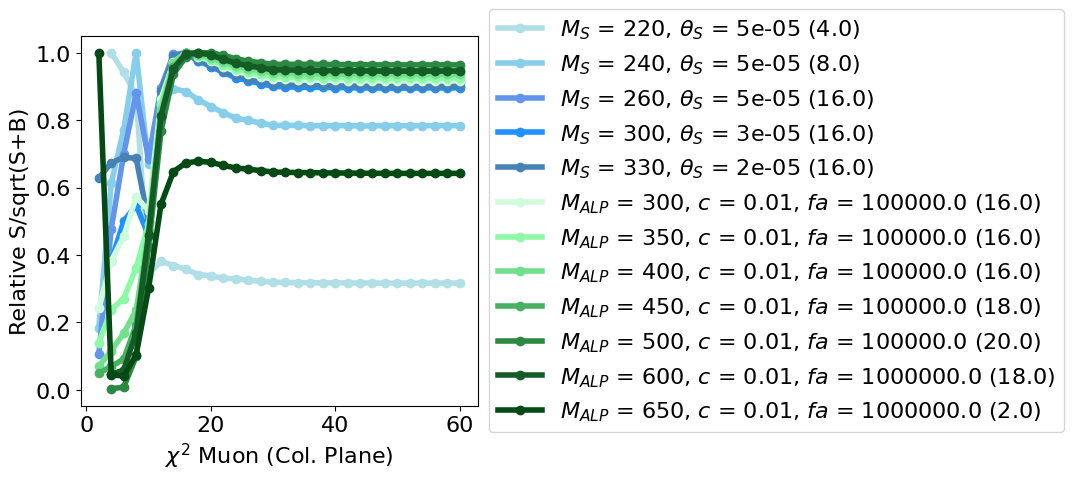

/icarus/app/users/jdyer/dev_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/env/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


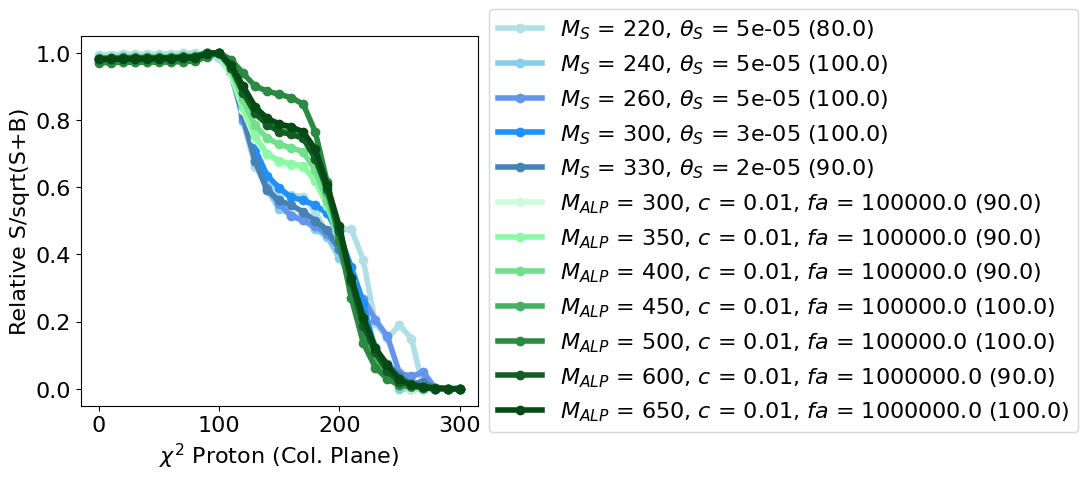

In [54]:
#all_cuts = [both_muon_tracks_mask, numi_angle_mask, open_angle_mask, stub_mask, 
#            max_shw_len_mask, other_trk_len_mask, third_trk_dist_mask, shortTrk_len_mask]

# S_NuMI Angle

cut_list = [not_stub_05, not_stub_1, not_stub_2, not_stub_3,
            max_shw_len_mask, ok_chi2mu, ok_chi2p, open_angle_mask]
mask = apply_cuts(evtdf, cut_list)[-1]
df = evtdf[mask]
#plot_scalar_numi_angle(df, vline=NuMI_angle_thresh, 
#                       sample_description="")
a = optimize_cut(df, numi_angle_mask, np.linspace(0., 0.2, 21), '$\\theta_{NuMI}$ (rad)', plot=True)

# Opening angle

cut_list = [not_stub_05, not_stub_1, not_stub_2, not_stub_3,
            max_shw_len_mask, ok_chi2mu, ok_chi2p,
           numi_angle_mask]
mask = apply_cuts(evtdf, cut_list)[-1]
df = evtdf[mask]
#plot_trk_open_angle(df, sample_description="\n [after cuts]", 
#                    vline=open_angle_thresh)
a = optimize_cut(df, open_angle_mask, np.linspace(0., 1.0, 21), '$\\theta_{\mu\mu}$ (rad)', plot=True)

# Max Shower Length
#    Note: the reason the significance isn't 0 if you cut with -11 is because some values are NaN, not just -10.

cut_list = [not_stub_05, not_stub_1, not_stub_2, not_stub_3,
            ok_chi2mu, ok_chi2p,
           numi_angle_mask, open_angle_mask]
mask = apply_cuts(evtdf, cut_list)[-1]
df = evtdf[mask]
a = optimize_cut(df, max_shw_len_mask, np.linspace(-11, 50., 62), 'max shower len (cm)', plot=True) #np.concatenate((np.array([-11]), np.linspace(0., 50., 51)))

# STUB CUTS

# stub: dqdx up to 0.5
cut_list = [not_stub_1, not_stub_2, not_stub_3,
            max_shw_len_mask, ok_chi2mu, ok_chi2p,
           numi_angle_mask, open_angle_mask]
mask = apply_cuts(evtdf, cut_list)[-1]
df = evtdf[mask]
a = optimize_cut(df, not_stub_05, np.linspace(0., 1000000., 51), 'dqdx [#elec/cm] up to 0.5 cm', plot=True) #np.concatenate((np.array([-11]), np.linspace(0., 50., 51)))

# stub: dqdx up to 1
cut_list = [not_stub_05, not_stub_2, not_stub_3,
            max_shw_len_mask, ok_chi2mu, ok_chi2p,
           numi_angle_mask, open_angle_mask]
mask = apply_cuts(evtdf, cut_list)[-1]
df = evtdf[mask]
a = optimize_cut(df, not_stub_1, np.linspace(0., 1000000., 51), 'dqdx [#elec/cm] up to 1 cm', plot=True) #np.concatenate((np.array([-11]), np.linspace(0., 50., 51)))

# stub: dqdx up to 2
cut_list = [not_stub_05, not_stub_1, not_stub_3,
            max_shw_len_mask, ok_chi2mu, ok_chi2p,
           numi_angle_mask, open_angle_mask]
mask = apply_cuts(evtdf, cut_list)[-1]
df = evtdf[mask]
a = optimize_cut(df, not_stub_2, np.linspace(0., 1000000., 51), 'dqdx [#elec/cm] up to 2 cm', plot=True) #np.concatenate((np.array([-11]), np.linspace(0., 50., 51)))

# stub: dqdx up to 1
cut_list = [not_stub_05, not_stub_1, not_stub_2,
            max_shw_len_mask, ok_chi2mu, ok_chi2p,
           numi_angle_mask, open_angle_mask]
mask = apply_cuts(evtdf, cut_list)[-1]
df = evtdf[mask]
a = optimize_cut(df, not_stub_3, np.linspace(0., 1000000., 51), 'dqdx [#elec/cm] up to 3 cm', plot=True) #np.concatenate((np.array([-11]), np.linspace(0., 50., 51)))


# MUON ID

# mu PID
cut_list = [not_stub_05, not_stub_1, not_stub_2, not_stub_3,
            max_shw_len_mask, ok_chi2p,
           numi_angle_mask, open_angle_mask]
mask = apply_cuts(evtdf, cut_list)[-1]
df = evtdf[mask]
a = optimize_cut(df, ok_chi2mu, np.linspace(0., 60., 31), '$\\chi^2$ Muon (Col. Plane)', plot=True) #np.concatenate((np.array([-11]), np.linspace(0., 50., 51)))


# proton PID
cut_list = [not_stub_05, not_stub_1, not_stub_2, not_stub_3,
            max_shw_len_mask, ok_chi2mu,
           numi_angle_mask, open_angle_mask]
mask = apply_cuts(evtdf, cut_list)[-1]
df = evtdf[mask]
a = optimize_cut(df, ok_chi2p, np.linspace(0., 300., 31), '$\\chi^2$ Proton (Col. Plane)', plot=True) #np.concatenate((np.array([-11]), np.linspace(0., 50., 51)))



## Other trk length

#cut_list = [stub_mask, max_shw_len_mask, both_muon_tracks_mask,
#           numi_angle_mask, open_angle_mask]
#mask = apply_cuts(evtdf, cut_list)[-1]
#df = evtdf[mask]
#a = optimize_cut(df, other_trk_len_mask, np.linspace(0., 50., 51), 'other trk len (cm)', plot=True)

# third trk dist

#cut_list = [both_muon_tracks_mask, numi_angle_mask, open_angle_mask, stub_mask, 
#            max_shw_len_mask, other_trk_len_mask]
#mask = apply_cuts(evtdf, cut_list)[-1]
#df = evtdf[mask]
#a = optimize_cut(df, third_trk_dist_mask, np.linspace(0., 50., 51), 'third trk dist (cm)', plot=True)


## Shorter Track Length

#cut_list = [both_muon_tracks_mask, numi_angle_mask, open_angle_mask, stub_mask, max_shw_len_mask]
#mask = apply_cuts(evtdf, cut_list)[-1]
#df = evtdf[mask]
#a = optimize_cut(df, shortTrk_len_mask, np.linspace(0., 500., 101), 'shorter of tracks len (cm)', plot=True)

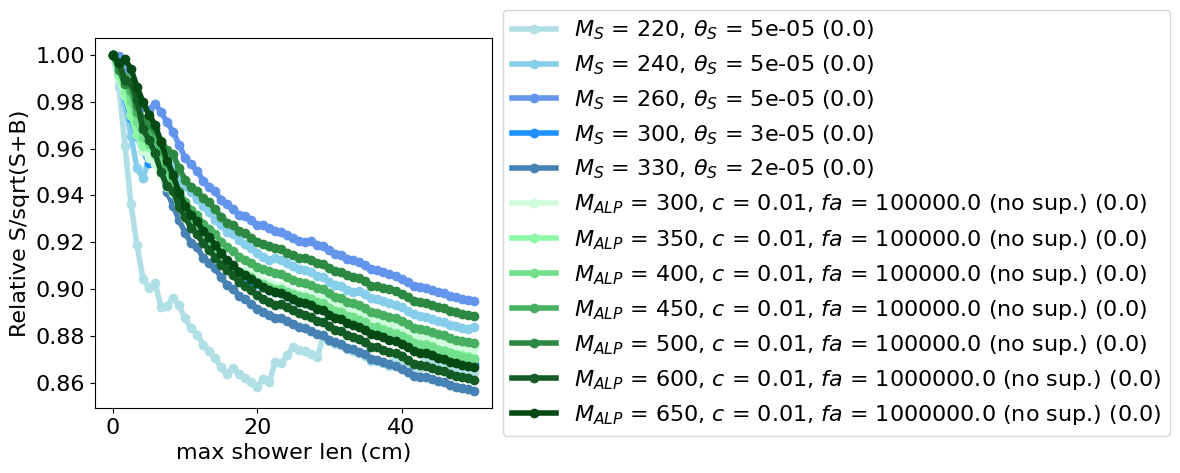

In [36]:
# Max Shower Length
#    Note: the reason the significance isn't 0 if you cut with -11 is because some values are NaN, not just -10.

cut_list = [not_stub_05, not_stub_1, not_stub_2, not_stub_3,
            ok_chi2mu, ok_chi2p,
           numi_angle_mask, open_angle_mask]
mask = apply_cuts(evtdf, cut_list)[-1]
df = evtdf[mask]
a = optimize_cut(df, max_shw_len_mask, np.linspace(0, 50., 61), 'max shower len (cm)', plot=True) #np.concatenate((np.array([-11]), np.linspace(0., 50., 51)))


/tmp/ipykernel_4096/2066092805.py:2: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(x, x/np.sqrt(x))


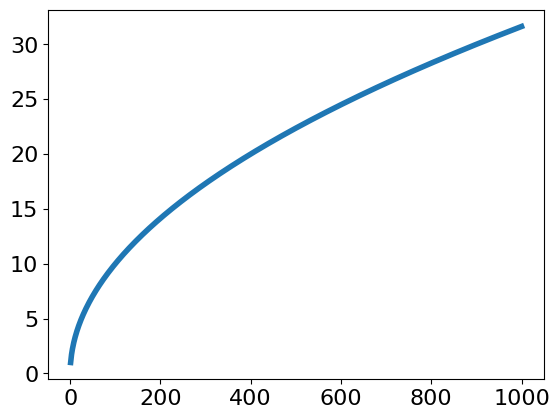

In [108]:
x = np.linspace(0, 1000., 1001)
plt.plot(x, x/np.sqrt(x))
plt.show()

#a = 
b = np.concatenate((np.array([-11.]), np.linspace(0., 50., 51)))


/tmp/ipykernel_30665/1235803923.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sum(temp_df[categories[0]].scale)/


The best 'S_NuMI_angle < 0.2 rad' to cut on is:  0.07


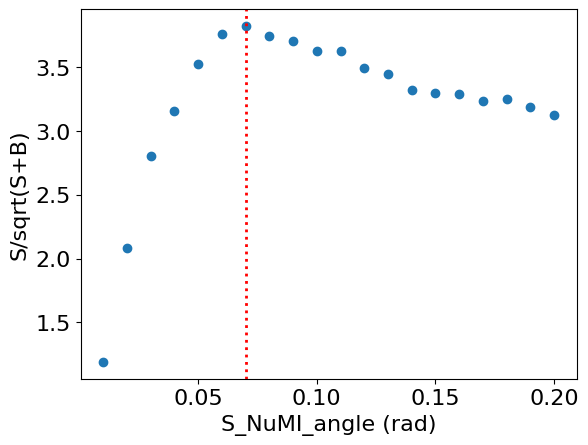

/tmp/ipykernel_30665/1235803923.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sum(temp_df[categories[0]].scale)/


The best 'opening angle < 1.0 rad' to cut on is:  0.30000000000000004


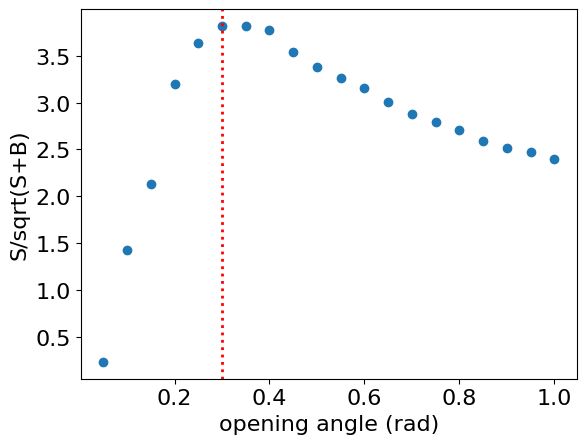

The best 'max shower len < 50.0 cm' to cut on is:  41.0


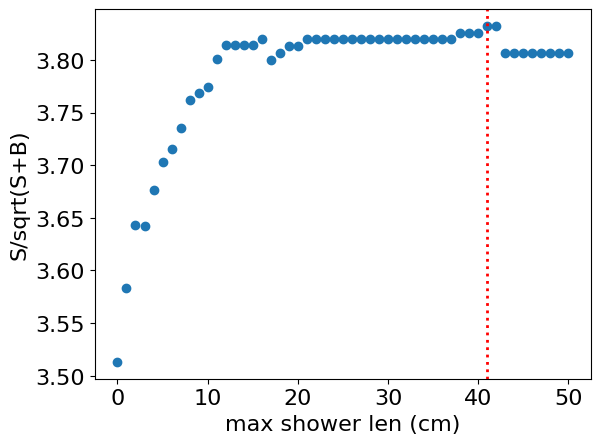

The best 'shorter of tracks > 500.0 cm' to cut on is:  75.0


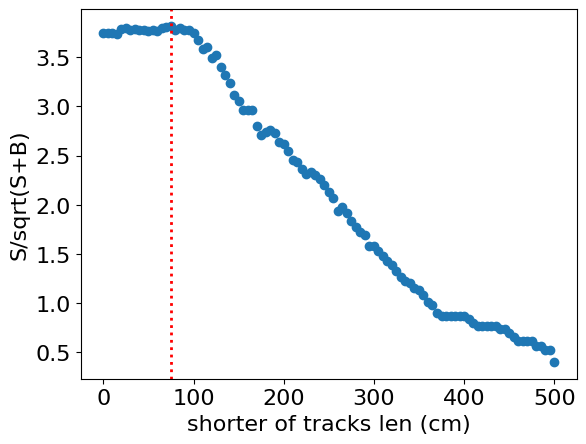

In [38]:
all_cuts = [both_muon_tracks_mask, numi_angle_mask, open_angle_mask, stub_mask, max_shw_len_mask, shortTrk_len_mask]

# S_NuMI Angle

cut_list = [both_muon_tracks_mask, open_angle_mask, stub_mask, max_shw_len_mask, shortTrk_len_mask]
mask = apply_cuts(evtdf, cut_list)[-1]
df = evtdf[mask]
#plot_scalar_numi_angle(df, vline=NuMI_angle_thresh, 
#                       sample_description="")
a = optimize_cut(df, numi_angle_mask, np.linspace(0., 0.2, 21), 'S_NuMI_angle (rad)', plot=True)

# Opening angle

cut_list = [both_muon_tracks_mask, numi_angle_mask, stub_mask, max_shw_len_mask, shortTrk_len_mask]
mask = apply_cuts(evtdf, cut_list)[-1]
df = evtdf[mask]
#plot_trk_open_angle(df, sample_description="\n [after cuts]", 
#                    vline=open_angle_thresh)
a = optimize_cut(df, open_angle_mask, np.linspace(0., 1.0, 21), 'opening angle (rad)', plot=True)

# Max Shower Length

cut_list = [both_muon_tracks_mask, numi_angle_mask, open_angle_mask, stub_mask, shortTrk_len_mask]
mask = apply_cuts(evtdf, cut_list)[-1]
df = evtdf[mask]
a = optimize_cut(df, max_shw_len_mask, np.linspace(0., 50., 51), 'max shower len (cm)', plot=True)

# Shorter Track Length

cut_list = [both_muon_tracks_mask, numi_angle_mask, open_angle_mask, stub_mask, max_shw_len_mask]
mask = apply_cuts(evtdf, cut_list)[-1]
df = evtdf[mask]
a = optimize_cut(df, shortTrk_len_mask, np.linspace(0., 500., 101), 'shorter of tracks len (cm)', plot=True)